# Effectuez une prédiction de revenus

## Sommaire

### Intro
- Paramétrage de l'environnement de travail
- Analyse descriptive données brutes
- Péparation de la dataset

### Misson 1
- Année(s) des données utilisées
- Nombre de pays présents
- Population couverte par l'analyse
- Type de quantiles

### Misson 2
- Diversité des distributions de revenus
- Représentation de la courbe de Lorenz
- Évolution des indices de Gini
- Classement des pays par indice de Gini

### Mission 3
- Ajout du coefficient d'élasticité
- Protocole de génération pour un pays donné
- Application du protocole sur la donnée
- Ajout du revenu moyen de chaque pays

## Intro

### paramétrage de l'environnement de travail

1. Libraries
2. Data sets

#### Libraries

In [4]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
import re
import math
import sklearn
import pandas as pd
import numpy as np
import seaborn as sns
import scipy
import scipy.stats as st
import warnings
import random
import sklearn.metrics as skm
import statsmodels
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import matplotlib.mlab as mlab
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import statsmodels.formula.api as smf
import datetime as dt

import collections
from pandas_profiling import ProfileReport
from pandas.plotting import scatter_matrix
from collections import Counter
from sklearn import linear_model
from sklearn import decomposition, preprocessing, metrics
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.utils.multiclass import unique_labels
# from sklearn.cross_validation import train_test_split [Deprecated since version 0.18: This module will be removed in 0.20. Use sklearn.model_selection.train_test_split instead]
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.stats import *
from scipy.stats import norm
from scipy.stats import ks_2samp
from scipy.stats import chisquare
from scipy.stats import chi2_contingency 
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, cophenet
from scipy.spatial.distance import cdist
from statsmodels.stats.outliers_influence import variance_inflation_factor
from pylab import rcParams
from matplotlib import rcParams
from matplotlib import gridspec
from matplotlib.collections import LineCollection

import os
%matplotlib inline

os.makedirs('graph', exist_ok=True)
plt.style.use('ggplot')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#### Data sets

In [6]:
given_data = pd.read_csv("/content/drive/MyDrive/OC/P7/P7_datasets/p7_data.csv")
world_bank = pd.read_csv("/content/drive/MyDrive/OC/P7/P7_datasets/wb_population.csv")
gini = pd.read_csv("/content/drive/MyDrive/OC/P7/P7_datasets/gini.csv")
coef = pd.read_csv("/content/drive/MyDrive/OC/P7/P7_datasets/gdim_coef.csv")

### analyse descriptive des données brutes


In [7]:
# affichage du fichier de la World Income Distribution
given_data.head()

,country,year_survey,quantile,nb_quantiles,income,gdpppp
0,ALB,2008,1,100,"728,89795",7297
1,ALB,2008,2,100,"916,66235",7297
2,ALB,2008,3,100,"1010,916",7297
3,ALB,2008,4,100,"1086,9078",7297
4,ALB,2008,5,100,"1132,6997",7297


In [8]:
# renommage de la colonne country en country_code
given_data.rename(columns= {'country': 'country_code'}, inplace=True)
given_data.tail()

,country_code,year_survey,quantile,nb_quantiles,income,gdpppp
11594,COD,2008,96,100,"810,6233","303,19305"
11595,COD,2008,97,100,"911,7834","303,19305"
11596,COD,2008,98,100,"1057,8074","303,19305"
11597,COD,2008,99,100,"1286,6029","303,19305"
11598,COD,2008,100,100,"2243,1226","303,19305"


In [9]:
given_data.dtypes

country_code    object
year_survey      int64
quantile         int64
nb_quantiles     int64
income          object
gdpppp          object
dtype: object

In [10]:
# remplacement des points decimaux en points
given_data["income"] = given_data["income"].str.replace(',','.')
given_data["gdpppp"] = given_data["gdpppp"].str.replace(',','.')

# convertir '
convert_columntype = {'income': float,
                      'gdpppp': float}
  
given_data = given_data.astype(convert_columntype)
given_data.dtypes

country_code     object
year_survey       int64
quantile          int64
nb_quantiles      int64
income          float64
gdpppp          float64
dtype: object

In [11]:
# taille du DataFrame given_data
given_data.shape

(11599, 6)

In [12]:
# description du fichier brut
given_data.describe()

,year_survey,quantile,nb_quantiles,income,gdpppp
count,11599.000000,11599.000000,11599.0,11599.000000,1.139900e+04
mean,2007.982757,50.500819,100.0,6069.224260,5.022128e+04
std,0.909633,28.868424,0.0,9414.185972,4.000688e+05
min,2004.000000,1.000000,100.0,16.719418,3.031931e+02
25%,2008.000000,25.500000,100.0,900.685515,2.576000e+03
50%,2008.000000,51.000000,100.0,2403.244900,7.560000e+03
75%,2008.000000,75.500000,100.0,7515.420900,1.877300e+04
max,2011.000000,100.000000,100.0,176928.550000,4.300332e+06


In [13]:
# comptage des valeurs manquantes
given_data.isnull().sum()

country_code      0
year_survey       0
quantile          0
nb_quantiles      0
income            0
gdpppp          200
dtype: int64

In [14]:
# cescription par année
given_data.groupby(by=['year_survey']).nunique()

,country_code,quantile,nb_quantiles,income,gdpppp
year_survey,,,,,
2004,1,100,1,100,1
2006,5,100,1,500,5
2007,15,100,1,1500,15
2008,76,100,1,7598,75
2009,12,100,1,1200,11
2010,6,100,1,600,6
2011,1,100,1,100,1


In [15]:
# affichage du fichier de correspondance Code ISO et nom du pays
code_pays = world_bank[['Country Name', 'Country Code']]
code_pays = code_pays.rename(columns= {'Country Name': 'country', 'Country Code': 'country_code'})
code_pays.head(3)

,country,country_code
0,Aruba,ABW
1,Africa Eastern and Southern,AFE
2,Afghanistan,AFG


In [16]:
# jointure de given_data et de code_pays
income = pd.merge(given_data, code_pays, on="country_code", how='left')
income.head(3)

,country_code,year_survey,quantile,nb_quantiles,income,gdpppp,country
0,ALB,2008,1,100,728.89795,7297.0,Albania
1,ALB,2008,2,100,916.66235,7297.0,Albania
2,ALB,2008,3,100,1010.91600,7297.0,Albania


In [17]:
# taille du DataFrame income
income.shape

(11599, 7)

In [18]:
# vérification de valeurs nulles
income.isnull().sum()

country_code      0
year_survey       0
quantile          0
nb_quantiles      0
income            0
gdpppp          200
country         100
dtype: int64

In [19]:
# agrégation par 'country' avec 'nunique()'
by_country = income.groupby(by='country_code').nunique()
by_country.head(3)

,year_survey,quantile,nb_quantiles,income,gdpppp,country
country_code,,,,,,
ALB,1,100,1,100,1,1
ARG,1,100,1,100,1,1
ARM,1,100,1,100,1,1


In [20]:
# vérification des gdpppp non renseignés
by_country.loc[by_country['gdpppp'] < 1]

,year_survey,quantile,nb_quantiles,income,gdpppp,country
country_code,,,,,,
PSE,1,100,1,100,0,1
XKX,1,100,1,100,0,1


In [21]:
# vérification de la quantité du nombre de quantiles
by_country.loc[by_country['quantile'] < 100]

,year_survey,quantile,nb_quantiles,income,gdpppp,country
country_code,,,,,,
LTU,1,99,1,99,1,1


In [22]:
# vérification du nombre de quantile  par ligne
by_country.loc[by_country['nb_quantiles'] > 1]

,year_survey,quantile,nb_quantiles,income,gdpppp,country
country_code,,,,,,


In [23]:
# vérification du nombre d'année renseignée par pays
by_country.loc[by_country['year_survey'] > 1]

,year_survey,quantile,nb_quantiles,income,gdpppp,country
country_code,,,,,,


In [24]:
# vérification des valeurs manquantes dans la correspondance entre entre pays et code pays
by_country.loc[by_country['country'] < 1]

,year_survey,quantile,nb_quantiles,income,gdpppp,country
country_code,,,,,,
TWN,1,100,1,100,1,0


In [25]:
# affiche du pays avec les valeurs manquantes sur le nom du pays
income[income["country_code"]=="TWN"].head()

,country_code,year_survey,quantile,nb_quantiles,income,gdpppp,country
10399,TWN,2008,1,100,3477.1800,25342.0,NaN
10400,TWN,2008,2,100,4740.2637,25342.0,NaN
10401,TWN,2008,3,100,5331.3013,25342.0,NaN
10402,TWN,2008,4,100,5761.6577,25342.0,NaN
10403,TWN,2008,5,100,6093.2017,25342.0,NaN


### préparation de la dataset

1. Nettoyage des données
2. Ajout de la population

#### nettoyage des données

Les données manquantes sont remplacées par des valeurs issues de la Banque Mondiale et du site theglobaleconomy.com

In [26]:
# affectation du code ISO3-3166 Alpha-3, du nom du pays et du GDP PPP
income.loc[income['country_code'] == 'TWN', 'country'] = 'Taiwan, China'
income.loc[income['country_code'] == 'TWN'].head(1)

,country_code,year_survey,quantile,nb_quantiles,income,gdpppp,country
10399,TWN,2008,1,100,3477.18,25342.0,"Taiwan, China"


In [27]:
# affectation du GDP PPP
income.loc[income['country_code'] == 'PSE', 'gdpppp'] = 3612.14
income.loc[income['country_code'] == 'XKX', 'gdpppp'] = 7530.632

In [28]:
income.loc[income['country_code'] == 'PSE'].head(1)

,country_code,year_survey,quantile,nb_quantiles,income,gdpppp,country
11199,PSE,2009,1,100,195.2899,3612.14,West Bank and Gaza


In [29]:
income.loc[income['country_code'] == 'XKX'].head(1)

,country_code,year_survey,quantile,nb_quantiles,income,gdpppp,country
5800,XKX,2008,1,100,437.8937,7530.632,Kosovo


In [30]:
# affichage du GDP PPP maxi
income.groupby(['country_code', 'country']).mean().sort_values('gdpppp', ascending=False).head()

,,year_survey,quantile,nb_quantiles,income,gdpppp
country_code,country,,,,,
FJI,Fiji,2008.0,50.5,100.0,2098.730882,4300332.0
LUX,Luxembourg,2008.0,50.5,100.0,25217.562681,73127.0
NOR,Norway,2008.0,50.5,100.0,22483.375020,49070.0
USA,United States,2008.0,50.5,100.0,25503.581661,43261.0
IRL,Ireland,2008.0,50.5,100.0,17710.735838,39268.0


In [31]:
# affectation d'une valeur de GDP PPP plus cohérente
income.loc[income['country_code'] == 'FJI', 'gdpppp'] = 7384.086
income.loc[income['country_code'] == 'FJI'].head(1)

,country_code,year_survey,quantile,nb_quantiles,income,gdpppp,country
3200,FJI,2008,1,100,308.17334,7384.086,Fiji


In [32]:
# recherche du quantile manquant dans les 25 premières lignes
income.loc[income['country_code'] == 'LTU'] [ : 25]

,country_code,year_survey,quantile,nb_quantiles,income,gdpppp,country
6200,LTU,2008,1,100,566.3453,17571.0,Lithuania
6201,LTU,2008,2,100,1147.0587,17571.0,Lithuania
6202,LTU,2008,3,100,1490.8408,17571.0,Lithuania
6203,LTU,2008,4,100,1746.5715,17571.0,Lithuania
6204,LTU,2008,5,100,1842.9542,17571.0,Lithuania
6205,LTU,2008,6,100,1925.8641,17571.0,Lithuania
6206,LTU,2008,7,100,2048.3857,17571.0,Lithuania
6207,LTU,2008,8,100,2173.7112,17571.0,Lithuania
6208,LTU,2008,9,100,2302.0857,17571.0,Lithuania
6209,LTU,2008,10,100,2361.6480,17571.0,Lithuania


In [33]:
# recherche du quantile manquant dans les 25 lignes suivantes
income.loc[income['country_code'] == 'LTU'] [25 : 50]

,country_code,year_survey,quantile,nb_quantiles,income,gdpppp,country
6225,LTU,2008,26,100,3930.2112,17571.0,Lithuania
6226,LTU,2008,27,100,3990.3855,17571.0,Lithuania
6227,LTU,2008,28,100,4048.9220,17571.0,Lithuania
6228,LTU,2008,29,100,4109.7764,17571.0,Lithuania
6229,LTU,2008,30,100,4190.6610,17571.0,Lithuania
6230,LTU,2008,31,100,4254.9070,17571.0,Lithuania
6231,LTU,2008,32,100,4317.0664,17571.0,Lithuania
6232,LTU,2008,33,100,4360.1040,17571.0,Lithuania
6233,LTU,2008,34,100,4425.0396,17571.0,Lithuania
6234,LTU,2008,35,100,4503.2373,17571.0,Lithuania


In [34]:
# calcul du quantile manquant par la moyenne des quantiles autour
ltu_41 = income.loc[(income['country'] == 'Lithuania') & (income['quantile'] == 42) | (income['country'] == 'Lithuania') & (income['quantile'] == 40),'income'].mean()
ltu_41

4882.14065

In [35]:
# création de la ligne manquante (valeur moyenne entre q40 et q42)
ltu = pd.DataFrame({'country_code' :  ['LTU'],
                    'year_survey' : [2008],
                    'quantile' : [41],
                    'nb_quantiles' : [100],
                    'income' : [ltu_41],
                    'gdpppp'  :  [17571.0],
                    'country' : ['Lithuania']
                    })
ltu

,country_code,year_survey,quantile,nb_quantiles,income,gdpppp,country
0,LTU,2008,41,100,4882.14065,17571.0,Lithuania


In [36]:
# concaténation avec income
income = pd.concat([income, ltu], ignore_index=True, sort=True)
income.shape

(11600, 7)

In [37]:
# vérification
income.tail(2)

,country,country_code,gdpppp,income,nb_quantiles,quantile,year_survey
11598,"Congo, Dem. Rep.",COD,303.19305,2243.12260,100,100,2008
11599,Lithuania,LTU,17571.00000,4882.14065,100,41,2008


In [38]:
# tri en place
income.sort_values(by=['country_code', 'quantile', 'year_survey'], inplace=True)

In [39]:
income.tail(2)

,country,country_code,gdpppp,income,nb_quantiles,quantile,year_survey
11497,South Africa,ZAF,9602.0,46297.316,100,99,2008
11498,South Africa,ZAF,9602.0,82408.550,100,100,2008


In [40]:
income.shape

(11600, 7)

In [41]:
# vérification des valeurs nulles
income.isnull().sum()

country         0
country_code    0
gdpppp          0
income          0
nb_quantiles    0
quantile        0
year_survey     0
dtype: int64

In [42]:
# pour la suite de l'etude nous nous placerons en 2008
# nous prendnons comme approximation des valeurs de 2008, les valeurs des autres années
data = income.drop(columns='year_survey')
data.head(3)

,country,country_code,gdpppp,income,nb_quantiles,quantile
0,Albania,ALB,7297.0,728.89795,100,1
1,Albania,ALB,7297.0,916.66235,100,2
2,Albania,ALB,7297.0,1010.91600,100,3


In [43]:
data.shape

(11600, 6)

In [44]:
data.dtypes

country          object
country_code     object
gdpppp          float64
income          float64
nb_quantiles      int64
quantile          int64
dtype: object

#### ajout de la population

In [45]:
# affichage du fichier des populations
world_bank.head(1)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Aruba,ABW,"Population, total",SP.POP.TOTL,54208.0,55434.0,56234.0,56699.0,57029.0,57357.0,...,102050.0,102565.0,103165.0,103776.0,104339.0,104865.0,105361.0,105846.0,106310.0,106766.0


Le fichier des tailles de populations provient de la banque mondiale

In [46]:
# restriction sur les colonnes utiles
population = world_bank[['Country Code', 'Country Name', '2008']]
population = population.rename(columns= {'Country Code': 'country_code', 'Country Name': 'country', '2008': 'population'})
population.head(3)

,country_code,country,population
0,ABW,Aruba,101362.0
1,AFE,Africa Eastern and Southern,491173160.0
2,AFG,Afghanistan,27722281.0


In [47]:
# jointure de data et de pop_monde
data = pd.merge(data, population, on=["country", "country_code"], how="left")
data.head(3)

,country,country_code,gdpppp,income,nb_quantiles,quantile,population
0,Albania,ALB,7297.0,728.89795,100,1,2947314.0
1,Albania,ALB,7297.0,916.66235,100,2,2947314.0
2,Albania,ALB,7297.0,1010.91600,100,3,2947314.0


In [48]:
# restriction sur les colonnes utiles
data = data[['country_code', 'country', 'population', 'quantile', 'income', 'gdpppp']]
data.head(3)

,country_code,country,population,quantile,income,gdpppp
0,ALB,Albania,2947314.0,1,728.89795,7297.0
1,ALB,Albania,2947314.0,2,916.66235,7297.0
2,ALB,Albania,2947314.0,3,1010.91600,7297.0


In [49]:
# vérification des valeurs manquantes
data.isnull().sum()

country_code      0
country           0
population      100
quantile          0
income            0
gdpppp            0
dtype: int64

In [50]:
# identification des pays incomplets
missing_population = data.groupby(by='country').nunique()
missing_population.loc[missing_population['population'] == 0]

,country_code,population,quantile,income,gdpppp
country,,,,,
"Taiwan, China",1,0,100,100,1


In [51]:
data.shape

(11600, 6)

Les données manquantes pour Taiwan sont remplacées par des valeurs issues du site countryeconomy.com

In [52]:
# affectation manuelle des valeurs manquantes
data.loc[data['country'] == 'Taiwan, China', 'population'] = 23037000
data.loc[data['country'] == 'Taiwan, China'].head(3)

,country_code,country,population,quantile,income,gdpppp
10500,TWN,"Taiwan, China",23037000.0,1,3477.1800,25342.0
10501,TWN,"Taiwan, China",23037000.0,2,4740.2637,25342.0
10502,TWN,"Taiwan, China",23037000.0,3,5331.3013,25342.0


In [53]:
data.isnull().sum()

country_code    0
country         0
population      0
quantile        0
income          0
gdpppp          0
dtype: int64

In [54]:
data.shape

(11600, 6)

## Mission 1


### année(s) des données utilisées

In [55]:
given_data.year_survey.nunique()

7

In [56]:
world_bank.columns

Index(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code',
       '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968',
       '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977',
       '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986',
       '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', '2016', '2017', '2018', '2019', '2020'],
      dtype='object')

In [57]:
gini.columns

Index(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code',
       '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968',
       '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977',
       '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986',
       '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', '2016', '2017', '2018', '2019', '2020'],
      dtype='object')

In [58]:
coef.year.unique()

array([1980, 1940, 1950, 1960, 1970])

In [59]:
data.columns

Index(['country_code', 'country', 'population', 'quantile', 'income',
       'gdpppp'],
      dtype='object')

In [60]:
year_survey = income['year_survey'].unique()
print(np.sort(year_survey))

# autre méthode
set(income["year_survey"].unique())

[2004 2006 2007 2008 2009 2010 2011]


{2004, 2006, 2007, 2008, 2009, 2010, 2011}

In [61]:
income.groupby("year_survey")["country_code"].count()

year_survey
2004     100
2006     500
2007    1500
2008    7600
2009    1200
2010     600
2011     100
Name: country_code, dtype: int64

###nombre de pays présents

In [62]:
given_data.country_code.nunique()

116

In [63]:
world_bank["Country Code"].nunique()

266

In [64]:
gini["Country Code"].nunique()

266

In [65]:
coef.wbcode.nunique()

150

In [66]:
iso = income['country_code'].unique()
print('Nombre de pays présents dans l\'échantillon : ', len(iso), "\n")
print('Liste des pays présents dans l\'échantillon : \n', iso, "\n")
print('-'*75)

# autre méthode
pays = income['country'].unique()
print(f"Nombre de pays présents dans l'échantillon : {len(pays)} \n")
print(f"Liste des pays présents dans l'échantillon : \n{pays}")

Nombre de pays présents dans l'échantillon :  116 

Liste des pays présents dans l'échantillon : 
 ['ALB' 'ARG' 'ARM' 'AUT' 'AZE' 'BEL' 'BFA' 'BGD' 'BGR' 'BIH' 'BLR' 'BOL'
 'BRA' 'BTN' 'CAF' 'CAN' 'CHL' 'CHN' 'CIV' 'CMR' 'COD' 'COL' 'CRI' 'CYP'
 'CZE' 'DEU' 'DNK' 'DOM' 'ECU' 'EGY' 'ESP' 'EST' 'FIN' 'FJI' 'FRA' 'GBR'
 'GEO' 'GHA' 'GIN' 'GRC' 'GTM' 'HND' 'HRV' 'HUN' 'IDN' 'IND' 'IRL' 'IRN'
 'IRQ' 'ISL' 'ISR' 'ITA' 'JOR' 'JPN' 'KAZ' 'KEN' 'KGZ' 'KHM' 'KOR' 'LAO'
 'LBR' 'LKA' 'LTU' 'LUX' 'LVA' 'MAR' 'MDA' 'MDG' 'MEX' 'MKD' 'MLI' 'MNE'
 'MNG' 'MOZ' 'MRT' 'MWI' 'MYS' 'NER' 'NGA' 'NIC' 'NLD' 'NOR' 'NPL' 'PAK'
 'PAN' 'PER' 'PHL' 'POL' 'PRT' 'PRY' 'PSE' 'ROU' 'RUS' 'SDN' 'SLV' 'SRB'
 'SVK' 'SVN' 'SWE' 'SWZ' 'SYR' 'THA' 'TJK' 'TLS' 'TUR' 'TWN' 'TZA' 'UGA'
 'UKR' 'URY' 'USA' 'VEN' 'VNM' 'XKX' 'YEM' 'ZAF'] 

---------------------------------------------------------------------------
Nombre de pays présents dans l'échantillon : 116 

Liste des pays présents dans l'échantillon : 
['Albania' 'Argenti

In [67]:
for year in sorted(year_survey, reverse=True):
  nb = len(income[income["year_survey"]==year]["country"].unique())
  names = income[income["year_survey"]==year]["country"].unique()
  print(f"Nb du pays à l'année {year} = {nb}")
  print(f"Liste des pays présents en {year} :\n{names}")
  print(f"{'-'*75}\n")

# verifions si le nombre total correspond bien au nombre du pays dans notre échantillon
def sum_list(nb):
    sum = 0
    for x in nb:
        sum += x
    return sum

nb = [1, 6, 12, 76, 15, 5, 1]
print(f"Nb total du pays : {sum_list(nb)}")

Nb du pays à l'année 2011 = 1
Liste des pays présents en 2011 :
['Guatemala']
---------------------------------------------------------------------------

Nb du pays à l'année 2010 = 6
Liste des pays présents en 2010 :
['Bangladesh' 'Madagascar' 'Mali' 'Malawi' 'Nigeria' 'Nepal']
---------------------------------------------------------------------------

Nb du pays à l'année 2009 = 12
Liste des pays présents en 2009 :
['Burkina Faso' 'Chile' 'Egypt, Arab Rep.' 'Indonesia' 'Malaysia'
 'Nicaragua' 'Panama' 'West Bank and Gaza' 'Sudan' 'Eswatini' 'Tajikistan'
 'Uganda']
---------------------------------------------------------------------------

Nb du pays à l'année 2008 = 76
Liste des pays présents en 2008 :
['Albania' 'Argentina' 'Armenia' 'Austria' 'Azerbaijan' 'Belgium'
 'Bulgaria' 'Belarus' 'Bolivia' 'Brazil' 'Central African Republic'
 'Canada' "Cote d'Ivoire" 'Congo, Dem. Rep.' 'Colombia' 'Costa Rica'
 'Cyprus' 'Czech Republic' 'Germany' 'Denmark' 'Dominican Republic'
 'Ecuador' '

### population couverte par l'analyse

In [68]:
# calcul de la population couverte par l'étude
in_data = data.groupby(by='country').mean()
in_data = in_data['population'].sum()
in_data

6203861944.0

In [69]:
# calcul de la population mondiale 
population_2008 = population['population'].sum()
population_2008

72109715796.0

In [70]:
# pourcentage de la population couverte par l'étude
ratio = round(((in_data / population_2008 * 100))*10,2)
print(f"Population couverte par l'analyse : {ratio}%.")

Population couverte par l'analyse : 86.03%.


In [71]:
pop = population.country.unique()
df = data.country.unique()

pop_notin_df = population[population["country"].isin(df) == False]
df_notin_pop = data[data["country"].isin(pop) == False]

print(set(df_notin_pop["country"]))
set(pop_notin_df["country"])

{'Taiwan, China'}


{'Afghanistan',
 'Africa Eastern and Southern',
 'Africa Western and Central',
 'Algeria',
 'American Samoa',
 'Andorra',
 'Angola',
 'Antigua and Barbuda',
 'Arab World',
 'Aruba',
 'Australia',
 'Bahamas, The',
 'Bahrain',
 'Barbados',
 'Belize',
 'Benin',
 'Bermuda',
 'Botswana',
 'British Virgin Islands',
 'Brunei Darussalam',
 'Burundi',
 'Cabo Verde',
 'Caribbean small states',
 'Cayman Islands',
 'Central Europe and the Baltics',
 'Chad',
 'Channel Islands',
 'Comoros',
 'Congo, Rep.',
 'Cuba',
 'Curacao',
 'Djibouti',
 'Dominica',
 'Early-demographic dividend',
 'East Asia & Pacific',
 'East Asia & Pacific (IDA & IBRD countries)',
 'East Asia & Pacific (excluding high income)',
 'Equatorial Guinea',
 'Eritrea',
 'Ethiopia',
 'Euro area',
 'Europe & Central Asia',
 'Europe & Central Asia (IDA & IBRD countries)',
 'Europe & Central Asia (excluding high income)',
 'European Union',
 'Faroe Islands',
 'Fragile and conflict affected situations',
 'French Polynesia',
 'Gabon',
 'Gamb

### type de quantiles

Nous appellerons ici chaque quantile une classe de revenu.
Ainsi, la valeur de la colonne income pour un quantile donné peut être vue comme le revenu moyen des personnes appartenant à la classe de revenu correspondante à ce quantile.

In [72]:
data["quantile"].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100])

Pour chaque pays, les revenus sont présentés sous la forme de centiles. On dispose de 100 classes de revenus par pays. L'avantage de ce découpage permet de gommer les écarts entre les pays. De plus, on va avoir tendance à voir moins de valeurs qui vont être influencés par des valeurs aberrantes comme cela serait le cas pour une moyenne par exemple.

L'unité utilisée dans la colonne income de la world income distribution est le $PPP. Cette unité est calculée par la Banque mondiale, selon la méthode Eltöte-Köves-Szulc. Après vous être documenté, vous expliquerez à votre mentor très brièvement à quoi correspond cette unité et pourquoi elle est pertinente pour une comparaison de pays différents (Il n'est pas nécessaire de donner cette explication lors de la soutenance).

> **Définition de méthode Eltöte-Köves-Szulc :** il s'agit d'une méthode statistique qui permet de calculer la parité de pouvoir d'achat. Elle a l'avantage de donner un poids à chaque pays et ainsi favoriser la comparaison entre différents pays.

La PPA est la théorie selon laquelle les taux de change nominaux s'ajustent de sorte qu'à long terme, le pouvoir d'achat des différents pays soit égal.

Le taux de change réel est égal à 1 si la PPA est vérifiée.

Après ajustement pour le taux de change nominal, un bien doit se vendre au même prix dans tous les endroits si PPP tient.

Différence entre la PPA et le taux de change du marché :

— PPP donne la vraie valeur/valeur de $

— le taux de change du marché ne montre que la demande. Plus de demande, taux plus élevé de $.

La demande et l'offre ne seront pas affectées par le PPP, cela n'affecte que l'inflation.

La PPA est mesurée par UN ICP (Programme de comparaison internationale des Nations Unies)

Le PPP est principalement utilisé à des fins de comparaison pour connaître la valeur réelle de $ ou de production. Si vous pouvez calculer le PIB, vous prendrez la PPA parce qu'elle montre la production réelle.

PPP pour les rubriques élémentaires.
Il existe 2 approches :

— Méthode EKS : pays OCDE-Eurostat et région CEI

— Méthode CPD : utilisée dans toutes les autres régions

1. Méthode Eltöte-Köves-Szulc (EKS)

— les PPA bilatérales sont calculées pour chaque paire de pays de la région

— il s'agit des moyennes géométriques des rapports de prix des différents produits inclus dans chaque position élémentaire

Agrégation de PPP (méthode EKS) :
Pondérations basées sur les parts relatives ; les pays sont donc traités de la même manière, quelle que soit leur taille économique. Composants non additifs au total.

Exemples d'utilisation de PPP :
- le système de comptabilité nationale demande que des comparaisons réelles entre les pays soient effectuées en utilisant la PPA
- La Banque mondiale utilise le PPP pour établir des seuils de pauvreté internationaux
- Le FMI mesure la taille de l'économie et les taux de croissance agrégés en termes de PPA
- L'UE alloue des fonds structurels aux États membres
- L'OMS et l'UNESCO utilisent les PPA pour mesurer les dépenses d'éducation à la santé
- comparer les dépenses par habitant pour la santé, l'éducation, etc.

Autre application de PPP :
- La PPA diffère d'un secteur à l'autre, ce qui permet de comparer les niveaux de prix des composantes du PIB entre les pays
- utiliser des ratios comparatifs d'investissement au PIB pour évaluer la croissance économique
- évaluer le niveau de vie en utilisant les dépenses PPA par habitant

## Mission 2

### diversité des distributions de revenus

1. préparation des pays choisi
2. affichage du graphique

#### préparation des pays choisi

In [73]:
# description des données par pays
data_m2 = data.groupby(by='country', as_index=False).mean()

# highest to lowest
data_m2.sort_values('income', ascending=False).head()

,country,population,quantile,income,gdpppp
45,Iceland,317414.0,50.5,26888.511518,36527.0
110,United States,304093966.0,50.5,25503.581661,43261.0
64,Luxembourg,488650.0,50.5,25217.562681,73127.0
16,Canada,33247118.0,50.5,23739.640518,35895.0
82,Norway,4768212.0,50.5,22483.375020,49070.0


In [74]:
# highest to lowest
data_m2.sort_values('income', ascending=False).tail()

,country,population,quantile,income,gdpppp
33,Eswatini,1049948.0,50.5,530.283828,4748.00000
56,Kenya,39791984.0,50.5,519.320032,1429.00000
23,Cote d'Ivoire,19605568.0,50.5,399.835204,1526.00000
65,Madagascar,19996476.0,50.5,345.237074,950.00000
21,"Congo, Dem. Rep.",60411195.0,50.5,276.016044,303.19305


In [75]:
data_m2.describe()

,population,quantile,income,gdpppp
count,1.160000e+02,116.0,116.000000,116.000000
mean,5.348157e+07,50.5,6069.121925,12440.466006
std,1.684668e+08,0.0,6660.966925,13151.884845
min,3.174140e+05,50.5,276.016044,303.193050
25%,4.698545e+06,50.5,1374.270126,2577.500000
50%,1.381157e+07,50.5,3287.174692,7517.816000
75%,3.986403e+07,50.5,7077.900152,17679.250000
max,1.324655e+09,50.5,26888.511518,73127.000000


In [76]:
# pays avec les revenus moyens les plus faibles
data_m2[data_m2['income'] < 280]

,country,population,quantile,income,gdpppp
21,"Congo, Dem. Rep.",60411195.0,50.5,276.016044,303.19305


In [77]:
# pays avec les revenus moyens premier quartile
data_m2[(data_m2['income'] > 1370) & (data_m2['income'] < 1380)]

,country,population,quantile,income,gdpppp
113,Vietnam,86243424.0,50.5,1377.773966,2578.0


In [78]:
# pays avec les revenus moyens médians
data_m2[(data_m2['income'] > 3270) & (data_m2['income'] < 3290)]

,country,population,quantile,income,gdpppp
85,Paraguay,6081296.0,50.5,3278.080965,4347.0


In [79]:
# pays avec les revenus moyens troisième quartile
data_m2[(data_m2['income'] > 7050) & (data_m2['income'] < 7100)]

,country,population,quantile,income,gdpppp
18,Chile,16708255.0,50.5,7051.609966,13390.0


In [80]:
# pays avec les revenus moyens les plus forts
data_m2[data_m2['income'] > 26888]

,country,population,quantile,income,gdpppp
45,Iceland,317414.0,50.5,26888.511518,36527.0


In [81]:
# en France
data_m2.loc[data_m2['country'] == 'France']

,country,population,quantile,income,gdpppp
36,France,64374979.0,50.5,18309.407545,30357.0


In [82]:
# aux Etats Unis
data_m2.loc[data_m2['country'] == 'United States']

,country,population,quantile,income,gdpppp
110,United States,304093966.0,50.5,25503.581661,43261.0


In [83]:
# aux Philippines
data_m2.loc[data_m2['country'] == 'Philippines']

,country,population,quantile,income,gdpppp
87,Philippines,90901967.0,50.5,1474.062856,3240.0


In [84]:
# en Chine
data_m2.loc[data_m2['country'] == 'China']

,country,population,quantile,income,gdpppp
19,China,1.324655e+09,50.5,2522.758726,5712.0


In [85]:
# en Russie
data_m2.loc[data_m2['country'] == 'Russian Federation']

,country,population,quantile,income,gdpppp
91,Russian Federation,142742366.0,50.5,7156.770709,14766.0


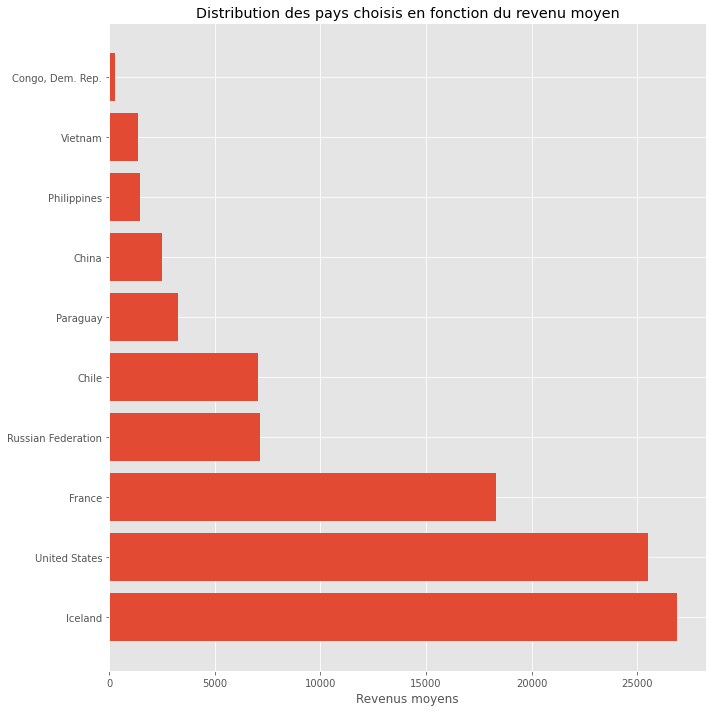

In [86]:
pillars = data_m2[(data_m2['country'] == 'France') |
                  (data_m2['country'] == 'United States') |
                  (data_m2['country'] == 'Russian Federation') |
                  (data_m2['country'] == 'Congo, Dem. Rep.') |
                  (data_m2['country'] == 'Vietnam') |
                  (data_m2['country'] == 'Paraguay') |
                  (data_m2['country'] == 'Chile') |
                  (data_m2['country'] == 'Iceland') |
                  (data_m2['country'] == 'Philippines') |
                  (data_m2['country'] == 'China')].sort_values('income', ascending=False)

# paramètres généraux
plt.figure(figsize=(10,10))

# paramètres graphiques
plt.barh(pillars.country, pillars.income)

# métadonnées
plt.title('Distribution des pays choisis en fonction du revenu moyen')
plt.xlabel('Revenus moyens')
plt.tight_layout() # Permet de ne pas couper les labels

# sauvegarde
# plt.savefig('graph/diag_bat_incm.png')
plt.show()

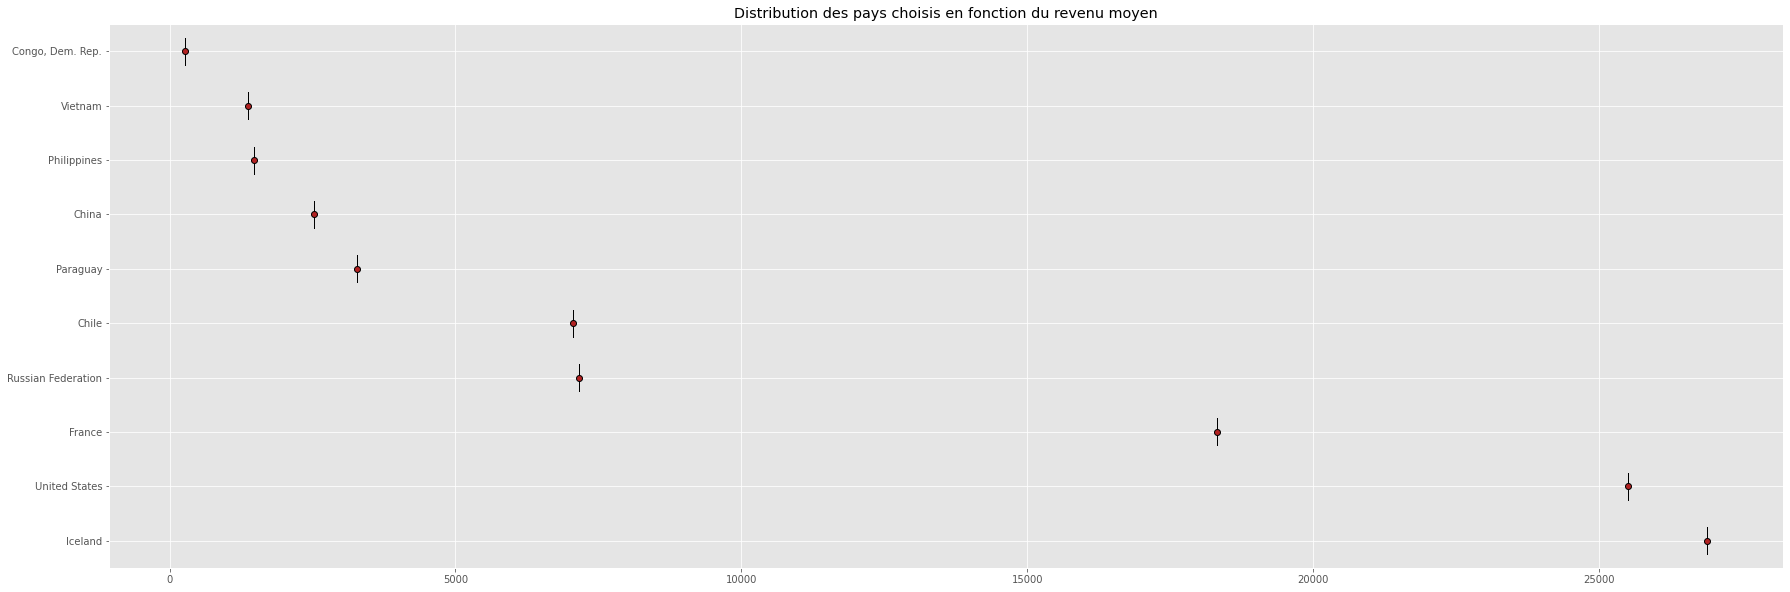

In [87]:
plt.figure(figsize=(30,10))

X = 'country'
Y = 'income'

pillars = data_m2[(data_m2['country'] == 'France') |
                  (data_m2['country'] == 'United States') |
                  (data_m2['country'] == 'Russian Federation') |
                  (data_m2['country'] == 'Congo, Dem. Rep.') |
                  (data_m2['country'] == 'Vietnam') |
                  (data_m2['country'] == 'Paraguay') |
                  (data_m2['country'] == 'Chile') |
                  (data_m2['country'] == 'Iceland') |
                  (data_m2['country'] == 'Philippines') |
                  (data_m2['country'] == 'China')].sort_values('income', ascending=False)

modalites = pillars[X].unique()
groupes = []
for m in modalites:
    groupes.append(pillars[pillars[X]==m][Y])
    
       
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black','markerfacecolor':'firebrick'}

plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops,vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.title('Distribution des pays choisis en fonction du revenu moyen')
plt.show()

#### affichage du graphique

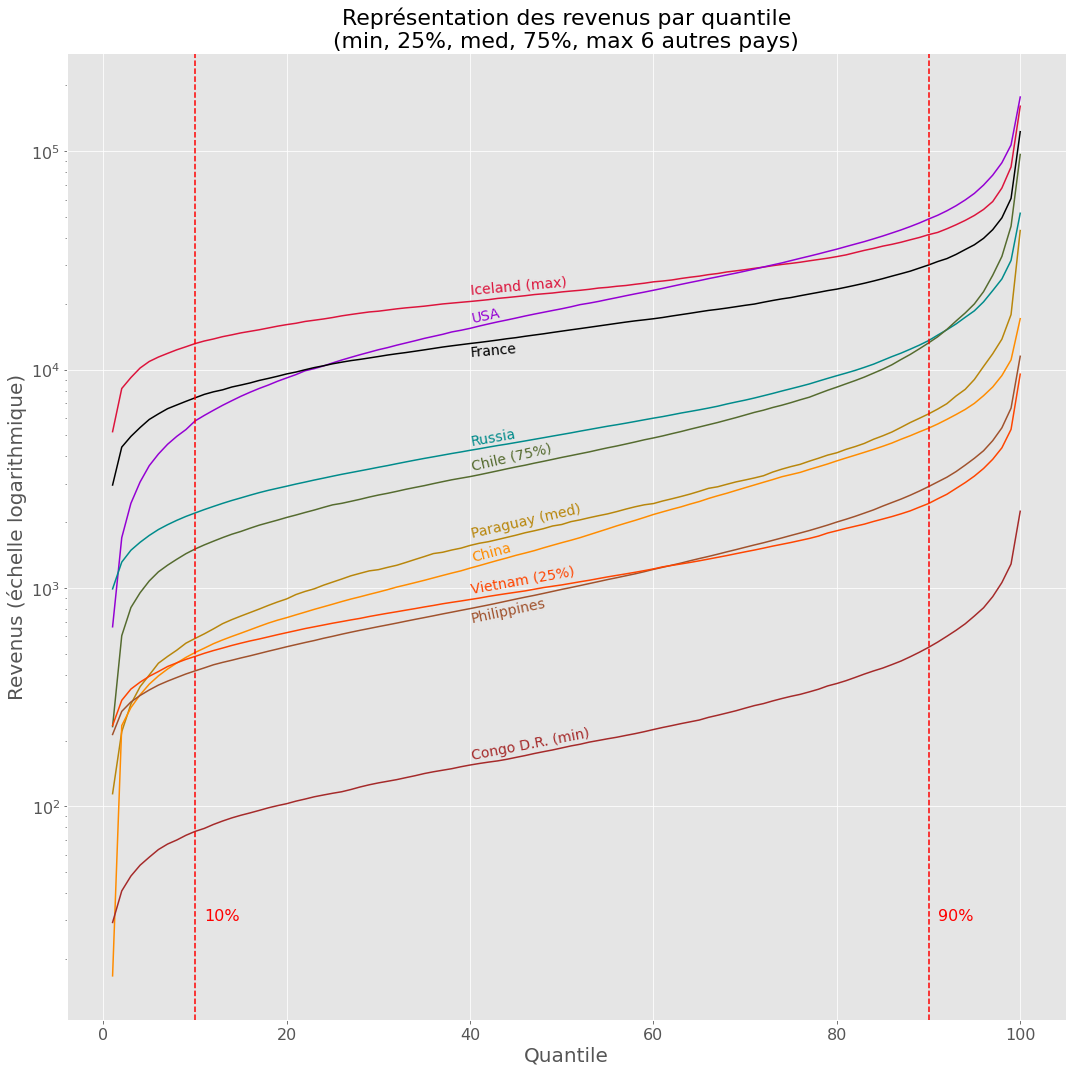

In [88]:
# préparation des données par pays choisis
income_iceland = data[data['country'] == 'Iceland']
income_usa = data[data['country'] == 'United States']
income_france = data[data['country'] == 'France']
income_russia = data[data['country'] == 'Russian Federation']
income_chile = data[data['country'] == 'Chile']
income_paraguay = data[data['country'] == 'Paraguay']
income_china = data[data['country'] == 'China']
income_philippines = data[data['country'] == 'Philippines']
income_vietnam = data[data['country'] == 'Vietnam']
income_congo = data[data['country'] == 'Congo, Dem. Rep.']

# création des labels
label = ['Iceland (max)', 'USA', 'France', 'Russia', 'Chile (75%)', 'Paraguay (med)', 'China', 'Philippines', 'Vietnam (25%)', 'Congo D.R. (min)']

# paramètres généraux
plt.figure(figsize=(15, 15))
plt.yscale('log')

# paramètres des courbes
plt.plot(income_iceland['quantile'], income_iceland['income'], color='crimson')
plt.text(40, 22300 , 'Iceland (max)', fontsize = '14', color='crimson', rotation = 5)

plt.plot(income_usa['quantile'], income_usa['income'], color='darkviolet')
plt.text(40, 16500 , 'USA', fontsize = '14', color='darkviolet', rotation = 12)

plt.plot(income_france['quantile'], income_france['income'], color='black')
plt.text(40, 11500 , 'France', fontsize = '14', color='black', rotation = 5)

plt.plot(income_russia['quantile'], income_russia['income'], color='darkcyan')
plt.text(40, 4500 , 'Russia', fontsize = '14', color='darkcyan', rotation = 10)

plt.plot(income_chile['quantile'], income_chile['income'], color='darkolivegreen')
plt.text(40, 3475 , 'Chile (75%)', fontsize = '14', color='darkolivegreen', rotation = 13)

plt.plot(income_paraguay['quantile'], income_paraguay['income'], color='darkgoldenrod')
plt.text(40, 1700 , 'Paraguay (med)', fontsize = '14', color='darkgoldenrod', rotation = 13)

plt.plot(income_china['quantile'], income_china['income'], color='darkorange')
plt.text(40, 1325 , 'China', fontsize = '14', color='darkorange', rotation = 15)

plt.plot(income_philippines['quantile'], income_philippines['income'], color='sienna')
plt.text(40, 700 , 'Philippines', fontsize = '14', color='sienna', rotation = 12)

plt.plot(income_vietnam['quantile'], income_vietnam['income'], color='orangered')
plt.text(40, 950 , 'Vietnam (25%)', fontsize = '14', color='orangered', rotation = 10)

plt.plot(income_congo['quantile'], income_congo['income'], color='brown')
plt.text(40, 165 , 'Congo D.R. (min)', fontsize = '14', color='brown', rotation = 11)


# paramètre des lignes de référence
plt.axvline(10, linestyle='--', color='r')
plt.text(11, 30, '10%', color='r', fontsize=16)
plt.axvline(90, linestyle='--', color='r')
plt.text(91, 30, '90%', color='r', fontsize=16)

# métadonnées
plt.title('Représentation des revenus par quantile\n(min, 25%, med, 75%, max 6 autres pays)', fontsize=22)
plt.ylabel('Revenus (échelle logarithmique)', fontsize=20)
plt.yticks(fontsize=16)
plt.xlabel('Quantile', fontsize=20)
plt.xticks(fontsize=16)
plt.tight_layout()

# sauvegarde
# plt.savefig('graph/representation_revenus.png')
plt.show()

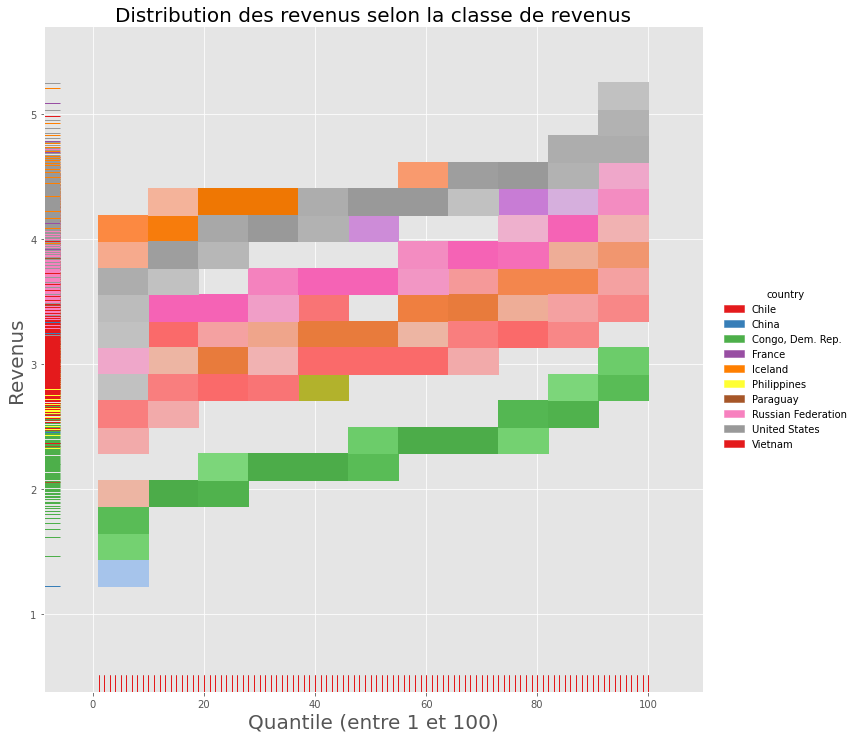

In [89]:
# affichage de la distribution des revenus en fonction de la classe de revenus
# définition des caractéristiques pour les graphiques
pillar = data[data["country"].isin(pillars.country.unique())].sort_values('country_code')

# modification de la classe de 'income'
pillar['income'] = pillar['income'].apply(lambda x: float(x))
pillar['income_log10'] = pillar['income'].apply(lambda x: math.log10(x))

_ = sns.displot(x='quantile', y='income_log10', hue='country', palette='Set1', rug=True, height=10, data=pillar)
_ = plt.title('Distribution des revenus selon la classe de revenus', fontsize=20)
_ = plt.xlabel('Quantile (entre 1 et 100)', fontsize=20)
_ = plt.ylabel('Revenus', fontsize=20)
_ = plt.show()

### représentation de la courbe de Lorenz

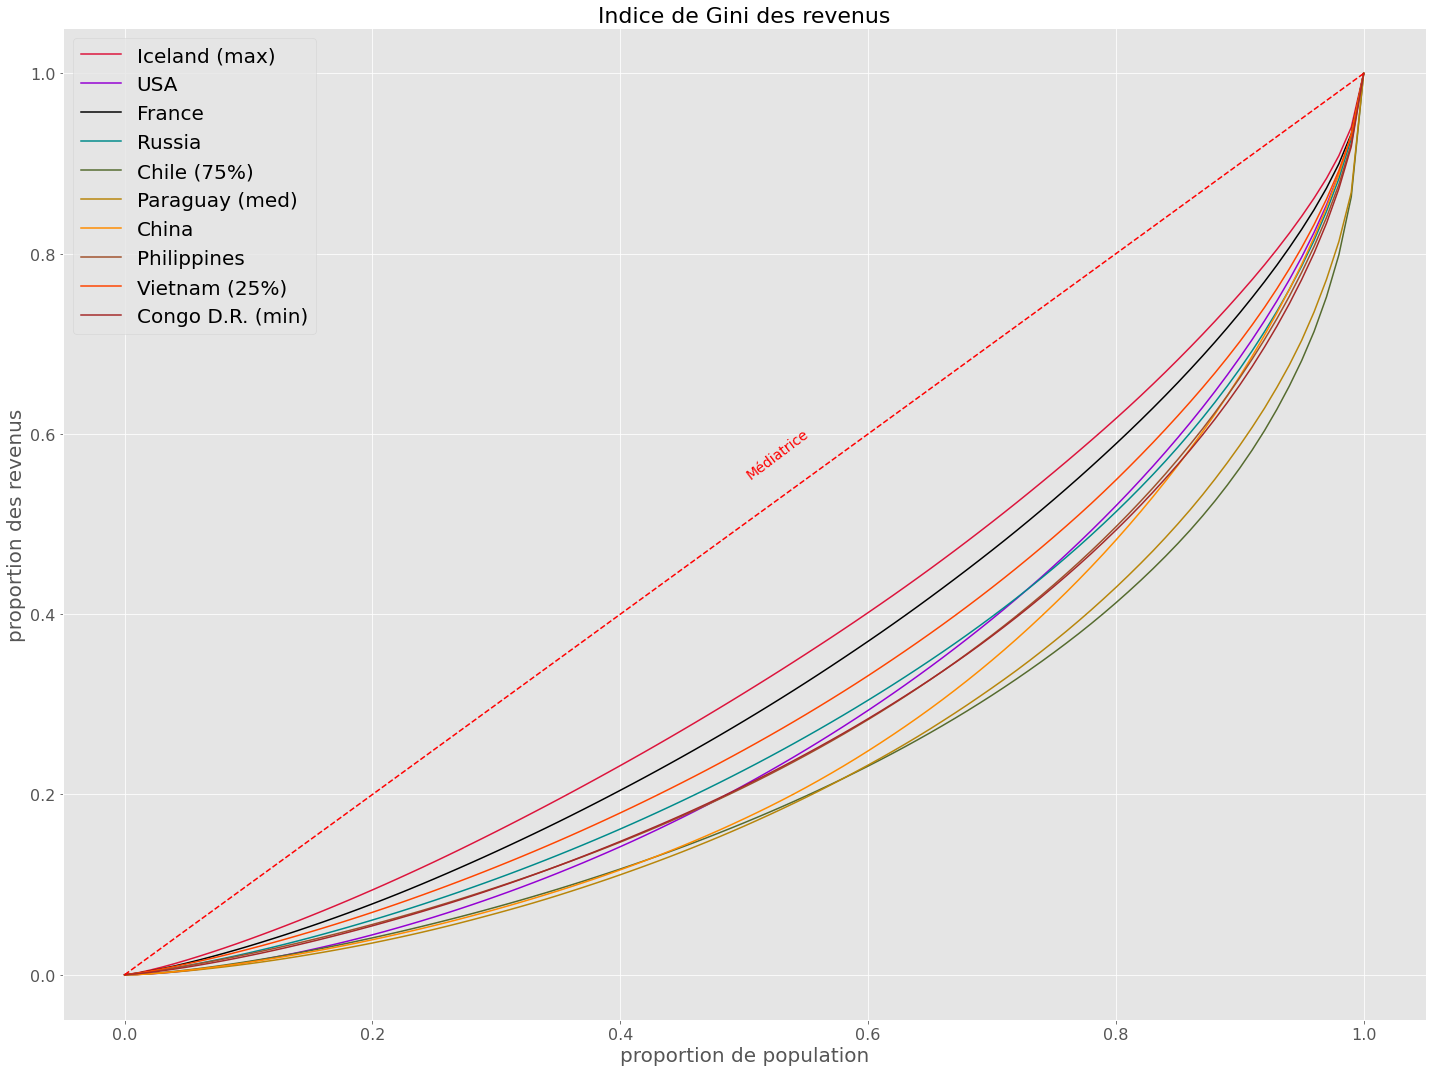

In [90]:
# calculs des données des courbes de Lorenz
iceland = income_iceland['income'].values
l_iceland = np.cumsum(np.sort(iceland)) / iceland.sum()
l_iceland = np.append([0], l_iceland)

usa = income_usa['income'].values
l_usa = np.cumsum(np.sort(usa)) / usa.sum()
l_usa = np.append([0], l_usa)

france = income_france['income'].values
l_france = np.cumsum(np.sort(france)) / france.sum()
l_france = np.append([0], l_france)

russia = income_russia['income'].values
l_russia = np.cumsum(np.sort(russia)) / russia.sum()
l_russia = np.append([0], l_russia)

chile = income_chile['income'].values
l_chile = np.cumsum(np.sort(chile)) / chile.sum()
l_chile = np.append([0], l_chile)

paraguay = income_paraguay['income'].values
l_paraguay = np.cumsum(np.sort(paraguay)) / paraguay.sum()
l_paraguay = np.append([0], l_paraguay)

china = income_china['income'].values
l_china = np.cumsum(np.sort(china)) / china.sum()
l_china = np.append([0], l_china)

philippines = income_philippines['income'].values
l_philippines = np.cumsum(np.sort(philippines)) / philippines.sum()
l_philippines = np.append([0], l_philippines)

vietnam = income_vietnam['income'].values
l_vietnam = np.cumsum(np.sort(vietnam)) / vietnam.sum()
l_vietnam = np.append([0], l_vietnam)

congo = income_congo['income'].values
l_congo = np.cumsum(np.sort(congo)) / congo.sum()
l_congo = np.append([0], l_congo)

# création des labels et listes for le boucel For
label = ['Iceland (max)', 'USA', 'France', 'Russia', 'Chile (75%)', 'Paraguay (med)', 'China', 'Philippines', 'Vietnam (25%)', 'Congo D.R. (min)']
lorenz = [l_iceland, l_usa, l_france, l_russia, l_chile, l_paraguay, l_china, l_philippines, l_vietnam, l_congo]
color = ["crimson", "darkviolet", "black", "darkcyan", "darkolivegreen", "darkgoldenrod", "darkorange", "sienna", "orangered", "brown"]
countries_10 = ["Iceland", "United States", "France", "Russian Federation", "Chile", "Paraguay", "China", "Philippines", "Vietnam", "Congo, Dem. Rep."]
income_10 = ["income_iceland", "income_usa", "income_france", "income_russia", "income_chile", "income_paraguay", "income_china", "income_philippines", "income_vietnam", "income_congo"]

# paramètres généraux
plt.figure(figsize=(20,15))

# paramètres des courbes de Lorenz
for lor, col in zip(lorenz, color):
  plt.plot(np.linspace(0,1,len(lor)),lor, color=col)

# paramètre de la médiatrice
x = [0, 1]
y = [0, 1]
plt.plot(x, y, 'red', linestyle='--', label='Médiatrice')
plt.text(0.5, 0.55, 'Médiatrice', fontsize=14, rotation = 37, color ='red')

# métadonnées
plt.title('Indice de Gini des revenus', fontsize=22)
plt.ylabel('proportion des revenus', fontsize=20)
plt.yticks(fontsize=16)
plt.xlabel('proportion de population', fontsize=20)
plt.xticks(fontsize=16)
plt.legend(label, prop={'size':20})
plt.tight_layout()

# sauvegarde
# plt.savefig('graph/gini_revenus.png')
plt.show()

### évolution des indices de Gini

In [91]:
# affichage du fichier gini
gini.head(3)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Aruba,ABW,Gini index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,Gini index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,AFG,Gini index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [92]:
# mise en forme des données gini
gini.reset_index(inplace=True, drop=True)
gini.rename(columns={'Country Name': 'country', 'Country Code': 'country_code'}, inplace =True)
gini.drop(columns=['country_code',
                   'Indicator Name',
                   'Indicator Code'], inplace = True)
gini = gini.set_index('country')
gini = gini.transform(lambda x: x / 100)
gini.tail()

,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
country,,,,,,,,,,,,,,,,,,,,,
Kosovo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.278,0.29,0.263,0.273,0.265,0.267,0.290,NaN,NaN,NaN
"Yemen, Rep.",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.367,NaN,NaN,NaN,NaN,NaN,NaN
South Africa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.630,NaN,NaN,NaN,NaN,NaN,NaN
Zambia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.571,NaN,NaN,NaN,NaN,NaN
Zimbabwe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.432,NaN,NaN,NaN,NaN,NaN,0.443,NaN,0.503,NaN


In [93]:
# données disponibles pour la Iceland
g_iceland = gini.loc[gini.index == 'Iceland'].iloc[0:].dropna(axis=1)
g_iceland

,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
country,,,,,,,,,,,,,,,
Iceland,0.268,0.28,0.29,0.302,0.295,0.318,0.287,0.262,0.268,0.268,0.254,0.278,0.268,0.272,0.261


In [94]:
# données disponibles pour la United States
g_usa = gini.loc[gini.index == 'United States'].iloc[0:].dropna(axis=1)
g_usa

,1974,1979,1986,1991,1992,1993,1994,1995,1996,1997,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
country,,,,,,,,,,,,,,,,,,,,,
United States,0.353,0.345,0.374,0.38,0.384,0.404,0.4,0.399,0.403,0.405,...,0.406,0.4,0.409,0.409,0.407,0.415,0.412,0.411,0.412,0.414


In [95]:
# données disponibles pour la France
g_france = gini.loc[gini.index == 'France'].iloc[0:].dropna(axis=1)
g_france

,1978,1984,1989,1994,2000,2003,2004,2005,2006,2007,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
country,,,,,,,,,,,,,,,,,,,,,
France,0.352,0.369,0.322,0.323,0.311,0.314,0.306,0.298,0.297,0.324,...,0.327,0.337,0.333,0.331,0.325,0.323,0.327,0.319,0.316,0.324


In [96]:
# données disponibles pour la Russian Federation
g_russia = gini.loc[gini.index == 'Russian Federation'].iloc[0:].dropna(axis=1)
g_russia

,1993,1996,1997,1998,1999,2000,2001,2002,2003,2004,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
country,,,,,,,,,,,,,,,,,,,,,
Russian Federation,0.484,0.461,0.384,0.381,0.374,0.371,0.369,0.373,0.4,0.403,...,0.398,0.395,0.397,0.407,0.409,0.399,0.377,0.368,0.372,0.375


In [97]:
# données disponibles pour la Chile
g_chile = gini.loc[gini.index == 'Chile'].iloc[0:].dropna(axis=1)
g_chile

,1987,1990,1992,1994,1996,1998,2000,2003,2006,2009,2011,2013,2015,2017
country,,,,,,,,,,,,,,
Chile,0.562,0.572,0.548,0.564,0.549,0.555,0.528,0.515,0.473,0.47,0.46,0.458,0.444,0.444


In [98]:
# données disponibles pour la Paraguay
g_paraguay = gini.loc[gini.index == 'Paraguay'].iloc[0:].dropna(axis=1)
g_paraguay

,1990,1995,1997,1999,2001,2002,2003,2004,2005,2006,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
country,,,,,,,,,,,,,,,,,,,,,
Paraguay,0.408,0.582,0.549,0.546,0.546,0.573,0.549,0.523,0.514,0.53,...,0.51,0.523,0.476,0.479,0.507,0.476,0.479,0.485,0.46,0.457


In [99]:
# données disponibles pour la China
g_china = gini.loc[gini.index == 'China'].iloc[0:].dropna(axis=1)
g_china

,1990,1996,1999,2002,2005,2008,2010,2011,2012,2013,2014,2015,2016
country,,,,,,,,,,,,,
China,0.322,0.352,0.387,0.42,0.409,0.43,0.437,0.424,0.422,0.397,0.392,0.386,0.385


In [100]:
# données disponibles pour la Philippines
g_philippines = gini.loc[gini.index == 'Philippines'].iloc[0:].dropna(axis=1)
g_philippines

,2000,2003,2006,2009,2012,2015,2018
country,,,,,,,
Philippines,0.477,0.466,0.472,0.463,0.465,0.446,0.423


In [101]:
# données disponibles pour la Vietnam
g_vietnam = gini.loc[gini.index == 'Vietnam'].iloc[0:].dropna(axis=1)
g_vietnam

,1992,1997,2002,2004,2006,2008,2010,2012,2014,2016,2018
country,,,,,,,,,,,
Vietnam,0.357,0.354,0.37,0.368,0.358,0.356,0.393,0.356,0.348,0.353,0.357


In [102]:
# données disponibles pour la Congo, Dem. Rep.
g_congo = gini.loc[gini.index == 'Congo, Dem. Rep.'].iloc[0:].dropna(axis=1)
g_congo

,2004,2012
country,,
"Congo, Dem. Rep.",0.422,0.421


In [103]:
# données disponibles pour la Congo, Rep.
g_congo_ = gini.loc[gini.index == 'Congo, Rep.'].iloc[0:].dropna(axis=1)
g_congo_

,2005,2011
country,,
"Congo, Rep.",0.473,0.489


In [104]:
# restriction des données sur les pays concernés
gini_10 = gini.loc[(gini.index == 'Iceland') |
                   (gini.index == 'United States') |
                   (gini.index == 'France') |
                   (gini.index == 'Russian Federation') |
                   (gini.index == 'Chile' ) |
                   (gini.index == 'Paraguay') |
                   (gini.index == 'China' ) |
                   (gini.index == 'Philippines') |
                   (gini.index == 'Vietnam') |
                   (gini.index == 'Congo, Dem. Rep.')].T


# Nommage de l'index
gini_10.index.name = 'year'

In [105]:
# max year
gini_10.tail(1)

country,Chile,China,"Congo, Dem. Rep.",France,Iceland,Philippines,Paraguay,Russian Federation,United States,Vietnam
year,,,,,,,,,,
2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [106]:
# min year
gini_10.head(1)

country,Chile,China,"Congo, Dem. Rep.",France,Iceland,Philippines,Paraguay,Russian Federation,United States,Vietnam
year,,,,,,,,,,
1960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


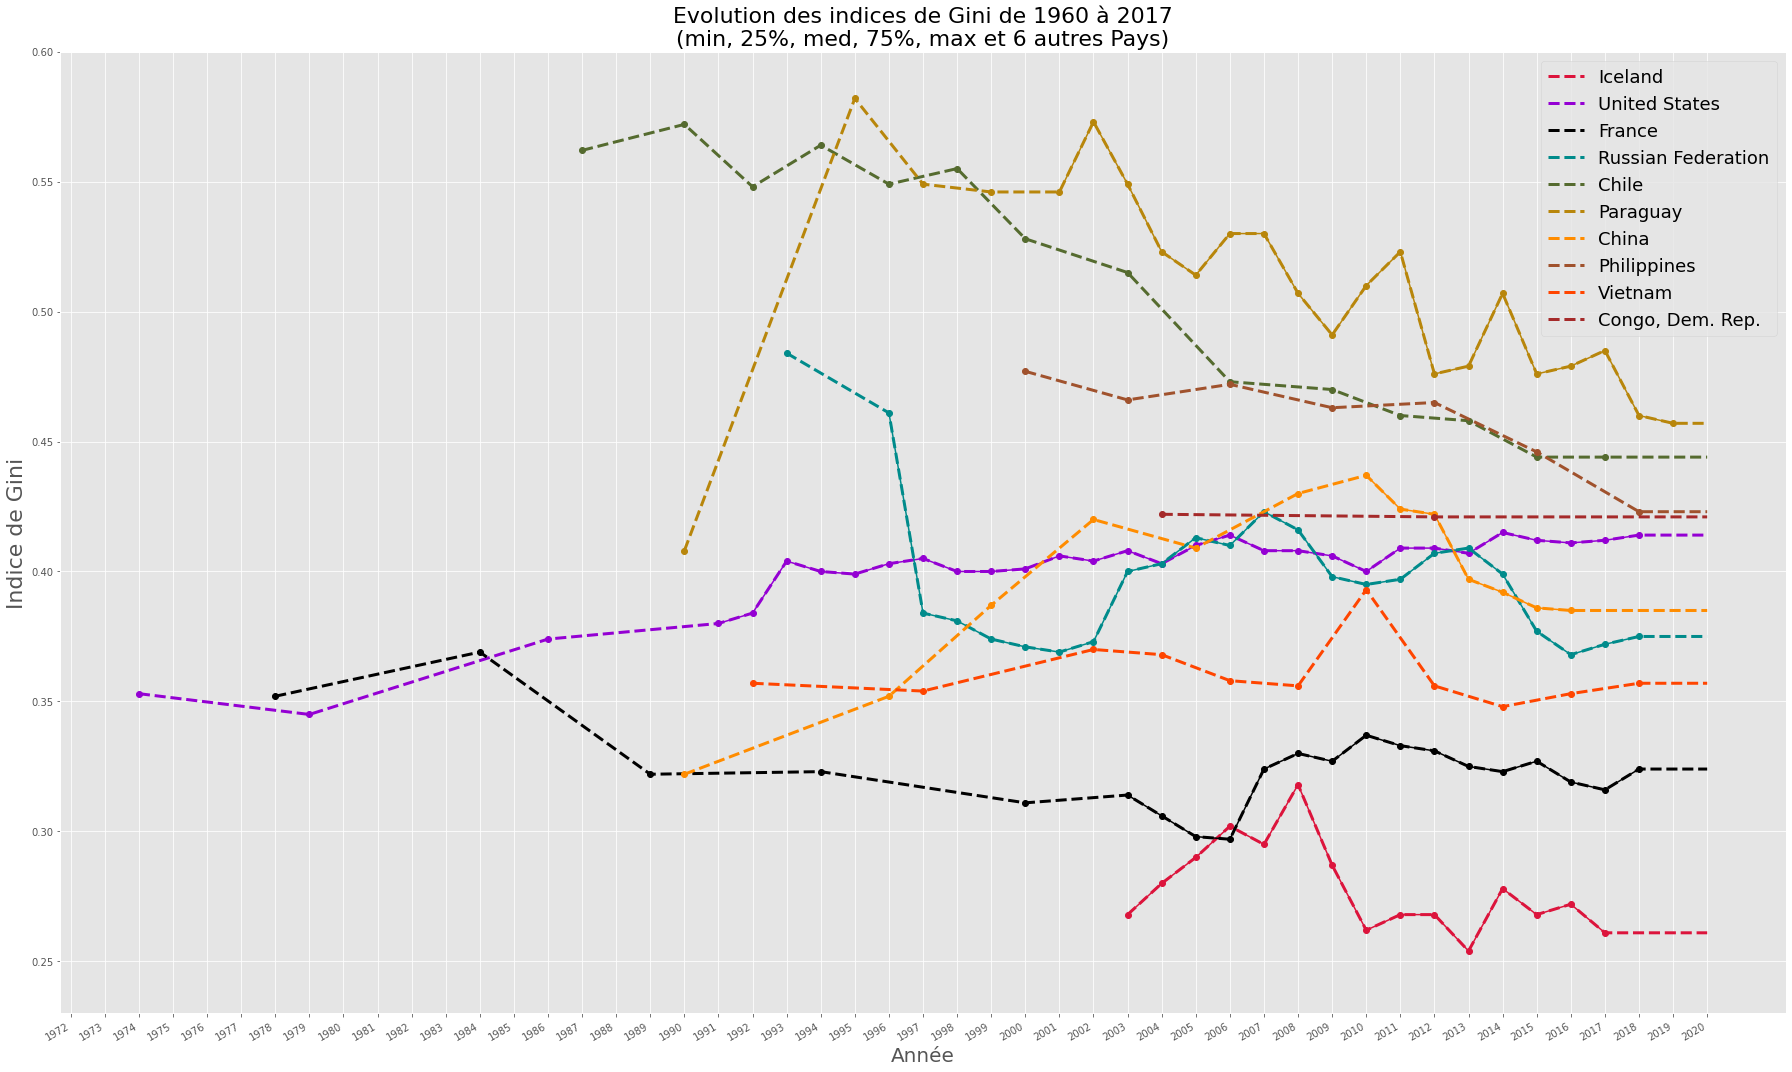

In [107]:
# paramètre généraux
fig, ax = plt.subplots(figsize=(25,15))

# paramètres des courbes
for place, col in zip(countries_10, color):
  line, = ax.plot(gini_10[place].interpolate(method='linear'),
                  ls = '--', lw = 3, color=col, label=place)
  ax.plot(gini_10[place], color=line.get_color(), lw=1.5, marker = 'o')
  
# métadonnées
plt.title('Evolution des indices de Gini de 1960 à 2017\n(min, 25%, med, 75%, max et 6 autres Pays)', fontsize=22)
plt.xlabel('Année', fontsize=20)
plt.xticks(rotation=30, horizontalalignment='right')
plt.ylabel('Indice de Gini', fontsize = 22)
plt.ylim(0.23,0.6)
plt.legend(fontsize=18)
plt.tight_layout()

# sauvegarde
# plt.savefig('graph/evolution_gini.png')
plt.show()

### classement des pays par indice de Gini

1. calcul de l'indice de Gini
2. résultat du classement

#### calcul de l'indice de Gini

In [108]:
# liste des pays
key = data["country"].unique()
# key = data['Pays'].drop_duplicates().values

# création colonne vide
data['gini'] = 0

# calcul de l'indice de Gini pour chaque pays et remplissage de la colonne Gini
for i in key:
    income_values = data.loc[data['country'] == i].income.values
    lorenz = np.cumsum(np.sort(income_values)) / income_values.sum()
    lorenz = np.append([0], lorenz)
    data.loc[data['country'] == i, 'gini'] = 2 * (0.5 - (lorenz[:-1].sum() / len(lorenz)))

data.head()

,country_code,country,population,quantile,income,gdpppp,gini
0,ALB,Albania,2947314.0,1,728.89795,7297.0,0.32141
1,ALB,Albania,2947314.0,2,916.66235,7297.0,0.32141
2,ALB,Albania,2947314.0,3,1010.91600,7297.0,0.32141
3,ALB,Albania,2947314.0,4,1086.90780,7297.0,0.32141
4,ALB,Albania,2947314.0,5,1132.69970,7297.0,0.32141


In [109]:
# sélection des pays suivis
compare_gini = data[data['country'].isin(countries_10)].groupby("country").mean()
compare_gini

,population,quantile,income,gdpppp,gini
country,,,,,
Chile,1.670826e+07,50.5,7051.609966,13390.00000,0.546115
China,1.324655e+09,50.5,2522.758726,5712.00000,0.493332
"Congo, Dem. Rep.",6.041120e+07,50.5,276.016044,303.19305,0.459403
France,6.437498e+07,50.5,18309.407545,30357.00000,0.345640
Iceland,3.174140e+05,50.5,26888.511518,36527.00000,0.302046
Paraguay,6.081296e+06,50.5,3278.080965,4347.00000,0.539729
Philippines,9.090197e+07,50.5,1474.062856,3240.00000,0.456185
Russian Federation,1.427424e+08,50.5,7156.770709,14766.00000,0.432367
United States,3.040940e+08,50.5,25503.581661,43261.00000,0.447326


In [110]:
# # ajout des coefficients téléchargés sur le site de la banque mondiale
# compare_gini['gini_2008'] = gini[(gini.index == 'Iceland') |
#                                  (gini.index == 'United States') |
#                                  (gini.index == 'France') |
#                                  (gini.index == 'Russian Federation') |
#                                  (gini.index == 'Chile') |
#                                  (gini.index == 'Paraguay') |
#                                  (gini.index == 'China') |
#                                  (gini.index == 'Philippines') |
#                                  (gini.index == 'Vietnam') |
#                                  (gini.index == 'Congo, Dem. Rep.')]['2008'].values

# # la valeur de 2009 est choisie pour le Chili et les Philippines
# # compare_gini.loc[compare_gini.index == 'Chile', 'gini_2008'] = gini[gini.index == 'Chile']['2009'].values
# # compare_gini.loc[compare_gini.index == 'Philippines', 'gini_2008'] = gini[gini.index == 'Philippines']['2009'].values

# compare_gini['difference_gini'] = compare_gini['gini'] - compare_gini['gini_2008']
# compare_gini

#### résultat du classement

In [111]:
# classement selon l'indice de Gini
gini_mean = data.groupby("country").mean()

gini_ranking = gini_mean.sort_values(by='gini', ascending=False)
gini_ranking.reset_index(inplace=True)
gini_ranking

,country,population,quantile,income,gdpppp,gini
0,South Africa,49779472.0,50.5,5617.904880,9602.0,0.682949
1,Honduras,7980955.0,50.5,3296.268419,3628.0,0.615512
2,Colombia,44254972.0,50.5,3547.005276,8185.0,0.583437
3,Guatemala,13739299.0,50.5,2142.474753,4367.0,0.582468
4,Central African Republic,4273368.0,50.5,811.299901,685.0,0.575972
...,...,...,...,...,...,...
111,Ukraine,46258189.0,50.5,3349.388306,6721.0,0.272415
112,Sweden,9219637.0,50.5,16184.222707,34371.0,0.272166
113,Czech Republic,10384603.0,50.5,8235.293411,23223.0,0.270162
114,Slovak Republic,5379233.0,50.5,6096.579894,20515.0,0.264573


In [112]:
gini_ranking["gini_rank"] = gini_ranking["gini"].rank(ascending=0)
gini_ranking

,country,population,quantile,income,gdpppp,gini,gini_rank
0,South Africa,49779472.0,50.5,5617.904880,9602.0,0.682949,1.0
1,Honduras,7980955.0,50.5,3296.268419,3628.0,0.615512,2.0
2,Colombia,44254972.0,50.5,3547.005276,8185.0,0.583437,3.0
3,Guatemala,13739299.0,50.5,2142.474753,4367.0,0.582468,4.0
4,Central African Republic,4273368.0,50.5,811.299901,685.0,0.575972,5.0
...,...,...,...,...,...,...,...
111,Ukraine,46258189.0,50.5,3349.388306,6721.0,0.272415,112.0
112,Sweden,9219637.0,50.5,16184.222707,34371.0,0.272166,113.0
113,Czech Republic,10384603.0,50.5,8235.293411,23223.0,0.270162,114.0
114,Slovak Republic,5379233.0,50.5,6096.579894,20515.0,0.264573,115.0


In [113]:
# sélection des pays suivis
compare_gini_rank = gini_ranking[gini_ranking['country'].isin(countries_10)].groupby("country")[["gini", "gini_rank"]].mean().sort_values(by="gini_rank", ascending=False)
compare_gini_rank

,gini,gini_rank
country,,
Iceland,0.302046,100.0
France,0.345640,77.0
Vietnam,0.393546,50.0
Russian Federation,0.432367,37.0
United States,0.447326,32.0
Philippines,0.456185,28.0
"Congo, Dem. Rep.",0.459403,27.0
China,0.493332,17.0
Paraguay,0.539729,10.0


In [114]:
# les 5 pays avec le plus haut indice de Gini
gini_top5 = gini_ranking.head()
gini_top5

,country,population,quantile,income,gdpppp,gini,gini_rank
0,South Africa,49779472.0,50.5,5617.904880,9602.0,0.682949,1.0
1,Honduras,7980955.0,50.5,3296.268419,3628.0,0.615512,2.0
2,Colombia,44254972.0,50.5,3547.005276,8185.0,0.583437,3.0
3,Guatemala,13739299.0,50.5,2142.474753,4367.0,0.582468,4.0
4,Central African Republic,4273368.0,50.5,811.299901,685.0,0.575972,5.0


In [115]:
# moyenne de l'indice de Gini des 5 plus forts indices
round(gini_top5['gini'].mean()*100, 2) 

60.81

In [116]:
# les 5 pays avec le plus faible indice de Gini
gini_least5 = gini_ranking.tail()
gini_least5

,country,population,quantile,income,gdpppp,gini,gini_rank
111,Ukraine,46258189.0,50.5,3349.388306,6721.0,0.272415,112.0
112,Sweden,9219637.0,50.5,16184.222707,34371.0,0.272166,113.0
113,Czech Republic,10384603.0,50.5,8235.293411,23223.0,0.270162,114.0
114,Slovak Republic,5379233.0,50.5,6096.579894,20515.0,0.264573,115.0
115,Slovenia,2021316.0,50.5,12106.007475,27197.0,0.248249,116.0


In [117]:
# moyenne de l'indice de Gini des 5 plus faible indices
round(gini_least5['gini'].mean()*100, 2) 

26.55

In [118]:
# position de la France (77 ème)
gini_ranking.loc[gini_ranking['country'] == 'France']

,country,population,quantile,income,gdpppp,gini,gini_rank
76,France,64374979.0,50.5,18309.407545,30357.0,0.34564,77.0


In [119]:
# recherche des codes pays communs aux deux fichiers
print(f"nb de pays dans data : {data.country.nunique()}")
print(f"nb de pays dans gini_ranking : {gini_ranking.country.nunique()}")
gini_ranking_country = gini_ranking.country.unique()
data_country = data.country.unique()
gini_data_common_country = np.intersect1d(data_country, gini_ranking_country)
print(f"common_countries : {len(gini_data_common_country)}")

nb de pays dans data : 116
nb de pays dans gini_ranking : 116
common_countries : 116


In [120]:
gini_ranking = gini_ranking[["country", "gini_rank"]]
data = pd.merge(data, gini_ranking, on="country", how="left")
print(data.shape)
data.head(3)

(11600, 8)


,country_code,country,population,quantile,income,gdpppp,gini,gini_rank
0,ALB,Albania,2947314.0,1,728.89795,7297.0,0.32141,91.0
1,ALB,Albania,2947314.0,2,916.66235,7297.0,0.32141,91.0
2,ALB,Albania,2947314.0,3,1010.91600,7297.0,0.32141,91.0


## Mission 3

Dans l'état actuel, nous avons à disposition deux des trois variables explicatives souhaitées :

- ***mj*** = le revenu moyen du pays ***j*** : (`data_m2`)
- ***Gj*** = l'indice de Gini du pays ***j*** : (`data`)

Il nous manque donc, pour un individu ***i***, la classe de revenu ***ci,`parents`*** de ses parents.

### ajout du coefficient d'élasticité ***pj***


In [121]:
# affichage du fichier coefficient d'élasticité donnés par la Banque mondiale
coef.head(3)

,countryname,wbcode,iso3,region,incgroup2,incgroup4,fragile,survey,year,status,...,Cores2125_MAcatC1,Shortfall0611_obs,Shortfall0611_IGP,Shortfall1217_obs,Shortfall1217_IGP,IGEincome,S1,S2,S3,MLD_psu
0,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,NaN,25103.0,0.086197,18054.0,0.345224,NaN,NaN,NaN,NaN,0.1
1,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,NaN,12107.0,0.083271,8538.0,0.389952,NaN,NaN,NaN,NaN,0.1
2,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,NaN,12996.0,0.089161,9516.0,0.307687,NaN,NaN,NaN,NaN,0.1


In [122]:
# affichage de toutes les colonnes, leurs valeurs unique et le nombre de valeurs uniques
# for col in coef:
#   values = coef[col].unique()
#   print(f"\nCOLUMN = {str(col)}\n\nNb of unique values : {len(values)}\n\n{values}\n{'-'*75}")

In [123]:
# renommer quelques colonnes pour faciliter l'analyse
coef.rename(columns= {"wbcode": "country_code",
                      "countryname": "country",
                      "IGEincome": "ige_income",
                      "incgroup4": "income_group",
                      "incgroup2": "economic_status"}, inplace=True)

# création d'une colonne nommé income_region regroupant l'appelation region et income_group
coef['income_region'] = coef[['region', 'income_group']].apply(lambda x: ', '.join(x), axis=1)

# projection sur les colonnes utiles
gdim = coef[['country', 'country_code', 'region', 'income_group', 'year', 'ige_income', 'income_region', 'economic_status']].copy()

# affichage du dataset
gdim.head(3)

,country,country_code,region,income_group,year,ige_income,income_region,economic_status
0,Afghanistan,AFG,South Asia,Low income,1980,NaN,"South Asia, Low income",Developing economies
1,Afghanistan,AFG,South Asia,Low income,1980,NaN,"South Asia, Low income",Developing economies
2,Afghanistan,AFG,South Asia,Low income,1980,NaN,"South Asia, Low income",Developing economies


In [124]:
# calcul des ige_income moyen par région et income_group
ige_mean = gdim.groupby(['region', 'income_group', 'income_region']).mean()[['ige_income']]
ige_mean.reset_index(inplace=True)
ige_mean.set_index('income_region', inplace=True)
ige_mean

,region,income_group,ige_income
income_region,,,
"East Asia & Pacific, Lower middle income",East Asia & Pacific,Lower middle income,0.527665
"East Asia & Pacific, Upper middle income",East Asia & Pacific,Upper middle income,0.469500
"Europe & Central Asia, Lower middle income",Europe & Central Asia,Lower middle income,0.424817
"Europe & Central Asia, Upper middle income",Europe & Central Asia,Upper middle income,0.477171
"High income, High income",High income,High income,0.348050
"Latin America & Caribbean, Lower middle income",Latin America & Caribbean,Lower middle income,0.940737
"Latin America & Caribbean, Upper middle income",Latin America & Caribbean,Upper middle income,0.878852
"Middle East & North Africa, Lower middle income",Middle East & North Africa,Lower middle income,0.916461
"Middle East & North Africa, Upper middle income",Middle East & North Africa,Upper middle income,0.517397


In [125]:
# read text file into pandas DataFrame
elasticity = open("/content/drive/MyDrive/OC/P7/P7_datasets/elasticity.txt", "r")
print(elasticity.read())

Coefficients of intergenerational elasticity between parents’ and
children’s income


                          | Base case  | Optimistic     | Pessimistic
                          |            | (high mobility)| (low mobility)
---------------------------------------------------------------------------
Nordic European countries |    0.2     |      0.15      |    0.3
and Canada                |            |                |
---------------------------------------------------------------------------
Europe (except nordic     |    0.4     |      0.3       |    0.5
countries)                |            |                |
---------------------------------------------------------------------------
Australia/New Zealand/USA |    0.4     |      0.3       |    0.5
---------------------------------------------------------------------------
Asia                      |    0.5     |      0.4       |    0.6
---------------------------------------------------------------------------
Latin America/A

In [126]:
# affectation de la valeur moyenne du fichier elasticity.txt pour la zone Asia [Base Case]
gdim.loc[(gdim['region'] == 'South Asia') & (gdim['income_group'] == 'Upper middle income'), 'ige_income'] = 0.5

In [127]:
# vérification des années existantes pour l'ige_income
ige_years = gdim.groupby('year').nunique()
ige_years

,country,country_code,region,income_group,ige_income,income_region,economic_status
year,,,,,,,
1940,107,107,7,4,0,14,2
1950,110,110,7,4,0,14,2
1960,114,114,7,4,38,14,2
1970,111,111,7,4,36,14,2
1980,147,147,7,4,2,15,2


In [128]:
# création d'un dataframe avec les 'ige_income' en colonnes
gdim_T = pd.pivot_table(gdim, values='ige_income', index={'country'}, columns='year', dropna=False)
gdim_T.reset_index(inplace=True)
gdim_T.rename_axis(None, axis=1, inplace=True)
# gdim_T.set_index('country', inplace=True)

gdim_T.head(3)

,country,1940,1950,1960,1970,1980
0,Afghanistan,NaN,NaN,NaN,NaN,NaN
1,Albania,NaN,NaN,NaN,0.815874,NaN
2,Angola,NaN,NaN,NaN,NaN,NaN


In [129]:
# jointure et mise en forme du dataframe  
gdim_merged = pd.merge(gdim, gdim_T, on='country')
gdim_merged.drop(columns=['year', 'ige_income'], inplace=True)
# gdim_merged.set_index('country', inplace=True)

gdim_merged.head(3)

,country,country_code,region,income_group,income_region,economic_status,1940,1950,1960,1970,1980
0,Afghanistan,AFG,South Asia,Low income,"South Asia, Low income",Developing economies,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,South Asia,Low income,"South Asia, Low income",Developing economies,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,AFG,South Asia,Low income,"South Asia, Low income",Developing economies,NaN,NaN,NaN,NaN,NaN


In [130]:
# vérification des valeurs nulles
gdim_merged.isnull().sum()

country               0
country_code          0
region                0
income_group          0
income_region         0
economic_status       0
1940               6504
1950               6504
1960               4420
1970               4442
1980               6432
dtype: int64

In [131]:
# vérification de l'existence d'un seul coefficient d'elasticité par pays
by_country = gdim_merged.groupby(by='country').nunique()
by_country['year_count'] = by_country[1940] + by_country[1950] + by_country[1960] + by_country[1970] + by_country[1980]
by_country.loc[by_country['year_count'] > 1]

,country_code,region,income_group,income_region,economic_status,1940,1950,1960,1970,1980,year_count
country,,,,,,,,,,,


In [132]:
# pays sans coefficient d'élasticité
no_coef = by_country.loc[by_country['year_count'] == 0]
print(f"Nb de pays sans coefficient d'élasticité : {len(no_coef)}\n")
no_coef.index.unique()

Nb de pays sans coefficient d'élasticité : 74



Index(['Afghanistan', 'Angola', 'Argentina', 'Armenia', 'Azerbaijan', 'Bhutan',
       'Botswana', 'Bulgaria', 'Burkina Faso', 'Cabo Verde', 'Cambodia',
       'Cameroon', 'Central African Republic', 'Chad', 'Comoros',
       'Congo, Rep.', 'Costa Rica', 'Cote d'Ivoire', 'Djibouti',
       'Dominican Republic', 'El Salvador', 'Estonia', 'Fiji', 'Gabon',
       'Georgia', 'Guinea-Bissau', 'Honduras', 'Hungary', 'Iceland',
       'Indonesia', 'Iran, Islamic Rep.', 'Iraq', 'Israel', 'Kiribati',
       'Kosovo', 'Lao PDR', 'Lebanon', 'Lesotho', 'Liberia', 'Lithuania',
       'Mauritania', 'Mauritius', 'Mexico', 'Moldova', 'Montenegro',
       'Mozambique', 'Namibia', 'Nicaragua', 'Niger', 'Papua New Guinea',
       'Paraguay', 'Philippines', 'Poland', 'Sao Tome and Principe', 'Senegal',
       'Serbia', 'Sierra Leone', 'South Sudan', 'Sri Lanka', 'Sudan',
       'Swaziland', 'Tajikistan', 'Thailand', 'Togo', 'Tonga', 'Turkey',
       'Tuvalu', 'Ukraine', 'Uruguay', 'Vanuatu', 'Venezuela, R

In [133]:
# aggrégation par pays selon la moyenne
gdim_mean = gdim_merged.groupby(['country', 'country_code', 'region', 'income_group', 'income_region']).mean()
gdim_mean.reset_index(inplace=True)
gdim_mean.set_index('country', inplace = True)

# remplacement des 'NaN' par une string 'absent'
gdim_mean.fillna('absent', inplace=True)

gdim_mean.head(3)

,country_code,region,income_group,income_region,1940,1950,1960,1970,1980
country,,,,,,,,,
Afghanistan,AFG,South Asia,Low income,"South Asia, Low income",absent,absent,absent,absent,absent
Albania,ALB,Europe & Central Asia,Upper middle income,"Europe & Central Asia, Upper middle income",absent,absent,absent,0.815874,absent
Angola,AGO,Sub-Saharan Africa,Upper middle income,"Sub-Saharan Africa, Upper middle income",absent,absent,absent,absent,absent


In [134]:
# création d'une clef pour itérer
key = gdim_mean.index
key

Index(['Afghanistan', 'Albania', 'Angola', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bangladesh', 'Belarus',
       ...
       'United Kingdom', 'United States', 'Uruguay', 'Uzbekistan', 'Vanuatu',
       'Venezuela, RB', 'Vietnam', 'West Bank and Gaza', 'Yemen, Rep.',
       'Zambia'],
      dtype='object', name='country', length=150)

In [135]:
for i in key:
    if gdim_mean.loc[i, 1980] != 'absent':
        gdim_mean.loc[i, [1940, 1950, 1960, 1970]] = gdim_mean.loc[i, 1980] # Si il existe une valeur en 1980
                                                                    #elle est propagée
    elif gdim_mean.loc[i, 1970] != 'absent':
        gdim_mean.loc[i, [1940, 1950, 1960, 1980]] = gdim_mean.loc[i, 1970] # Sinon, si il existe une valeur en 1970
                                                                    # Elle est propagée
    
    elif gdim_mean.loc[i, 1960] != 'absent':
        gdim_mean.loc[i, [1940, 1950, 1970, 1980]] = gdim_mean.loc[i, 1960] # Sinon, si il existe une valeur en 1960
                                                                    #elle est propagée
    
    elif [(gdim_mean.loc[i, 1980] == 'absent') & (gdim_mean.loc[i, 1970] == 'absent') & (gdim_mean.loc[i, 1960] == 'absent') & (gdim_mean.loc[i, 1950] == 'absent') & (gdim_mean.loc[i, 1940] == 'absent')]:
            k = gdim_mean.loc[i, 'income_region']
            gdim_mean.loc[i, [1940, 1950, 1950, 1960, 1970, 1980]] = ige_mean.loc[k, 'ige_income']

In [136]:
gdim_mean.isnull().sum()

country_code     0
region           0
income_group     0
income_region    0
1940             0
1950             0
1950             0
1960             0
1970             0
1980             0
dtype: int64

In [137]:
gdim_mean.dtypes

country_code     object
region           object
income_group     object
income_region    object
1940             object
1950             object
1950             object
1960             object
1970             object
1980             object
dtype: object

In [138]:
# assignation du type float pour les colonnes contenant les ige_income
convert_columntype = {1940: float,
                      1950: float,
                      1960: float,
                      1970: float,
                      1980: float}
  
gdim_mean = gdim_mean.astype(convert_columntype)
gdim_mean.dtypes

country_code      object
region            object
income_group      object
income_region     object
1940             float64
1950             float64
1950             float64
1960             float64
1970             float64
1980             float64
dtype: object

In [139]:
gdim_mean.reset_index(inplace=True)
gdim_mean.head(3)

,country,country_code,region,income_group,income_region,1940,1950,1950,1960,1970,1980
0,Afghanistan,AFG,South Asia,Low income,"South Asia, Low income",0.436000,0.436000,0.436000,0.436000,0.436000,0.436000
1,Albania,ALB,Europe & Central Asia,Upper middle income,"Europe & Central Asia, Upper middle income",0.815874,0.815874,0.815874,0.815874,0.815874,0.815874
2,Angola,AGO,Sub-Saharan Africa,Upper middle income,"Sub-Saharan Africa, Upper middle income",0.677000,0.677000,0.677000,0.677000,0.677000,0.677000


In [140]:
# mise en forme du dataframe
gdim_coef = gdim_mean.drop(columns=[1940,1950,1960,1970]).rename(columns={1980: 'e_coef'})
gdim_coef.reset_index(inplace=True, drop=True)
gdim_coef.head(3)

,country,country_code,region,income_group,income_region,e_coef
0,Afghanistan,AFG,South Asia,Low income,"South Asia, Low income",0.436000
1,Albania,ALB,Europe & Central Asia,Upper middle income,"Europe & Central Asia, Upper middle income",0.815874
2,Angola,AGO,Sub-Saharan Africa,Upper middle income,"Sub-Saharan Africa, Upper middle income",0.677000


In [141]:
# vérification des valeurs moyennes par région et niveau de revenus
gdim_coef.groupby('income_region').mean()

,e_coef
income_region,
"East Asia & Pacific, Lower middle income",0.527665
"East Asia & Pacific, Upper middle income",0.469500
"Europe & Central Asia, Lower middle income",0.424817
"Europe & Central Asia, Upper middle income",0.477171
"High income, High income",0.346502
"Latin America & Caribbean, Lower middle income",0.940737
"Latin America & Caribbean, Upper middle income",0.878852
"Middle East & North Africa, Lower middle income",0.916461
"Middle East & North Africa, Upper middle income",0.517397


In [142]:
# recherche des codes pays communs aux deux fichiers
gdim_coef_country = gdim_coef.country_code.unique()
data_country = data.country_code.unique()
gdim_data_common_country = np.intersect1d(data_country, gdim_coef_country)
print(f"common_countries :{len(gdim_data_common_country)}")

# autre method 1
print(f"method 1 : {len(set(gdim_coef_country) & set(data_country))}")

# autre method 2
print(f"method 2 : {len(set(gdim_coef_country).intersection(data_country))}")

# autre method 3
# df3 = gdim_coef[gdim_coef["country_code"].isin(data["country_code"]) == False]
# print(f"countries from gdim_coef not in data : {len(df3)}")

print(f"nb of countries in gdim_coef_country : {len(gdim_coef_country)}")
print(f"nb of countries in data_country : {len(data_country)}")

print(f"Difference = {len(gdim_coef_country) - len(data_country)}")

# tip
# df1 = gdim_coef["country_code"]
# df2 = data["country_code"]
# df_diff = pd.concat([df1,df2]).drop_duplicates(keep=False)
# len(df_diff)

common_countries :110
method 1 : 110
method 2 : 110
nb of countries in gdim_coef_country : 150
nb of countries in data_country : 116
Difference = 34


In [143]:
def check_values(df, listOfValues):
    ''' Check if given elements exists in dictionary or not.
        It returns a dictionary of elements as key and thier existence value as bool'''
    resultDict = {}
    # iterate over the list of elements one by one
    for elem in listOfValues:
        # check if the element exists in dataframe values
        if elem in df.country_code.values:
            resultDict[elem] = True
        else:
            resultDict[elem] = False
    # returns a dictionary of values & thier existence flag        
    return resultDict

# check if given values exists in the DataFrame or not
result = check_values(data, gdim_coef_country)
print('Dictionary representing if the given keys exists in DataFrame or not : ')
# result

Dictionary representing if the given keys exists in DataFrame or not : 


In [144]:
# jointure de data et gdim_coef
gdim_data = pd.merge(data, gdim_coef, how='left', on=['country_code', 'country'] )

# selection (suppression) des colonnes (in)utiles
# gdim_data.drop(columns=['country'], inplace=True)
# gdim_data = gdim_data[["country",	"country_code", "region",	"population", "income_group", "income", "gdpppp",	"gini", "e_coef", "income_region"]]
gdim_data.head()

,country_code,country,population,quantile,income,gdpppp,gini,gini_rank,region,income_group,income_region,e_coef
0,ALB,Albania,2947314.0,1,728.89795,7297.0,0.32141,91.0,Europe & Central Asia,Upper middle income,"Europe & Central Asia, Upper middle income",0.815874
1,ALB,Albania,2947314.0,2,916.66235,7297.0,0.32141,91.0,Europe & Central Asia,Upper middle income,"Europe & Central Asia, Upper middle income",0.815874
2,ALB,Albania,2947314.0,3,1010.91600,7297.0,0.32141,91.0,Europe & Central Asia,Upper middle income,"Europe & Central Asia, Upper middle income",0.815874
3,ALB,Albania,2947314.0,4,1086.90780,7297.0,0.32141,91.0,Europe & Central Asia,Upper middle income,"Europe & Central Asia, Upper middle income",0.815874
4,ALB,Albania,2947314.0,5,1132.69970,7297.0,0.32141,91.0,Europe & Central Asia,Upper middle income,"Europe & Central Asia, Upper middle income",0.815874


In [145]:
# recherche des valeurs nulles ou manquantes
gdim_data.isnull().sum()

country_code       0
country            0
population         0
quantile           0
income             0
gdpppp             0
gini               0
gini_rank          0
region           800
income_group     800
income_region    800
e_coef           800
dtype: int64

In [146]:
# affichage des lignes incomplètes
# method 1
gdim_data.loc[gdim_data['region'].isnull()].groupby(by=['country', 'country_code']).nunique()

,,population,quantile,income,gdpppp,gini,gini_rank,region,income_group,income_region,e_coef
country,country_code,,,,,,,,,,
"Congo, Dem. Rep.",COD,1,100,100,1,1,1,0,0,0,0
Eswatini,SWZ,1,100,100,1,1,1,0,0,0,0
Kosovo,XKX,1,100,100,1,1,1,0,0,0,0
North Macedonia,MKD,1,100,100,1,1,1,0,0,0,0
Romania,ROU,1,100,100,1,1,1,0,0,0,0
Syrian Arab Republic,SYR,1,100,100,1,1,1,0,0,0,0
Timor-Leste,TLS,1,100,100,1,1,1,0,0,0,0
West Bank and Gaza,PSE,1,100,100,1,1,1,0,0,0,0


In [147]:
# affichage des lignes incomplètes
# method 2

# creating bool series True for NaN values 
bool_series = pd.isnull(gdim_data["region"]) 
    
# filtering and displaying data only with region = NaN 
gdim_data[bool_series]

,country_code,country,population,quantile,income,gdpppp,gini,gini_rank,region,income_group,income_region,e_coef
2000,COD,"Congo, Dem. Rep.",60411195.0,1,29.364283,303.19305,0.459403,27.0,NaN,NaN,NaN,NaN
2001,COD,"Congo, Dem. Rep.",60411195.0,2,40.948640,303.19305,0.459403,27.0,NaN,NaN,NaN,NaN
2002,COD,"Congo, Dem. Rep.",60411195.0,3,47.906730,303.19305,0.459403,27.0,NaN,NaN,NaN,NaN
2003,COD,"Congo, Dem. Rep.",60411195.0,4,53.693500,303.19305,0.459403,27.0,NaN,NaN,NaN,NaN
2004,COD,"Congo, Dem. Rep.",60411195.0,5,58.434020,303.19305,0.459403,27.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
11395,XKX,Kosovo,1747383.0,96,5155.364700,7530.63200,0.331163,84.0,NaN,NaN,NaN,NaN
11396,XKX,Kosovo,1747383.0,97,5689.529300,7530.63200,0.331163,84.0,NaN,NaN,NaN,NaN
11397,XKX,Kosovo,1747383.0,98,6233.739300,7530.63200,0.331163,84.0,NaN,NaN,NaN,NaN
11398,XKX,Kosovo,1747383.0,99,7366.677000,7530.63200,0.331163,84.0,NaN,NaN,NaN,NaN


In [148]:
# remplissage des valeurs manquantes
# gdim_data["region"].fillna("No College", inplace = True)

# # pour vérifier/comparer l'equivalence country et country_code
# gdim_data.loc[gdim_data['country_code'] == 'valeur'].head(1)

# # affichage des valeurs manquantes dans gdim_data, retrouvées dans gdim_coef
# gdim_coef[gdim_coef["country"].str.contains("valeur", case=False)]

# CONGO
gdim_data.loc[gdim_data['country_code'] == 'COD',
              ['region', 'income_group', 'income_region', 'e_coef']] =\
              ['Sub-Saharan Africa', 'Low income', 'Sub-Saharan Africa, Low income', 0.707703]

# ESWATINI (former SWAZILAND)
gdim_data.loc[gdim_data['country_code'] == 'SWZ',
              ['region', 'income_group', 'income_region', 'e_coef']] =\
              ['Sub-Saharan Africa', 'Lower middle income', 'Sub-Saharan Africa, Lower middle income', 0.629976]

# KOSOVO
gdim_data.loc[gdim_data['country_code'] == 'XKX',
              ['region', 'income_group', 'income_region', 'e_coef']] =\
              ['Europe & Central Asia	', 'Lower middle income', 'Europe & Central Asia, Lower middle income', 0.424817]

# NORTH MACEDONIA
gdim_data.loc[gdim_data['country_code'] == 'MKD',
              ['region', 'income_group', 'income_region', 'e_coef']] =\
              ['Europe & Central Asia	', 'Upper middle income', 'Europe & Central Asia, Upper middle income', 0.416638]

# ROMANIA
gdim_data.loc[gdim_data['country_code'] == 'ROU',
              ['region', 'income_group', 'income_region', 'e_coef']] =\
              ['Europe & Central Asia	', 'Upper middle income', 'Europe & Central Asia, Upper middle income', 0.369699]

Les données proviennent de la version anglaise du site du The World Bank : [Syria](https://data.worldbank.org/country/SY), [Taiwan](https://data.worldbank.org/country/TW), [FAO](https://www.fao.org/faostat/en/#data/OA) 

English > Population > Annual population > REGIONS > Western Asia > (list)


In [149]:
# SYRIA
# restriction sur les pays du même income_region
income_region_middle_lower = gdim_data.loc[gdim_data['income_region'] == 'Middle East & North Africa, Lower middle income'].groupby('country').mean()

# calcul du e_coef moyen des pays similaires
coef_middle_lower = income_region_middle_lower['e_coef'].mean()

gdim_data.loc[gdim_data['country_code'] == 'SYR',
              ['region', 'income_group', 'income_region', 'e_coef']] =\
              ['Middle East & North Africa', 'Lower middle income', 'Middle East & North Africa, Lower middle income', coef_middle_lower]

# TAIWAN
gdim_data.loc[gdim_data['country_code'] == 'TWN',
              ['population', 'region', 'income_group', 'income_region', 'e_coef']] =\
              [23019.045, 'High income', 'High income', 'High income, High income', 0.181]

# TIMOR-LESTE
gdim_data.loc[gdim_data['country_code'] == 'TLS',
              ['region', 'income_group', 'income_region', 'e_coef']] =\
              ['East Asia & Pacific', 'Lower middle income', 'East Asia & Pacific, Lower middle income', 0.701994]

# WEST BANK and GAZA
gdim_data.loc[gdim_data['country_code'] == 'PSE',
              ['region', 'income_group', 'income_region', 'e_coef']] =\
              ['Middle East & North Africa', 'Lower middle income', '	Middle East & North Africa, Lower middle income', 0.916461]

In [150]:
# vérification des valeurs nulles
gdim_data.isnull().sum()

country_code     0
country          0
population       0
quantile         0
income           0
gdpppp           0
gini             0
gini_rank        0
region           0
income_group     0
income_region    0
e_coef           0
dtype: int64

In [151]:
filled_countries = ["COD", "SWZ", "XKX", "MKD", "ROU", "SYR", "TWN", "TLS", "PSE"]
show_countries = gdim_data[gdim_data["country_code"].isin(filled_countries)]
show_countries.groupby(["country", "country_code", "region", "income_group", "income_region"]).mean()

,,,,,population,quantile,income,gdpppp,gini,gini_rank,e_coef
country,country_code,region,income_group,income_region,,,,,,,
"Congo, Dem. Rep.",COD,Sub-Saharan Africa,Low income,"Sub-Saharan Africa, Low income",6.041120e+07,50.5,276.016044,303.19305,0.459403,27.0,0.707703
Eswatini,SWZ,Sub-Saharan Africa,Lower middle income,"Sub-Saharan Africa, Lower middle income",1.049948e+06,50.5,530.283828,4748.00000,0.478735,22.0,0.629976
Kosovo,XKX,Europe & Central Asia\t,Lower middle income,"Europe & Central Asia, Lower middle income",1.747383e+06,50.5,2176.269035,7530.63200,0.331163,84.0,0.424817
North Macedonia,MKD,Europe & Central Asia\t,Upper middle income,"Europe & Central Asia, Upper middle income",2.046898e+06,50.5,4599.396322,8809.00000,0.410931,45.0,0.416638
Romania,ROU,Europe & Central Asia\t,Upper middle income,"Europe & Central Asia, Upper middle income",2.053788e+07,50.5,3318.337189,11782.00000,0.389527,53.0,0.369699
Syrian Arab Republic,SYR,Middle East & North Africa,Lower middle income,"Middle East & North Africa, Lower middle income",2.066404e+07,50.5,685.817495,4512.00000,0.373873,61.0,0.935137
"Taiwan, China",TWN,High income,High income,"High income, High income",2.301904e+04,50.5,16500.223670,25342.00000,0.331487,83.0,0.181000
Timor-Leste,TLS,East Asia & Pacific,Lower middle income,"East Asia & Pacific, Lower middle income",1.055428e+06,50.5,727.610395,1113.13220,0.336416,80.0,0.701994
West Bank and Gaza,PSE,Middle East & North Africa,Lower middle income,"\tMiddle East & North Africa, Lower middle income",3.591977e+06,50.5,1114.098514,3612.14000,0.371354,63.0,0.916461


In [152]:
gdim_data.shape

(11600, 12)

### protocole de génération pour un pays donné (calcul de distribution condition conditionnelles)

Simulation de la classe de revenus ***ci,`parents`*** des parents pour chaque individu ***i***

> On associe à chaque individu ***i*** une unique classe ***ci,`parents`***; quel que soit le nombre de parents de ***i***.
>
> - ***pj*** = coefficient d'élasticité (propre à chaque pays ***j***) : (`gdim_coef`)
> - ***ci,`child`*** = classe de revenu de l'enfant : (`data`)

In [153]:
# génération selon la loi Normale
def generate_incomes(n, pj):
  # on génère les revenus des parents (exprimés en logs) selon une loi normale.
  # la moyenne et variance n'ont aucune incidence sur le résultat final (ie. sur le caclul de la classe de revenu)
  ln_y_parent = st.norm(0,1).rvs(size=n)
  # génération d'une réalisation du terme d'erreur epsilon
  residues = st.norm(0,1).rvs(size=n)
  # calcul des revenus des parents et des enfants
  return np.exp(pj*ln_y_parent + residues), np.exp(ln_y_parent)

# détermination de la classe de revenus des enfants et parents
def quantiles(l, nb_quantiles):
    size = len(l)
    l_sorted = l.copy()
    l_sorted = l_sorted.sort_values()
    quantiles = np.round(np.arange(1, nb_quantiles+1, nb_quantiles/size) -0.5 +1./size)
    q_dict = {a:int(b) for a,b in zip(l_sorted,quantiles)}
    return pd.Series([q_dict[e] for e in l])

def compute_quantiles(y_child, y_parents, nb_quantiles):
  # conversion des tableaux en series
    y_child = pd.Series(y_child)
    y_parents = pd.Series(y_parents)
    c_i_child = quantiles(y_child, nb_quantiles)
    c_i_parent = quantiles(y_parents, nb_quantiles)
    # mise en forme
    sample = pd.concat([y_child, y_parents, c_i_child, c_i_parent], axis=1)
    sample.columns = ["y_child", "y_parents", "c_i_child","c_i_parent"]
    return sample

# on divise le nombre d'individus compté par le nombre d'individus total pour chaque quantile parent
def distribution(counts, nb_quantiles):
    # ces opération existe sous forme d'une fonction distribution()
    # qui prend en arguments un dataframe et un le nombre de quantiles
    distrib = []
    total = counts["counts"].sum()
    
    if total == 0 :
        return [0] * nb_quantiles
    
    for q_p in range(1, nb_quantiles+1):
        subset = counts[counts.c_i_parent == q_p]
        if len(subset):
            nb = subset["counts"].values[0]
            distrib += [nb / total]
        else:
            distrib += [0]
    return distrib   

# pour chaque quantile enfant, on crée la ligne de distribution du c_i_parent
# ces opérations et les précedentes seront réalisées par la fonction conditional_distributions()
# qui prend pour argument le dataframe avec les revenus et les quantiles enfant et parent  
def conditional_distributions(sample, nb_quantiles):
    counts = sample.groupby(["c_i_child","c_i_parent"]).apply(len)
    counts = counts.reset_index()
    counts.columns = ["c_i_child","c_i_parent","counts"]
    
    mat = []
    for child_quantile in np.arange(nb_quantiles)+1:
        subset = counts[counts.c_i_child == child_quantile]
        mat += [distribution(subset, nb_quantiles)]
    return np.array(mat) 

# graphique pour la représentation mobilité
def plot_conditional_distributions(p, cd, nb_quantiles):
    plt.figure(figsize=(30,25))
    
    # la ligne suivante sert à afficher un graphique en "stack bars", sur ce modèle :
    # https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html
    cumul = np.array([0] * nb_quantiles)
    
    for i, child_quantile in enumerate(cd):
        plt.bar(np.arange(nb_quantiles)+1, child_quantile, bottom=cumul, width=0.95, label = str(i+1) +"e")
        cumul = cumul + np.array(child_quantile)

    plt.axis([.5, nb_quantiles*1.3 ,0 ,1])
    plt.title("p=" + str(p))
    plt.legend()
    plt.xlabel("quantile parents")
    plt.ylabel("probabilité du quantile enfant")
    # plt.tight_layout()
    plt.show()

# la fonction  proba_cond  nous donnera les probabilités (P (c_i_parent} | c_i_child ,j) )
def proba_cond(c_i_parent, c_i_child, mat):
    return mat[c_i_child, c_i_parent]

In [154]:
# définition des paramètres pour la function 'proba_cond'
pj = 0.9                   # coefficient d'élasticité du pays j
nb_quantiles = 100         # nombre de quantiles (nombre de classes de revenu)
n  = 1000 * nb_quantiles   # taille de l'échantillon

y_child, y_parents = generate_incomes(n, pj)
sample = compute_quantiles(y_child, y_parents, nb_quantiles)
cd = conditional_distributions(sample, nb_quantiles)
# plot_conditional_distributions(pj, cd, nb_quantiles)
# cette instruction prendra du temps si nb_quantiles > 10
# print(cd)

c_i_child = 5 
c_i_parent = 8
p = proba_cond(c_i_parent, c_i_child, cd)
print("\nP(c_i_parent = {} | c_i_child = {}, pj = {}) = {}".format(c_i_parent, c_i_child, pj, p))

# plot_conditional_distributions(pj, cd, nb_quantiles)


P(c_i_parent = 8 | c_i_child = 5, pj = 0.9) = 0.027


In [155]:
sample.head()

,y_child,y_parents,c_i_child,c_i_parent
0,0.463318,0.351667,29,15
1,0.275876,1.137531,17,55
2,0.453299,0.776048,28,40
3,0.357176,0.271387,23,10
4,2.051067,1.467851,71,65


In [156]:
sample.count()

y_child       100000
y_parents     100000
c_i_child     100000
c_i_parent    100000
dtype: int64

In [157]:
sample.c_i_child.nunique()

100

### application du protocole sur gdim_data

In [158]:
gdim_data.head(2)

,country_code,country,population,quantile,income,gdpppp,gini,gini_rank,region,income_group,income_region,e_coef
0,ALB,Albania,2947314.0,1,728.89795,7297.0,0.32141,91.0,Europe & Central Asia,Upper middle income,"Europe & Central Asia, Upper middle income",0.815874
1,ALB,Albania,2947314.0,2,916.66235,7297.0,0.32141,91.0,Europe & Central Asia,Upper middle income,"Europe & Central Asia, Upper middle income",0.815874


In [159]:
# clonage des lignes 
gdim_data_clone = pd.concat([gdim_data] * 500)
gdim_data_clone.sort_values(by=['country', 'quantile'], inplace=True)

print('gdim_data shape :', gdim_data.shape)
print('clone shape :', gdim_data_clone.shape)

gdim_data shape : (11600, 12)
clone shape : (5800000, 12)


In [160]:
len(gdim_data_clone) / len(gdim_data)

500.0

In [161]:
gdim_data["quantile"].nunique()

100

In [162]:
# mise en forme 
gdim_data_clone.rename(columns={'quantile': 'c_i_child', 'income': 'y_child', 'gini': 'Gj', 'e_coef': 'pj'}, inplace=True)
gdim_data_clone = gdim_data_clone[['country', 'c_i_child', 'y_child', 'Gj', 'pj']]
gdim_data_clone.head(3)

,country,c_i_child,y_child,Gj,pj
0,Albania,1,728.89795,0.32141,0.815874
0,Albania,1,728.89795,0.32141,0.815874
0,Albania,1,728.89795,0.32141,0.815874


In [163]:
print('Valeurs dupliquées: ' + str(gdim_data_clone.duplicated().sum()))

Valeurs dupliquées: 5788400


In [164]:
len(gdim_data_clone) - gdim_data_clone.duplicated().sum()

11600

In [165]:
len(gdim_data)

11600

In [166]:
gdim_data_clone["c_i_child"].nunique()

100

Exemples en France et les Philippines

In [167]:
gdim_data_clone[gdim_data_clone["country"]=="France"].head(3)

,country,c_i_child,y_child,Gj,pj
3400,France,1,2958.304,0.34564,0.357105
3400,France,1,2958.304,0.34564,0.357105
3400,France,1,2958.304,0.34564,0.357105


In [168]:
# exemple en France
pj = 0.357105
nb_quantiles = 100
n = 1000 * nb_quantiles

y_child, y_parents = generate_incomes(n, pj)
  
sample = compute_quantiles(y_child, y_parents, nb_quantiles)
cd = conditional_distributions(sample, nb_quantiles)

In [169]:
sample.head(3)

,y_child,y_parents,c_i_child,c_i_parent
0,2.012826,2.925172,75,86
1,1.129034,1.206267,55,58
2,15.363407,1.119376,100,55


In [170]:
c_i_parent = 2
c_i_child = 37
p = proba_cond(c_i_parent, c_i_child, cd)
print("\nP(c_i_parent = {} | c_i_child = {}, pj = {}) = {:.2f}%".format(c_i_parent, c_i_child, pj, p))
print(f"nombre d'individus : {500*p}")


P(c_i_parent = 2 | c_i_child = 37, pj = 0.357105) = 0.01%
nombre d'individus : 4.0


In [171]:
gdim_data_clone[gdim_data_clone["country"]=="Philippines"].head(3)

,country,c_i_child,y_child,Gj,pj
8600,Philippines,1,213.1265,0.456185,0.527665
8600,Philippines,1,213.1265,0.456185,0.527665
8600,Philippines,1,213.1265,0.456185,0.527665


In [172]:
# exemple aux Philippines
pj = 0.527665
nb_quantiles = 100
n = 1000 * nb_quantiles

y_child, y_parents = generate_incomes(n, pj)
  
sample = compute_quantiles(y_child, y_parents, nb_quantiles)
cd = conditional_distributions(sample, nb_quantiles)

In [173]:
sample.head(3)

,y_child,y_parents,c_i_child,c_i_parent
0,0.143555,1.441176,5,65
1,5.511107,2.773833,94,85
2,0.535180,1.214278,29,58


In [174]:
c_i_parent = 8
c_i_child = 5
p = proba_cond(c_i_parent, c_i_child, cd)
print("\nP(c_i_parent = {} | c_i_child = {}, pj = {}) = {:.2f}%".format(c_i_parent, c_i_child, pj, p))
print(f"nombre d'individus : {500*p}")


P(c_i_parent = 8 | c_i_child = 5, pj = 0.527665) = 0.02%
nombre d'individus : 9.0


On extrait les différents coefficients d'élasticité et on calcule la probabilité conditionnelle associée à chaque coefficient.

In [175]:
ige_income = gdim_data_clone['pj'].unique()
print('Valeurs de rho : ', str(ige_income))

Valeurs de rho :  [0.8158745  0.87885232 0.42481735 0.2452668  0.47717103 0.538
 0.3427382  0.183176   0.52384    0.8662677  0.8272523  0.635
 0.66165446 0.52766517 0.62997573 0.26933333 0.57       0.399
 1.09544    0.707703   0.4640774  0.342      0.434041   0.1451456
 1.029957   0.9432052  0.94073685 0.34805002 0.629976   0.4695
 0.1128757  0.3571051  0.2379042  0.561605   0.3125777  1.015206
 0.3428547  0.596      0.5173975  0.2563986  0.4877371  0.34
 0.2379952  0.6703727  0.394      0.424817   0.3528712  0.8899115
 0.3807922  0.6896126  0.7402018  0.54       0.7139534  0.4010016
 0.9457445  0.436      0.3039564  0.6579495  0.416638   0.19866667
 0.4505     0.9668646  0.667      0.2823753  0.369699   0.33
 0.5960784  0.3112125  0.677      0.4237571  0.2596     0.93513687
 0.181      0.5119727  0.701994   1.029195   0.4809783  0.5376656
 0.48       0.916461   0.9164609 ]


In [176]:
for i in ige_income:
  pj = i
  nb_quantiles = 100
  n = 1000 * nb_quantiles

  y_child, y_parents = generate_incomes(n, pj)
  
  sample = compute_quantiles(y_child, y_parents, nb_quantiles)
  cd = conditional_distributions(sample, nb_quantiles)
# plot_conditional_distributions(pj, cd, nb_quantiles)  # Cette instruction prendra du temps si nb_quantiles > 10
# print(cd)
# print(sample)

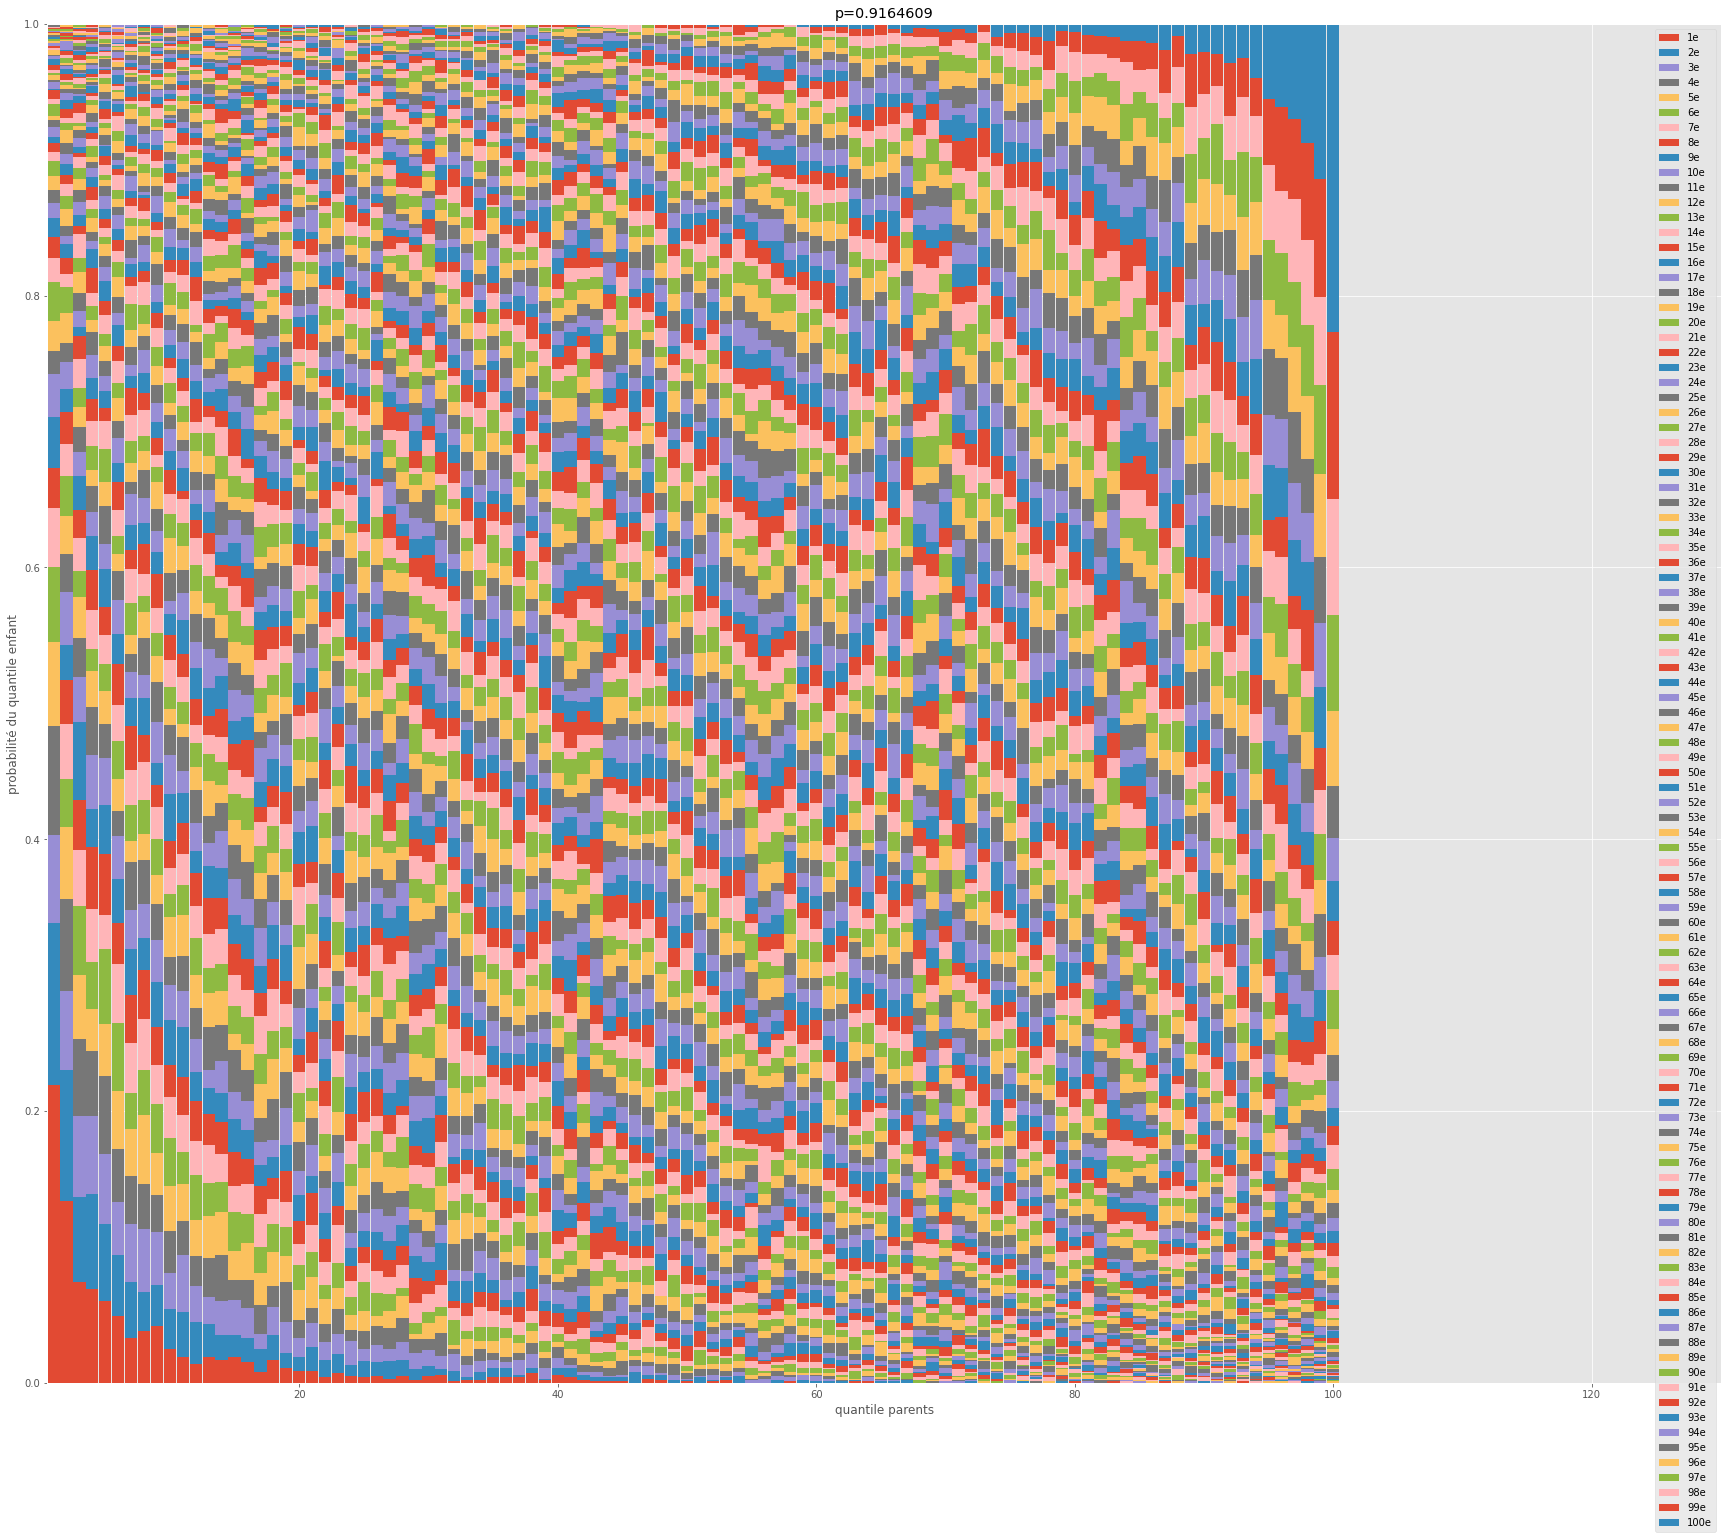

In [177]:
plot_conditional_distributions(pj, cd, nb_quantiles)

In [178]:
c_i_parent = 5
c_i_child = 1
p = proba_cond(c_i_parent, c_i_child, cd)
print("\nP(c_i_parent = {} | c_i_child = {}, pj = {}) = {}".format(c_i_parent, c_i_child, pj, p))
print(f"nombre d'individus : {500*p}")


P(c_i_parent = 5 | c_i_child = 1, pj = 0.9164609) = 0.045
nombre d'individus : 22.5


In [179]:
sample.head()

,y_child,y_parents,c_i_child,c_i_parent
0,0.224757,0.682885,14,36
1,1.009888,0.969606,51,49
2,1.002130,1.541577,51,67
3,1.116184,0.558370,54,29
4,37.205235,1.671187,100,70


In [180]:
# préparation des données
# nb_quantiles = gdim_data_clone.c_i_child.unique()
# # nombre de d'individus générés aléatoirement 1000 * nb_quantiles
# n = 1000 * nb_quantiles
# countries = gdim_data_clone['country'].unique()
# c_i_parent = []
# gdim_data_clone['c_i_parent'] = 0

# Nombre de d'individus générés aléatoirement 1_000 * nb_quantiles
n=100000

# Préparation des données
nb_quantiles=100
countries = gdim_data_clone['country'].drop_duplicates().values
c_i_parent = []
gdim_data_clone['c_i_parent'] = 0

# pour chaque pays
for place in countries:
    # selection du pays
    y_child, y_parent = generate_incomes(n, gdim_data_clone.loc[gdim_data_clone['country'] == place, 'pj'].iloc[0]) 
    # création des quantiles
    sample = compute_quantiles(y_child, y_parent, nb_quantiles) 
    # création de l'arrondi du nombre d'individus attendu en fonction des distributions conditionnelles
    cd = np.round(conditional_distributions(sample, nb_quantiles) * 500)
    # conversion en type entier
    cd = np.array(cd, int)
    # passage en dataframe
    cdd = pd.DataFrame(cd)
    # création de la transposée
    cdt = cdd.T

    # pour chaque c_i_child
    for cic in np.arange(100):
        # création d'une liste d'index des valeurs supérieur à 5 grâce à la transposée
        list_random = cdt.loc[cdt[cic] > 5, cic].index.tolist()

        # si la somme des individus par pays et c_i_child est inférieure à 500 individus
        if cdd.loc[cdd.index == cic].sum().sum() < 500:        
            # calcul du nombre de valeurs manquantes
            diff = 500 - cdd.loc[cdd.index == cic].sum().sum()
            # prélèvement d'index dans la liste des valeurs supérieures à 5 individus
            al_ind = random.sample(list_random, diff)
            # ajout de 1 pour les individus prélévés
            cdd.loc[cdd.index == cic, al_ind] = cdd.loc[cdd.index == cic, al_ind] + 1

        # si la somme des individus par pays et c_i_child est supérieure à 500 individus
        elif cdd.loc[cdd.index == cic].sum().sum() > 500:
            # calcul du nombre de valeurs en trop
            diff = cdd.loc[cdd.index == cic].sum().sum() - 500
            # prélèvement d'index dans la liste des valeurs supérieures à 5 individus
            al_ind = random.sample(list_random, diff)
            # soustraction de 1 pour les individus prélévés
            cdd.loc[cdd.index == cic, al_ind] = cdd.loc[cdd.index == cic, al_ind] - 1

        # pour chaque c_i_parent
        for cip in range(0,100):
            # on étend la liste c_i_parent de l'index + 1 de la valeur contenu en c_i_child, c_i_parent
            c_i_parent.extend(np.repeat(cip + 1, cdd.iloc[cic, cip], axis=0))
    # on affecte les valeurs de la liste c_i_parent à la colonne c_i_parent de notre dataframe principale
    gdim_data_clone.loc[(gdim_data_clone['country'] == place), 'c_i_parent'] = c_i_parent
    # on reinitialise la liste c_i_parent
    c_i_parent =[]

### ajout du revenu moyen de chaque pays ***mj***

In [181]:
gdim_data_clone.head(3)

,country,c_i_child,y_child,Gj,pj,c_i_parent
0,Albania,1,728.89795,0.32141,0.815874,1
0,Albania,1,728.89795,0.32141,0.815874,1
0,Albania,1,728.89795,0.32141,0.815874,1


In [182]:
# on n'a pas besoin de la variable c_i_child pour la mission 4
cloned = gdim_data_clone.copy()
cloned.drop(columns='c_i_child', inplace=True)

# création d'un dataframe avec la variable revenu moyen du pays (mj)
y_child_mean = cloned.groupby(by='country').mean().copy()
y_child_mean.reset_index(inplace=True)
y_child_mean = y_child_mean[['country', 'y_child']]
y_child_mean.rename(columns={'y_child': 'mj'}, inplace=True)
y_child_mean.head(3)

,country,mj
0,Albania,2994.829902
1,Argentina,5847.884654
2,Armenia,1628.382785


In [183]:
# ajout de la colonne y_child_mean
data_m3 = pd.merge(cloned, y_child_mean, on='country')
data_m3.head(3)

,country,y_child,Gj,pj,c_i_parent,mj
0,Albania,728.89795,0.32141,0.815874,1,2994.829902
1,Albania,728.89795,0.32141,0.815874,1,2994.829902
2,Albania,728.89795,0.32141,0.815874,1,2994.829902


## Mission 4

### préparation du dataset

#### consignes








1. Explication du revenu des individus
- en fonction de :
      j = pays de l'individu
      Gj = indice de Gini de ce pays
      c_i_parent = classe de revenus des parents

2. Application de l'ANOVA
- avec :
      j = pays de l'individu

3. Test
- en exprimant :
      mj = le revenu moyen du pays
      ln_parent_child = revenus (parents & enfants) en logarithme (ln)
- en laissant tels quels

4. Application d'une régression linéaire
- avec :
      i_mj = revenu moyen du pays de l’individu
      i_Gj = indice de Gini du pays de l’individu

#### dictionnaire

**Variable d'intérêt (*dependante, à expliquer*) :**
- **y_child** ou
- **ln_y_child**

**Facteurs (*independantes, explicatives*) :**
- **country**
- **mj**
- **ln_mj**
- **Gj**
- **c_i_parent**

**Description des variables :**
- **country** = pays d'origine d'un individus
- **mj** = revenu moyen par pays
- **ln_mj** = logarithme de **`mj`**
- **Gj** = Indice de Gini du pays
- **c_i_parent** = classe de revenu des parent
- **y_child** = revenu
- **ln_y_child** = logarithme de y_child

#### ajout des colonnes logarithmes ***ln***

In [184]:
# ajout des colonnes 'logarithmes'
data_m3['ln_y_child'] = np.log(data_m3['y_child'])
data_m3['ln_mj'] = np.log(data_m3['mj'])
data_m3.head(3)

,country,y_child,Gj,pj,c_i_parent,mj,ln_y_child,ln_mj
0,Albania,728.89795,0.32141,0.815874,1,2994.829902,6.591534,8.004643
1,Albania,728.89795,0.32141,0.815874,1,2994.829902,6.591534,8.004643
2,Albania,728.89795,0.32141,0.815874,1,2994.829902,6.591534,8.004643


In [185]:
data_m3.groupby('country').count().shape

(116, 7)

### ANOVA de la variable revenus des enfants en fonction du pays

#### Préparation et représentation des données

In [186]:
# pour l'ensemble des tests, notre niveau de test sera:
alpha = 0.05

Le pays d'origine a-t-il une influence sur le revenu?
- H0: Tous les pays ont le même revenu (tous les alpha_i sont nuls)
      Le pays n'a pas d'influence sur le revenu enfant moyen

- H1: Les revenus dépendent du pays (les alpha_i sont différents de 0)
      Le pays a une influence sur le revenu

In [187]:
data_m3.head(3)

,country,y_child,Gj,pj,c_i_parent,mj,ln_y_child,ln_mj
0,Albania,728.89795,0.32141,0.815874,1,2994.829902,6.591534,8.004643
1,Albania,728.89795,0.32141,0.815874,1,2994.829902,6.591534,8.004643
2,Albania,728.89795,0.32141,0.815874,1,2994.829902,6.591534,8.004643


In [188]:
print('Valeurs dupliquées: ' + str(data_m3.duplicated().sum()))
data_m3.shape

Valeurs dupliquées: 4708604


(5800000, 8)

In [189]:
# agrégation pour gagner en temps de calculs
data_agg = data_m3.groupby(by=['country', 'y_child', 'mj', 'Gj', 'pj', 'ln_mj', 'ln_y_child']).mean()
data_agg.reset_index(inplace=True)
data_agg.head(3)

,country,y_child,mj,Gj,pj,ln_mj,ln_y_child,c_i_parent
0,Albania,728.89795,2994.829902,0.32141,0.815874,8.004643,6.591534,9.380
1,Albania,916.66235,2994.829902,0.32141,0.815874,8.004643,6.820739,14.344
2,Albania,1010.91600,2994.829902,0.32141,0.815874,8.004643,6.918612,16.388


In [190]:
print('Valeurs dupliquées: ' + str(data_agg.duplicated().sum()))
data_agg.shape

Valeurs dupliquées: 0


(11600, 8)

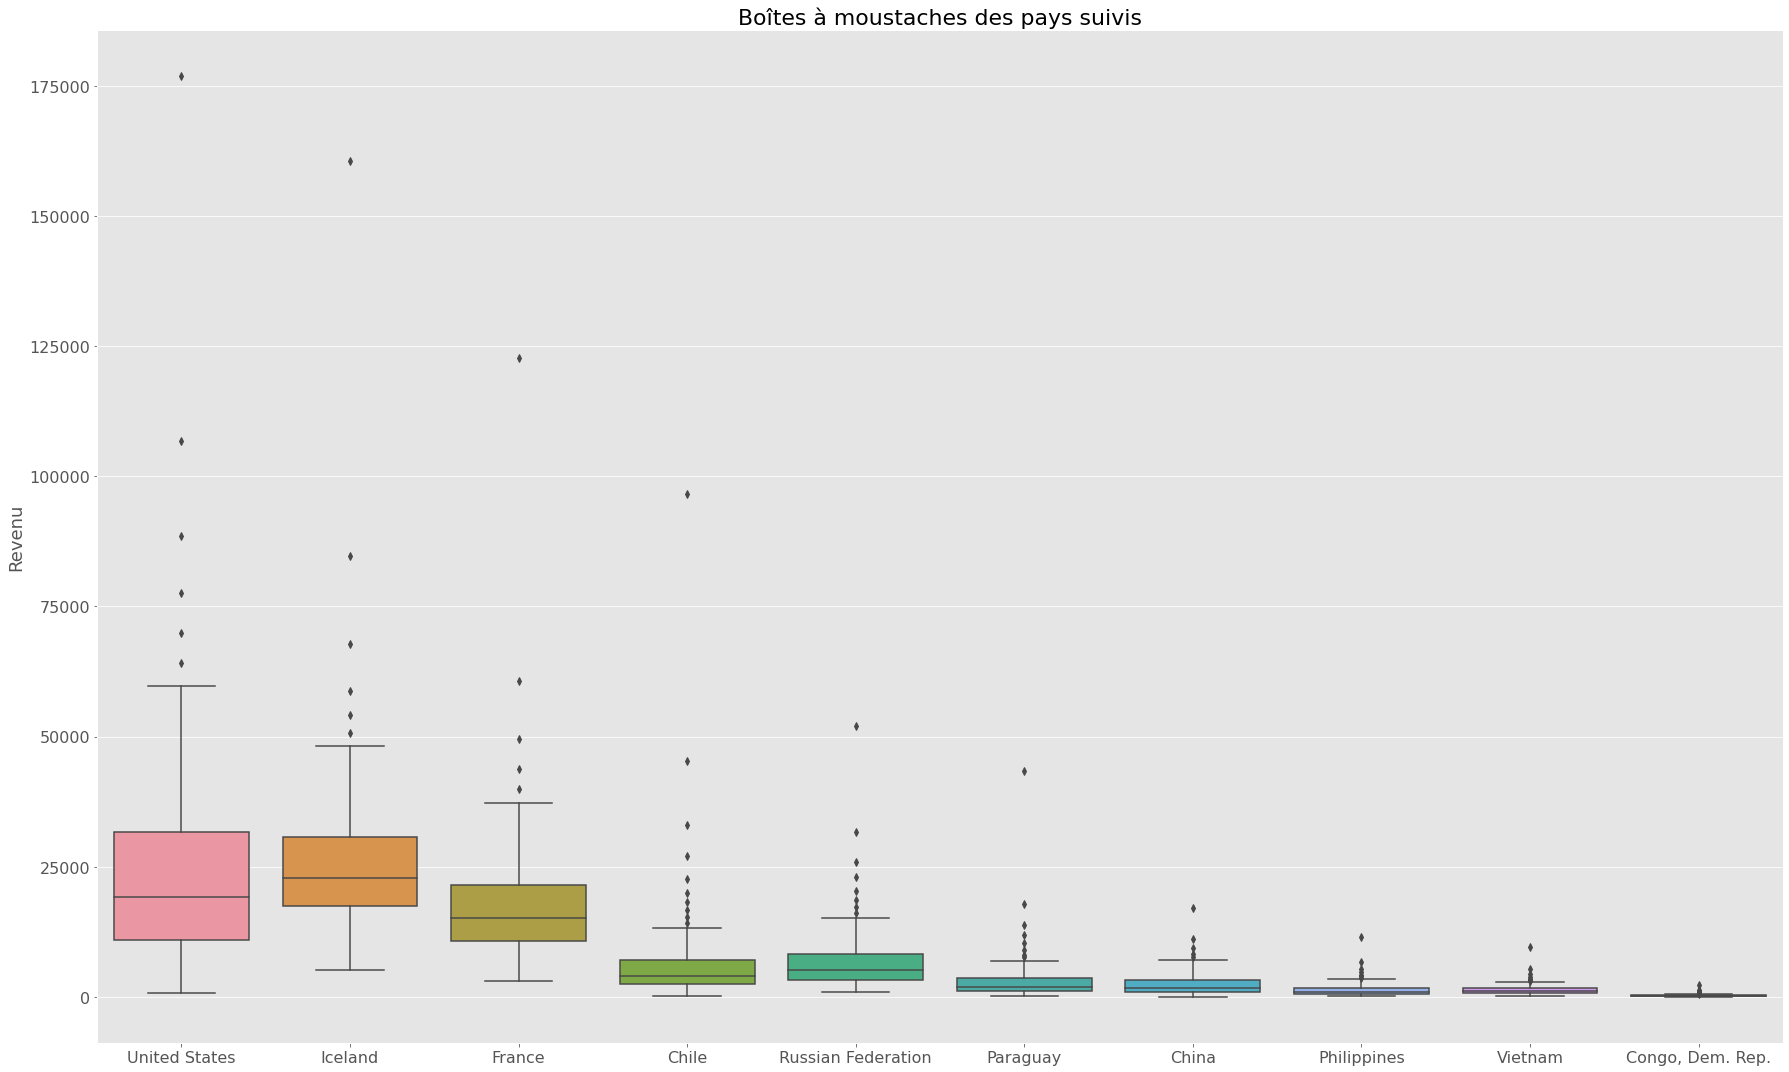

In [191]:
# affichage des pays suivis
p = pillars.country.unique()
pillars_m4 = data_agg[data_agg["country"].isin(p)].sort_values('y_child', ascending=False)

plt.figure(figsize=(25,15))

ax = sns.boxplot(x='country', y='y_child', data=pillars_m4)

plt.ylabel('Revenu', fontsize=18)
plt.yticks(fontsize=16)
plt.xlabel('')
plt.xticks(fontsize=16)
plt.title('Boîtes à moustaches des pays suivis', fontsize=22)
plt.tight_layout()

# plt.savefig('graph/boxplot_annova.png')
plt.show()

#### application de l'ANOVA

In [192]:
# plan d'expérience complet et équilibré car  n_1 = ... = n_i = 100
anova_pillars = smf.ols('y_child~country', data=data_agg).fit(alpha=alpha)
anova_pillars.summary().tables[0]

Dep. Variable:,y_child,R-squared:,0.496
Model:,OLS,Adj. R-squared:,0.491
Method:,Least Squares,F-statistic:,98.43
Date:,"Tue, 29 Mar 2022",Prob (F-statistic):,0.00
Time:,15:36:11,Log-Likelihood:,-1.1862e+05
No. Observations:,11600,AIC:,2.375e+05
Df Residuals:,11484,BIC:,2.383e+05
Df Model:,115,,
Covariance Type:,nonrobust,,


- **R2** = 0.496
- **R2ajusté** = 0.491

La variable pays explique près de 50% de la variance du revenu. Les autres facteurs non considérés dans le modèle expliquent l'autre moitié de la variance du revenu

In [193]:
# affichage des resultats du test de Fisher (influence de la variable pays)
test = sm.stats.anova_lm(anova_pillars, typ=1)
test

,df,sum_sq,mean_sq,F,PR(>F)
country,115.0,5.102375e+11,4.436848e+09,98.429271,0.0
Residual,11484.0,5.176586e+11,4.507651e+07,NaN,NaN


- **H0**: alpha_argentine = ... = alpha_yemen = 0 (le pays n'a pas d'influence, variables indépendantes)
- **H1**: alpha_argentine = ... = alpha_yemen != 0 (le pays a une influence, variables coorélées)

La p-valeur du Test de Fischer est: ~0.0

p-valeur < 0.05

On rejette donc l'hypothèse H0 et on conclut que le pays a une influence sur le revenu

Ce qui nous intéresse réellement est le Test de Fischer, qui nous donne la p-valeur = 0. Cette valeur est très petite et largement inférieur au seuil (***alpha***) de 5%. On rejette donc l'hypothèse H0, selon laquelle a1=a2=a3=a4=0. Le pays a donc bien un effet sur les revenus.

In [194]:
# CME = SCE / (I - 1) variance expliquée
I = 116
SCE = test.iloc[0,1]
CME = SCE / (I - 1)
SCE, CME

(510237524303.9016, 4436848037.425231)

In [195]:
# CMR = SCR /  (I - n) variance inexpliquée
n = 11600
SCR = test.iloc[1,1]
CMR = SCR / (n - I)
SCR, CMR

(517658642063.218, 45076510.106514975)

In [196]:
# F = CME / CMR
F = CME / CMR
F

98.42927118672318

In [197]:
# R_2 = SCE/ SCT = SCE / (SCE + SCR)
R_2 = SCE / (SCE + SCR)
R_2

0.4963901423109959

In [198]:
# R_2_ajusté = 1 - (n/(n - p)(1-R_2))
R_2_Aj = 1 - ((1 - R_2)*(n - 1)/(n - I -1))
R_2_Aj

0.4913027310515755

#### vérification de l'hypothèse gaussienne

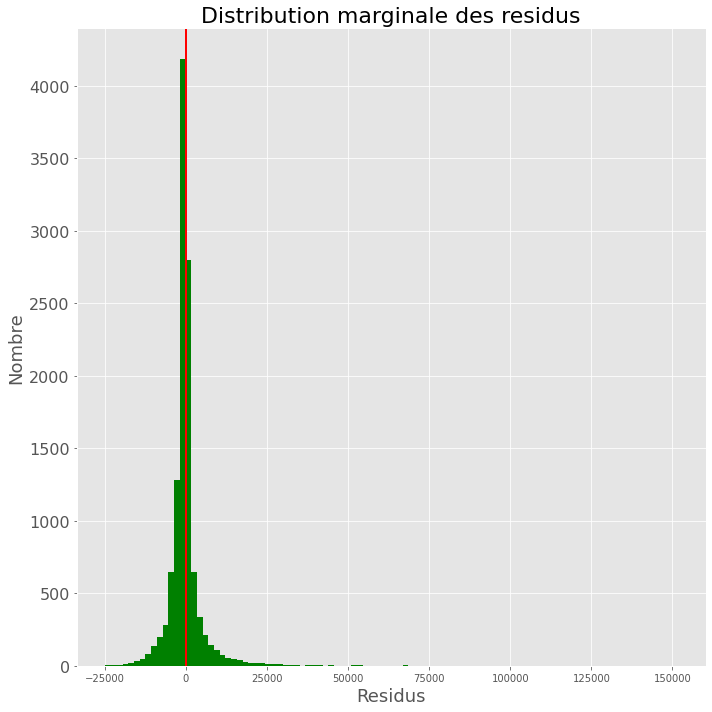

In [199]:
# préparation des données
X = anova_pillars.resid
Xbar = np.mean(X)
Xsprime = np.std(X)

# représentation de la distribution marginale
plt.figure(figsize=(10,10))

plt.hist(X, 100, facecolor='g')
plt.axvline(Xbar, color='r', linewidth=2)

plt.title(f'Distribution marginale des residus', fontsize=22)
plt.ylabel('Nombre',fontsize=18)
plt.yticks(fontsize=16)
plt.xlabel('Residus',fontsize=18)
plt.yticks(fontsize=16)
plt.tight_layout()

# plt.savefig('graph/dist_marg_resid_anova.png')
plt.show()

In [200]:
# Test de normalité Shapiro-Wilk
shapiro(X)

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.56099933385849, 0.0)

Le test Shapiro-Wilk n'est pas adapté à nos données, trop nombreuses

In [201]:
# test d'adequation à une loi (ici Normale) avec le test Kolmogorv-Smirnov
ks_2samp(X,list(np.random.normal(Xbar, Xsprime, 11600)))

Ks_2sampResult(statistic=0.250603448275862, pvalue=8.235034e-317)

- **H0**: les données suivent une loi normale
- **H1**: les données ne suivent pas une loi normale

p-value < 0.05, on rejette HO, les données ne suivent pas la loi normale(Xbar, XSprime)

In [202]:
# test de Jarque-Bera
JB1, JBpv1, skw1, kurt1 = sm.stats.stattools.jarque_bera(X)
JB1, JBpv1, skw1, kurt1

(4207431.542160326, 0.0, 6.739339356074629, 95.32202335877442)

- **H0**: les données suivent une loi normale
- **H1**: les données ne suivent pas une loi normale

JBpv ~ 0, on rejette HO, y_child ne suit pas la loi normale(Xbar, XSprime)

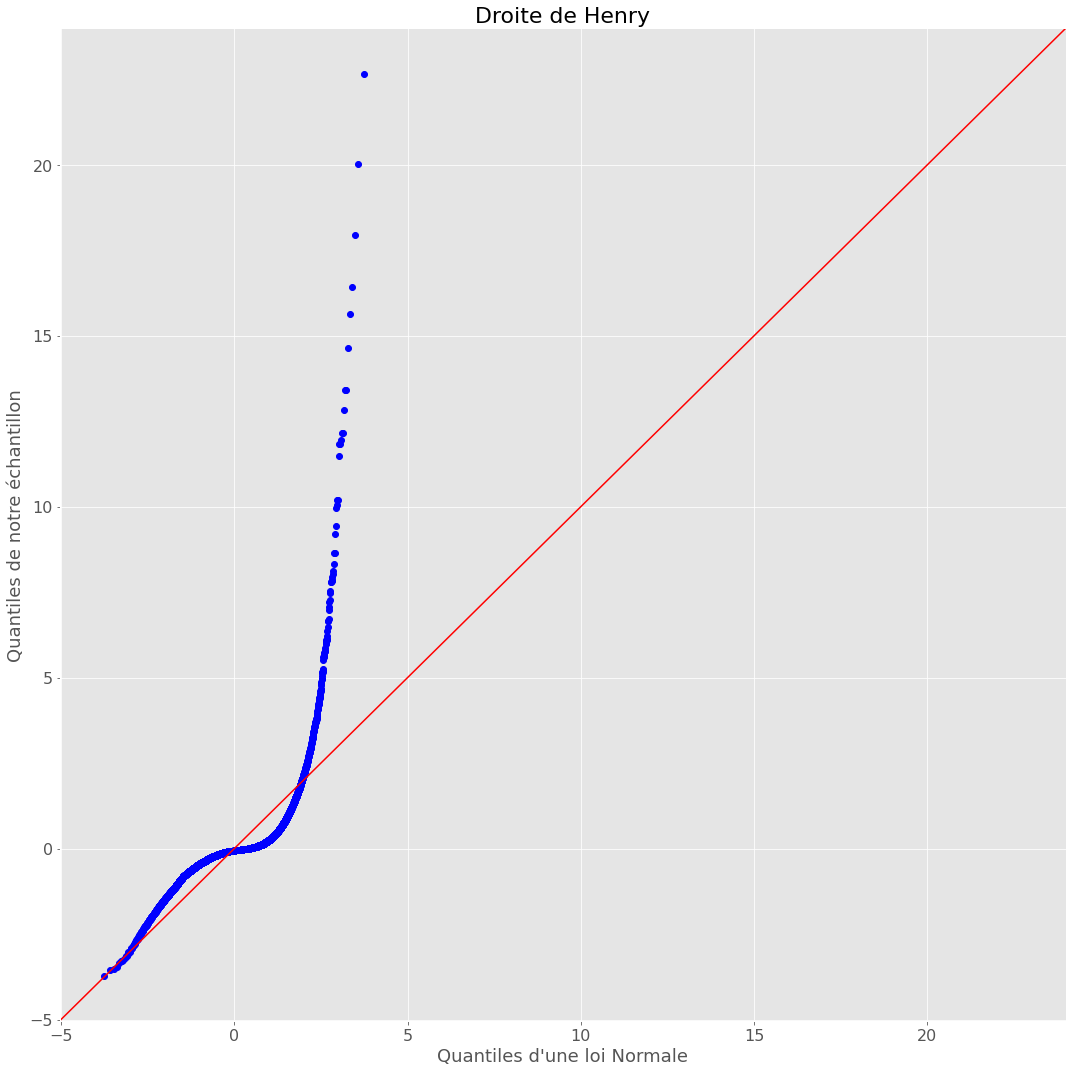

In [203]:
# droite de Henry
fig, ax = plt.subplots(figsize=(15, 15))

sm.qqplot(X, line='45', fit=True, ax=ax)

plt.ylabel('Quantiles de notre échantillon', fontsize=18)
plt.yticks(fontsize=16)
plt.xlabel('Quantiles d\'une loi Normale',fontsize=18)
plt.xticks(fontsize=16)
plt.title('Droite de Henry', fontsize=22)
plt.tight_layout()

# plt.savefig('graph/droite_henry_anova.png')
plt.show()

ce qui appelle vraiment cet ensemble de données comme n'étant pas normal, ce sont ces valeurs aberrantes. il s'agit d'une caractéristique d'un ensemble de données asymétrique à droite (positive skew)

### Regression Lineaire

#### régression linéaire du revenu enfant sur le revenu moyen du pays et l'indice de Gini

##### tests de significativité

In [204]:
reg = smf.ols('y_child ~ Gj + mj', data=data_agg)
reg_multi = reg.fit()
reg_multi.summary().tables[0]

Dep. Variable:,y_child,R-squared:,0.496
Model:,OLS,Adj. R-squared:,0.496
Method:,Least Squares,F-statistic:,5715.
Date:,"Tue, 29 Mar 2022",Prob (F-statistic):,0.00
Time:,15:36:12,Log-Likelihood:,-1.1862e+05
No. Observations:,11600,AIC:,2.372e+05
Df Residuals:,11597,BIC:,2.373e+05
Df Model:,2,,
Covariance Type:,nonrobust,,


Test global:
- **H0**: beta_GJ = beta_y_mj = 0
- **H1**: beta_GJ != beta_y_mj != 0

F ~ 0.00 < alpha

On rejette H0, le modèle est globalement significatif

In [205]:
reg_multi.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,5.321e-11,328.716,1.62e-13,1.000,-644.338,644.338
Gj,-7.731e-11,749.825,-1.03e-13,1.000,-1469.784,1469.784
mj,1.0000,0.010,99.934,0.000,0.980,1.020


Test de significativité des variables:

- **H0**: beta_Gj = 0
- **H1**: beta_Gj != 0

Le paramètre beta_Gj de la variable Gj (indice de gini) n'est pas significatif au niveau de test alpha (0.05)
> En effet p-value ~ 1 > alpha, on accepte H0, le paramètre n'est pas significatif (beta_Gj = 0)

- **H0**: beta_y_mj = 0
- **H1**: beta_y_mj != 0

Le paramètre beta_y_mj de la variable mj est significatif au niveau de test alpha (0.05)
>En effet p-value ~ 0.00 < alpha, on rejette H0, le paramètre est significatif (beta_y_mj != 0)

##### passage au logarithme du revenu enfant

In [206]:
reg_ln = smf.ols('ln_y_child ~ Gj + ln_mj', data=data_agg)
reg_multi_ln = reg_ln.fit()
reg_multi_ln.summary().tables[0]

Dep. Variable:,ln_y_child,R-squared:,0.729
Model:,OLS,Adj. R-squared:,0.729
Method:,Least Squares,F-statistic:,1.558e+04
Date:,"Tue, 29 Mar 2022",Prob (F-statistic):,0.00
Time:,15:36:12,Log-Likelihood:,-12636.
No. Observations:,11600,AIC:,2.528e+04
Df Residuals:,11597,BIC:,2.530e+04
Df Model:,2,,
Covariance Type:,nonrobust,,


Test global:
- **H0**: beta_GJ = beta_y_mj = 0
- **H1**: beta_GJ != beta_y_mj != 0

F ~ 0.00 < alpha

On rejette H0, le modèle est globalement significatif

In [207]:
reg_multi_ln.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.4961,0.065,7.646,0.000,0.369,0.623
Gj,-1.6523,0.078,-21.101,0.000,-1.806,-1.499
ln_mj,0.9864,0.006,163.259,0.000,0.975,0.998


Test de significativité des variables:

- **H0**: beta_Gj = 0
- **H1**: beta_Gj != 0

Le paramètre beta_Gj de la variable Gj (indice de gini) est significatif au niveau de test alpha (0.05)
> En effet p-value ~ 0.00 < alpha, on rejette H0, le paramètre est significatif (beta_Gj != 0)

- **H0**: beta_y_mj = 0
- **H1**: beta_y_mj != 0

Le paramètre beta_ln_mj de la variable ln_mj est significatif au niveau de test alpha (0.05)
>En effet p-value ~ 0.00 < alpha, on rejette H0, le paramètre est significatif (beta_y_mj != 0)

##### analyses de $R^{2}$

In [208]:
# anova sur les variables de notre régression linéaire
anova_ln = sm.stats.anova_lm(reg_multi_ln, typ=1)
anova_ln

,df,sum_sq,mean_sq,F,PR(>F)
Gj,1.0,2334.498202,2334.498202,4512.044930,0.0
ln_mj,1.0,13790.334757,13790.334757,26653.526637,0.0
Residual,11597.0,6000.200812,0.517392,NaN,NaN


In [209]:
# calcul du R2 pour la variable 'Gj'
r2_Gj = anova_ln.sum_sq['Gj'] / anova_ln['sum_sq'].sum()
r2_Gj

0.10551388198747656

In [210]:
# calcul du R2 pour la variable 'ln_mj'
r2_ln_mj = anova_ln.sum_sq['ln_mj'] / anova_ln['sum_sq'].sum()
r2_ln_mj

0.6232910150247708

In [211]:
# vérification
r2_Gj + r2_ln_mj, reg_multi_ln.rsquared

(0.7288048970122474, 0.7288048970122482)

Dans notre modèle : 

In [212]:
print(f"La variable Gj explique {100 * r2_Gj:.2f}% de la variance de la variable ln_y_child")
print(f"La variable ln_mj explique {100 * r2_ln_mj:.2f}% de la variance de la variable ln_y_child")
print(f"Notre modèle explique {100 * reg_multi_ln.rsquared:.2f}% de la variance de la variable ln_y_child")

La variable Gj explique 10.55% de la variance de la variable ln_y_child
La variable ln_mj explique 62.33% de la variance de la variable ln_y_child
Notre modèle explique 72.88% de la variance de la variable ln_y_child


##### analyse de l'atypicité sur les variables explicatives

In [213]:
# paramètres de l'étude
n = data_agg.shape[0]
p = 3

# seuil levier selon Belsey
seuil_levier = 2 * p / n

In [214]:
# ajout des termes diagonaux de H
data_agg['levier'] = reg_multi_ln.get_influence().hat_matrix_diag
data_agg.sort_values(by='levier', ascending=False).head()

,country,y_child,mj,Gj,pj,ln_mj,ln_y_child,c_i_parent,levier
9501,South Africa,138.34155,5617.90488,0.682949,0.677,8.633714,4.929726,18.124,0.001162
9537,South Africa,1368.08520,5617.90488,0.682949,0.677,8.633714,7.221167,44.254,0.001162
9527,South Africa,988.31870,5617.90488,0.682949,0.677,8.633714,6.896005,40.378,0.001162
9528,South Africa,1022.72200,5617.90488,0.682949,0.677,8.633714,6.930223,40.722,0.001162
9529,South Africa,1064.22410,5617.90488,0.682949,0.677,8.633714,6.970001,41.030,0.001162


In [215]:
data_agg.sort_values(by='levier').head()

,country,y_child,mj,Gj,pj,ln_mj,ln_y_child,c_i_parent,levier
9001,Romania,364.8295,3318.337189,0.389527,0.369699,8.107219,5.899430,29.488,0.000087
9027,Romania,1746.9655,3318.337189,0.389527,0.369699,8.107219,7.465636,43.560,0.000087
9028,Romania,1794.1764,3318.337189,0.389527,0.369699,8.107219,7.492301,44.562,0.000087
9029,Romania,1845.0685,3318.337189,0.389527,0.369699,8.107219,7.520272,44.442,0.000087
9030,Romania,1890.7778,3318.337189,0.389527,0.369699,8.107219,7.544744,45.570,0.000087


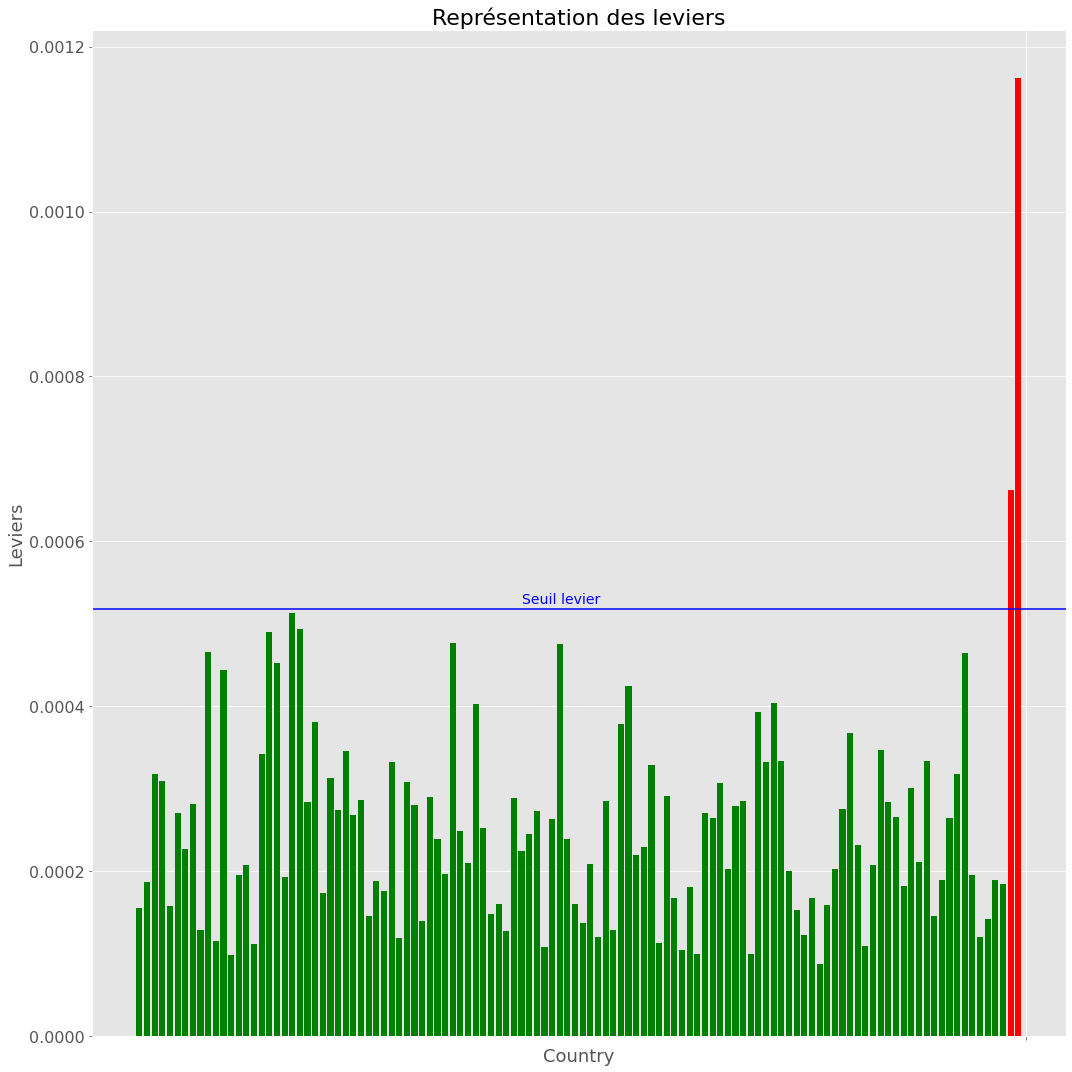

In [216]:
data_m4_levier = data_agg.groupby(['country', 'mj', 'Gj', 'pj', 'ln_mj']).mean()
data_m4_levier.reset_index(inplace=True)

# représentation des leviers
plt.figure(figsize=(15,15))

# individus sous le seuil
plt.bar(data_m4_levier.loc[data_m4_levier['levier'] <= seuil_levier]['country'],
        data_m4_levier.loc[data_m4_levier['levier'] <= seuil_levier]['levier'], color='g')

# individus au dessus du seuil
plt.bar(data_m4_levier.loc[data_m4_levier['levier'] > seuil_levier]['country'],
        data_m4_levier.loc[data_m4_levier['levier'] > seuil_levier]['levier'], color='r')

# annotations
plt.title('Représentation des leviers', fontsize=22)
plt.xlabel('Country', fontsize=18)
plt.xticks('', fontsize=16)
plt.ylabel('Leviers', fontsize=18)
plt.yticks(fontsize=16)
plt.axhline(y=seuil_levier, color='b', linestyle='-')
plt.text(50, 0.000525 , 'Seuil levier', fontsize = '14', color='b')
plt.tight_layout()

# plt.savefig('graph/leviers1.png')
plt.show()

In [217]:
# nombre de valeurs atypiques sur les variables explicatives
lev_ln = data_agg.loc[data_agg['levier'] > seuil_levier, :]
len(lev_ln)

200

In [218]:
# pays presentants des valeurs atypiques
data_m4_levier.loc[data_m4_levier['levier'] > seuil_levier]

,country,mj,Gj,pj,ln_mj,y_child,ln_y_child,c_i_parent,levier
43,Honduras,3296.268419,0.615512,0.940737,8.100546,3296.268419,7.380957,50.48604,0.000662
95,South Africa,5617.904880,0.682949,0.677000,8.633714,5617.904880,7.717752,50.50666,0.001162


In [219]:
print(len(data_agg.loc[data_agg['country']=="Honduras"]))
print(len(data_agg.loc[data_agg['country']=="South Africa"]))


100
100


In [220]:
data_m4_levier.sort_values(by='levier', ascending=False).head()

,country,mj,Gj,pj,ln_mj,y_child,ln_y_child,c_i_parent,levier
95,South Africa,5617.904880,0.682949,0.677000,8.633714,5617.904880,7.717752,50.50666,0.001162
43,Honduras,3296.268419,0.615512,0.940737,8.100546,3296.268419,7.380957,50.48604,0.000662
20,Colombia,3547.005276,0.583437,1.095440,8.173859,3547.005276,7.556374,50.45958,0.000513
21,"Congo, Dem. Rep.",276.016044,0.459403,0.707703,5.620459,276.016044,5.288002,50.48532,0.000494
17,Central African Republic,811.299901,0.575972,0.661654,6.698638,811.299901,6.130762,50.49066,0.000490


##### analyse de l'atypicité sur la variable à expliquer (residus studentisés)

In [221]:
# détermination du seuil statistique d'atypicité
seuil_rstudent = t.ppf(1-alpha/2,n-p-1)
seuil_rstudent

1.9601685822161563

In [222]:
# statistique de test par observation
data_agg['rstudent'] = reg_multi_ln.get_influence().resid_studentized_internal
data_agg.sort_values(by='rstudent').head()

,country,y_child,mj,Gj,pj,ln_mj,ln_y_child,c_i_parent,levier,rstudent
5700,"Korea, Rep.",17.317732,15227.569445,0.367935,0.394000,9.630863,2.851731,24.884,0.000238,-9.087780
1600,Canada,122.424810,23739.640518,0.366553,0.269333,10.074902,4.807497,30.916,0.000341,-6.980981
1900,China,16.719418,2522.758726,0.493332,0.399000,7.833108,2.816571,23.762,0.000193,-6.382910
900,Bolivia,20.584948,3016.263843,0.575719,0.866268,8.011774,3.024560,8.610,0.000465,-6.150327
5100,Israel,142.350430,11100.318137,0.429918,0.348050,9.314729,4.958292,25.674,0.000224,-5.582806


In [223]:
data_agg.sort_values(by='rstudent').tail()

,country,y_child,mj,Gj,pj,ln_mj,ln_y_child,c_i_parent,levier,rstudent
999,Bolivia,43786.920,3016.263843,0.575719,0.866268,8.011774,10.687090,92.564,0.000465,4.504913
1799,Central African Republic,14472.948,811.299901,0.575972,0.661654,6.698638,9.580037,86.714,0.000490,4.767232
9599,South Africa,82408.550,5617.904880,0.682949,0.677000,8.633714,11.319444,88.096,0.001162,4.779222
4399,Honduras,56265.700,3296.268419,0.615512,0.940737,8.100546,10.937840,93.324,0.000662,4.823737
4199,Guatemala,39799.406,2142.474753,0.582468,1.015206,7.669717,10.591607,94.256,0.000476,4.856839


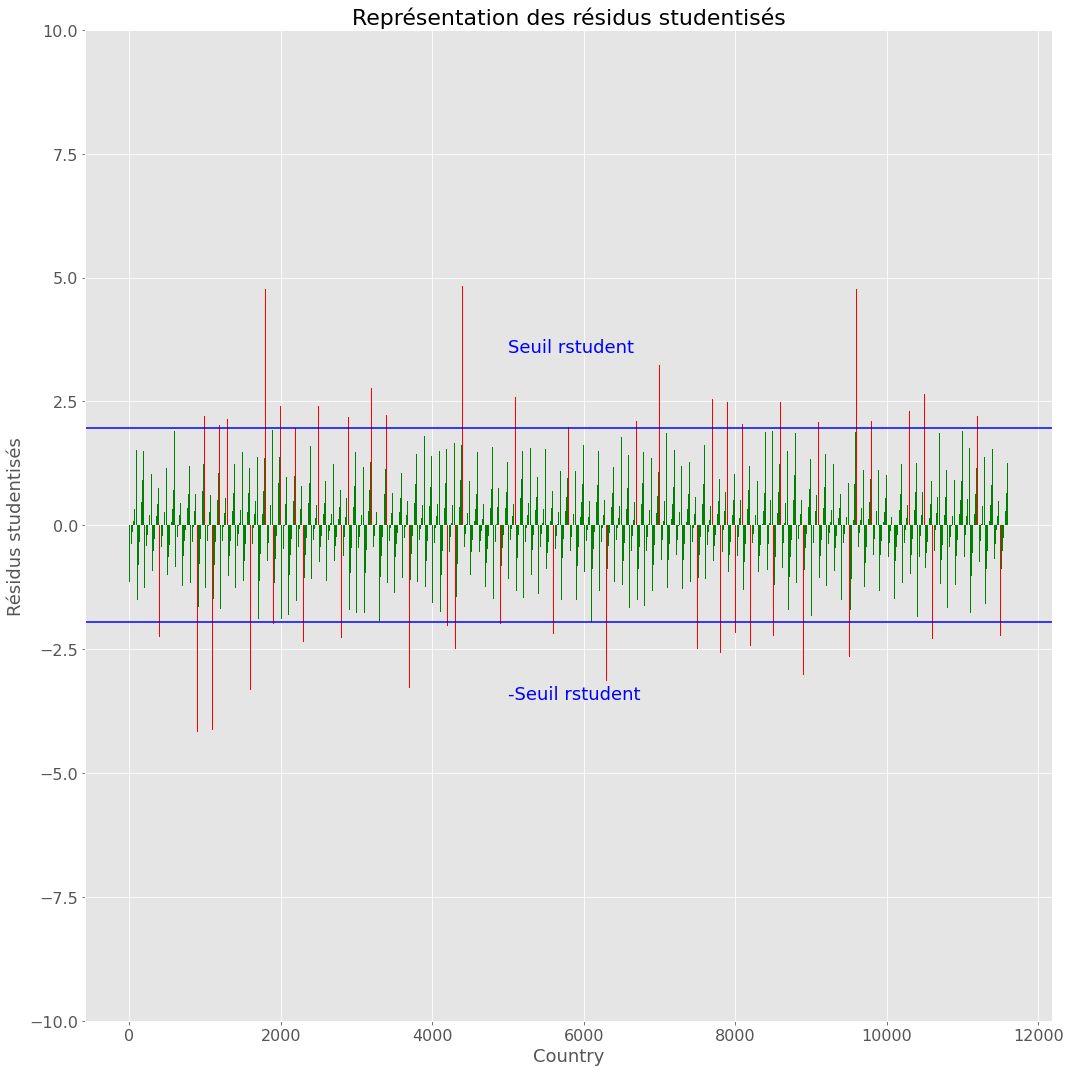

In [224]:
data_m4_rstudent = data_agg.groupby(['country', 'mj', 'Gj', 'pj', 'ln_mj', 'rstudent']).mean()
data_m4_rstudent.reset_index(inplace=True)

# représentation des leviers
plt.figure(figsize=(15,15))

# individus entre le seuil mini et le seuil maxi
plt.bar(data_m4_rstudent.loc[(data_m4_rstudent['rstudent'] <= seuil_rstudent) & (data_m4_rstudent['rstudent'] >= -seuil_rstudent)].index,
        data_m4_rstudent.loc[(data_m4_rstudent['rstudent'] <= seuil_rstudent) & (data_m4_rstudent['rstudent'] >= -seuil_rstudent)]['rstudent'], color='g')

# individus au dessus du seuil maxi
plt.bar(data_m4_rstudent.loc[data_m4_rstudent['rstudent'] > seuil_rstudent].index,
        data_m4_rstudent.loc[data_m4_rstudent['rstudent'] > seuil_rstudent]['rstudent'], color='r')

# individus au dessous du seuil maxi
plt.bar(data_m4_rstudent.loc[data_m4_rstudent['rstudent'] < -seuil_rstudent].index,
        data_m4_rstudent.loc[data_m4_rstudent['rstudent'] < -seuil_rstudent]['rstudent'], color='r')

# annotations
plt.title('Représentation des résidus studentisés', fontsize=22)
plt.xlabel('Country', fontsize=18)
plt.xticks(fontsize=16)
plt.ylim(-10,10)
plt.ylabel('Résidus studentisés', fontsize=18)
plt.yticks(fontsize=16)

plt.axhline(y=seuil_rstudent, color='b', linestyle='-')
plt.text(5000, 3.5 , 'Seuil rstudent', fontsize = '18', color='b')

plt.axhline(y=-seuil_rstudent, color='b', linestyle='-')
plt.text(5000, -3.5 , '-Seuil rstudent', fontsize = '18', color='b')

plt.tight_layout()

# plt.savefig('graph/res_stu.png', dpi=300)
plt.show()

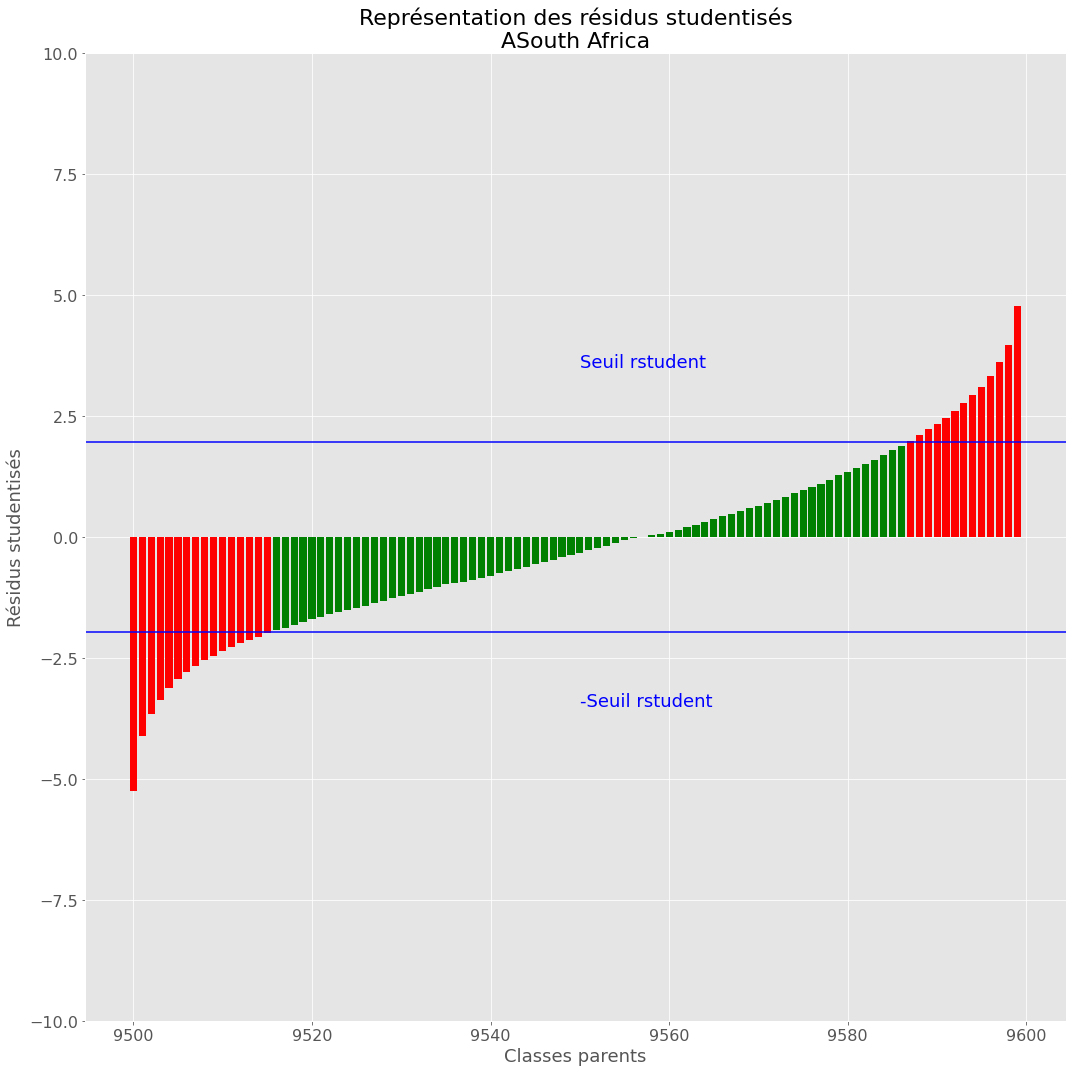

In [225]:
m4_africa = data_m4_rstudent.loc[(data_m4_rstudent['country'] == 'South Africa')]

# représentation des leviers
plt.figure(figsize=(15,15))

# individus entre le seuil mini et le seuil maxi
plt.bar(m4_africa.loc[(m4_africa['rstudent'] <= seuil_rstudent) & (m4_africa['rstudent'] >= -seuil_rstudent)].index,
        m4_africa.loc[(m4_africa['rstudent'] <= seuil_rstudent) & (m4_africa['rstudent'] >= -seuil_rstudent)]['rstudent'], color='g')

# individus au dessus du seuil maxi
plt.bar(m4_africa.loc[m4_africa['rstudent'] > seuil_rstudent].index,
        m4_africa.loc[m4_africa['rstudent'] > seuil_rstudent]['rstudent'], color='r')

# individus au dessous du seuil maxi
plt.bar(m4_africa.loc[m4_africa['rstudent'] < -seuil_rstudent].index,
        m4_africa.loc[m4_africa['rstudent'] < -seuil_rstudent]['rstudent'], color='r')

# annotations
plt.title('Représentation des résidus studentisés\nASouth Africa', fontsize=22)
plt.xlabel('Classes parents', fontsize=18)
plt.xticks(fontsize=16)
plt.ylim(-10,10)
plt.yticks(fontsize=16)
plt.ylabel('Résidus studentisés', fontsize=18)

plt.axhline(y=seuil_rstudent, color='b', linestyle='-')
plt.text(9550, 3.5 , 'Seuil rstudent', fontsize = '18', color='b')

plt.axhline(y=-seuil_rstudent, color='b', linestyle='-')
plt.text(9550, -3.5 , '-Seuil rstudent', fontsize = '18', color='b')

plt.tight_layout()

# plt.savefig('graph/res_saf.png')
plt.show()

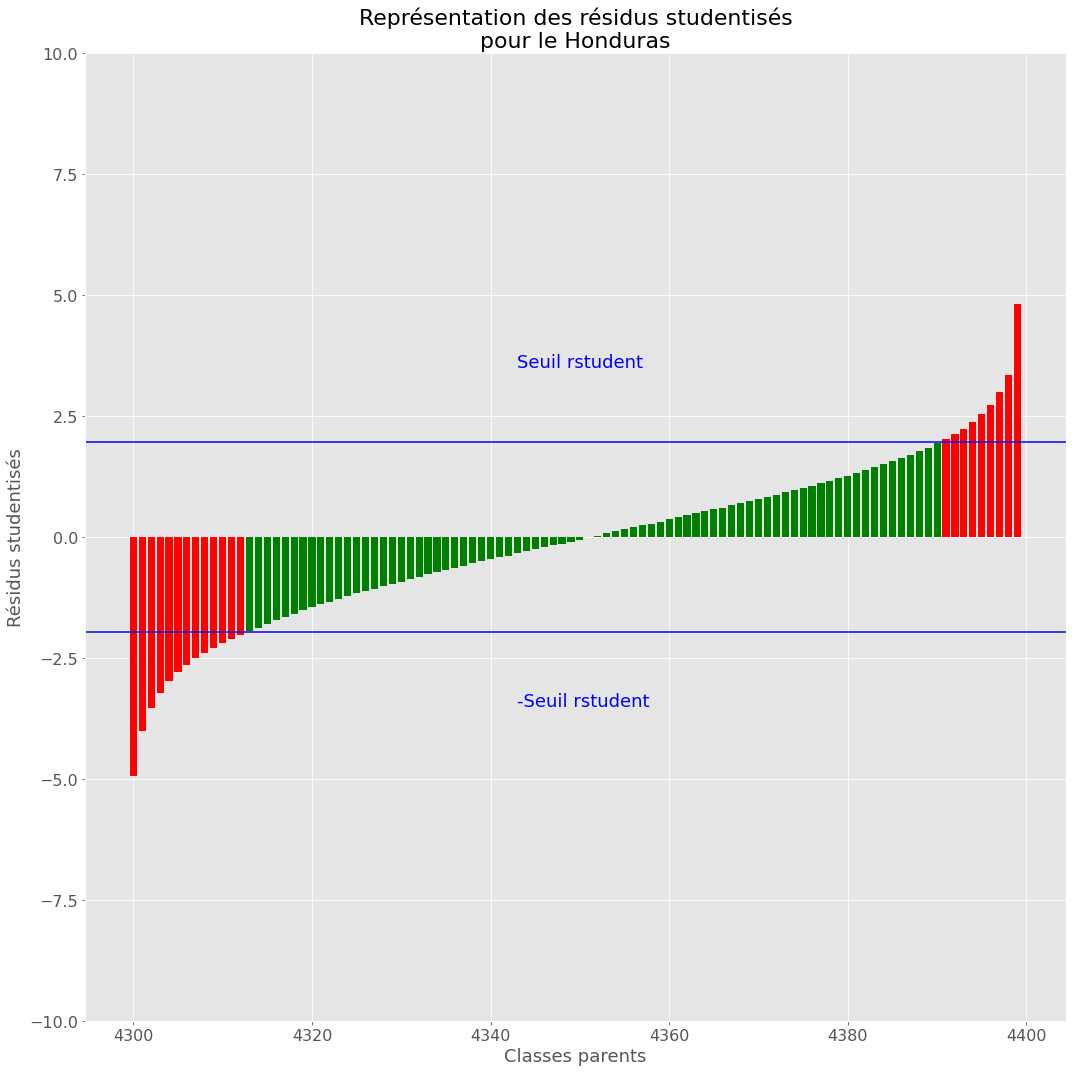

In [226]:
m4_honduras = data_m4_rstudent.loc[(data_m4_rstudent['country'] == 'Honduras')]

# Représentation des leviers
plt.figure(figsize=(15,15))

# Individus entre le seuil mini et le seuil maxi
plt.bar(m4_honduras.loc[(m4_honduras['rstudent'] <= seuil_rstudent) & (m4_honduras['rstudent'] >= -seuil_rstudent)].index,
        m4_honduras.loc[(m4_honduras['rstudent'] <= seuil_rstudent) & (m4_honduras['rstudent'] >= -seuil_rstudent)]['rstudent'], color='g')

# Individus au dessus du seuil maxi
plt.bar(m4_honduras.loc[m4_honduras['rstudent'] > seuil_rstudent].index,
        m4_honduras.loc[m4_honduras['rstudent'] > seuil_rstudent]['rstudent'], color='r')

# Individus au dessous du seuil maxi
plt.bar(m4_honduras.loc[m4_honduras['rstudent'] < -seuil_rstudent].index,
        m4_honduras.loc[m4_honduras['rstudent'] < -seuil_rstudent]['rstudent'], color='r')

# Décoration et annotations
plt.title('Représentation des résidus studentisés\npour le Honduras', fontsize=22)
plt.xlabel('Classes parents', fontsize=18)
plt.xticks(fontsize=16)
plt.ylim(-10,10)
plt.yticks(fontsize=16)
plt.ylabel('Résidus studentisés', fontsize=18)

plt.axhline(y=seuil_rstudent, color='b', linestyle='-')
plt.text(4343, 3.5 , 'Seuil rstudent', fontsize = '18', color='b')

plt.axhline(y=-seuil_rstudent, color='b', linestyle='-')
plt.text(4343, -3.5 , '-Seuil rstudent', fontsize = '18', color='b')

plt.tight_layout()

# plt.savefig('graph/res_hon.png')
plt.show()

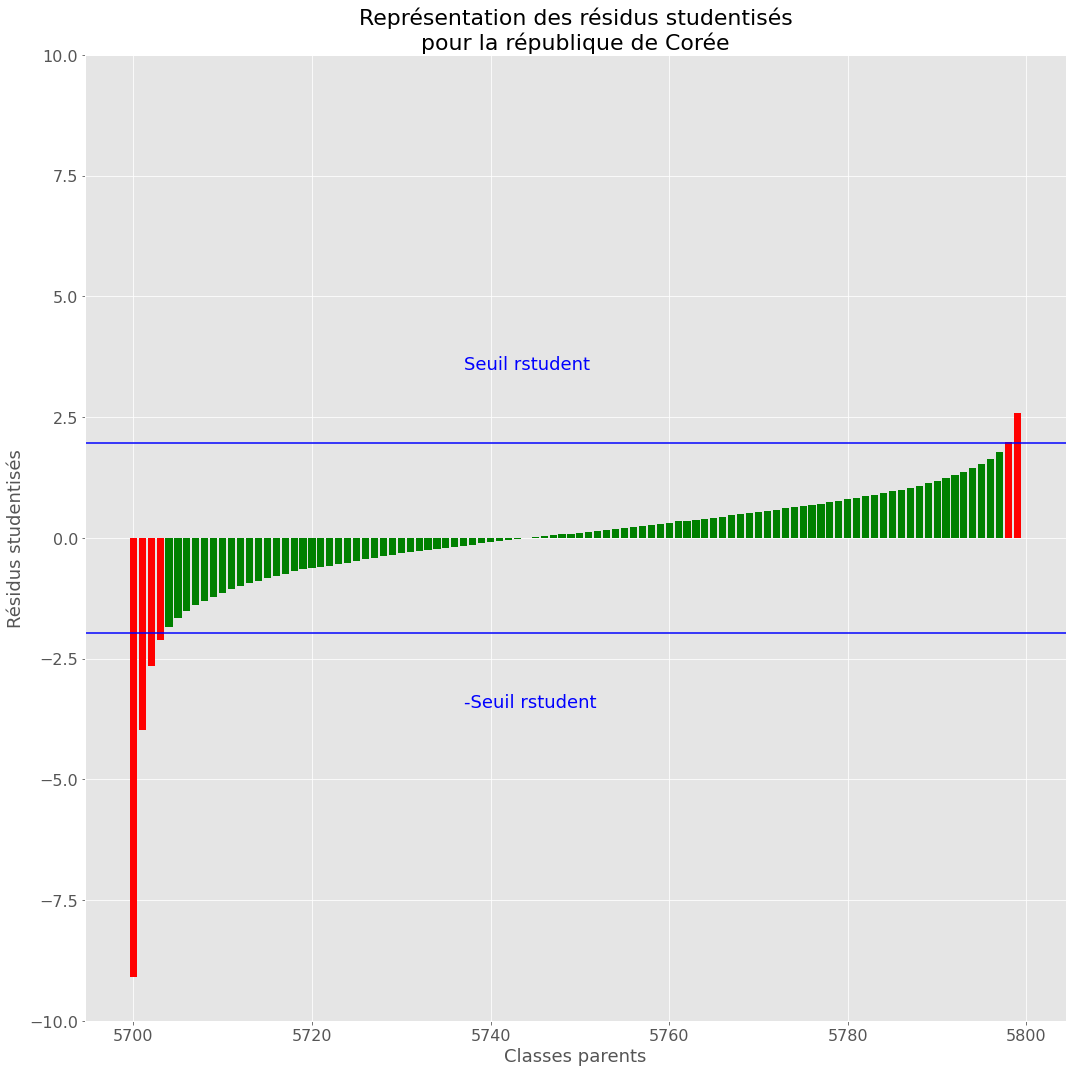

In [227]:
m4_korea = data_m4_rstudent.loc[(data_m4_rstudent['country'] == 'Korea, Rep.')]

# Représentation des leviers
plt.figure(figsize=(15,15))

# Individus entre le seuil mini et le seuil maxi
plt.bar(m4_korea.loc[(m4_korea['rstudent'] <= seuil_rstudent) & (m4_korea['rstudent'] >= -seuil_rstudent)].index,
        m4_korea.loc[(m4_korea['rstudent'] <= seuil_rstudent) & (m4_korea['rstudent'] >= -seuil_rstudent)]['rstudent'], color='g')

# Individus au dessus du seuil maxi
plt.bar(m4_korea.loc[m4_korea['rstudent'] > seuil_rstudent].index,
        m4_korea.loc[m4_korea['rstudent'] > seuil_rstudent]['rstudent'], color='r')

# Individus au dessous du seuil maxi
plt.bar(m4_korea.loc[m4_korea['rstudent'] < -seuil_rstudent].index,
        m4_korea.loc[m4_korea['rstudent'] < -seuil_rstudent]['rstudent'], color='r')

# Décoration et annotations
plt.title('Représentation des résidus studentisés\npour la république de Corée', fontsize=22)
plt.xlabel('Classes parents', fontsize=18)
plt.xticks(fontsize=16)
plt.ylim(-10,10)
plt.yticks(fontsize=16)
plt.ylabel('Résidus studentisés', fontsize=18)

plt.axhline(y=seuil_rstudent, color='b', linestyle='-')
plt.text(5737, 3.5 , 'Seuil rstudent', fontsize = '18', color='b')

plt.axhline(y=-seuil_rstudent, color='b', linestyle='-')
plt.text(5737, -3.5 , '-Seuil rstudent', fontsize = '18', color='b')

plt.tight_layout()

# plt.savefig('graph/res_kor.png')
plt.show()

In [228]:
# nombre de valeurs atypiques sur les variables à expliquer
res_stu_ln = data_m4_rstudent.loc[(data_m4_rstudent['rstudent'] > seuil_rstudent) | (data_m4_rstudent['rstudent'] < -seuil_rstudent)]
len(res_stu_ln)

640

In [229]:
# pays presentants des valeurs atypiques
data_m4_rstudent.loc[data_m4_rstudent.index.isin(res_stu_ln.index)].groupby(by='country').count().sort_values(by='y_child', ascending=False)

,mj,Gj,pj,ln_mj,rstudent,y_child,ln_y_child,c_i_parent,levier
country,,,,,,,,,
South Africa,29,29,29,29,29,29,29,29,29
Honduras,22,22,22,22,22,22,22,22,22
Bolivia,20,20,20,20,20,20,20,20,20
Colombia,17,17,17,17,17,17,17,17,17
Brazil,16,16,16,16,16,16,16,16,16
...,...,...,...,...,...,...,...,...,...
Kazakhstan,1,1,1,1,1,1,1,1,1
Cyprus,1,1,1,1,1,1,1,1,1
Cambodia,1,1,1,1,1,1,1,1,1


##### analyse de l'influence des observations

In [230]:
# création du dataframe avec tous les resultats d'influences disponibles
influence_ln = reg_multi_ln.get_influence().summary_frame()
influence_ln.head()

,dfb_Intercept,dfb_Gj,dfb_ln_mj,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
0,-0.012627,0.014549,0.005306,0.000161,-1.764461,0.000155,-0.021960,-1.764622,-0.021962
1,-0.010346,0.011921,0.004348,0.000108,-1.445786,0.000155,-0.017994,-1.445854,-0.017995
2,-0.009372,0.010799,0.003938,0.000089,-1.309708,0.000155,-0.016300,-1.309749,-0.016301
3,-0.008651,0.009968,0.003635,0.000075,-1.208936,0.000155,-0.015046,-1.208960,-0.015046
4,-0.008240,0.009495,0.003463,0.000068,-1.151560,0.000155,-0.014332,-1.151576,-0.014332


In [231]:
# ajout de la colonne distance de Cook à notre dataframe analyses_ln
data_agg['cooks_distance'] = influence_ln['cooks_d']

# seuil d'influence selon Cook
seuil_dcook = 4/(n-p)
data_agg.sort_values(by='cooks_distance').head()

,country,y_child,mj,Gj,pj,ln_mj,ln_y_child,c_i_parent,levier,rstudent,cooks_distance
3351,Eswatini,362.52875,530.283828,0.478735,0.629976,6.273412,5.893104,51.764,0.000332,0.000087,8.446875e-13
1352,Burkina Faso,693.67725,917.952658,0.413469,0.661654,6.822146,6.542007,51.910,0.000195,-0.000172,1.922609e-12
10151,"Taiwan, China",13724.78200,16500.223670,0.331487,0.181000,9.711129,9.526958,51.950,0.000266,-0.000317,8.879644e-12
6853,Mali,576.89970,681.075039,0.346782,0.713953,6.523672,6.357668,51.526,0.000328,-0.000336,1.234295e-11
2654,Czech Republic,7657.33450,8235.293411,0.270162,0.434041,9.016184,8.943419,52.078,0.000274,0.000528,2.549086e-11


In [232]:
data_agg.sort_values(by='cooks_distance').tail()

,country,y_child,mj,Gj,pj,ln_mj,ln_y_child,c_i_parent,levier,rstudent,cooks_distance
9598,South Africa,46297.316000,5617.904880,0.682949,0.677,8.633714,10.742839,84.132,0.001162,3.977135,0.006135
9501,South Africa,138.341550,5617.904880,0.682949,0.677,8.633714,4.929726,18.124,0.001162,-4.109191,0.006549
5700,"Korea, Rep.",17.317732,15227.569445,0.367935,0.394,9.630863,2.851731,24.884,0.000238,-9.087780,0.006565
9599,South Africa,82408.550000,5617.904880,0.682949,0.677,8.633714,11.319444,88.096,0.001162,4.779222,0.008859
9500,South Africa,60.490383,5617.904880,0.682949,0.677,8.633714,4.102484,12.478,0.001162,-5.259924,0.010731


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


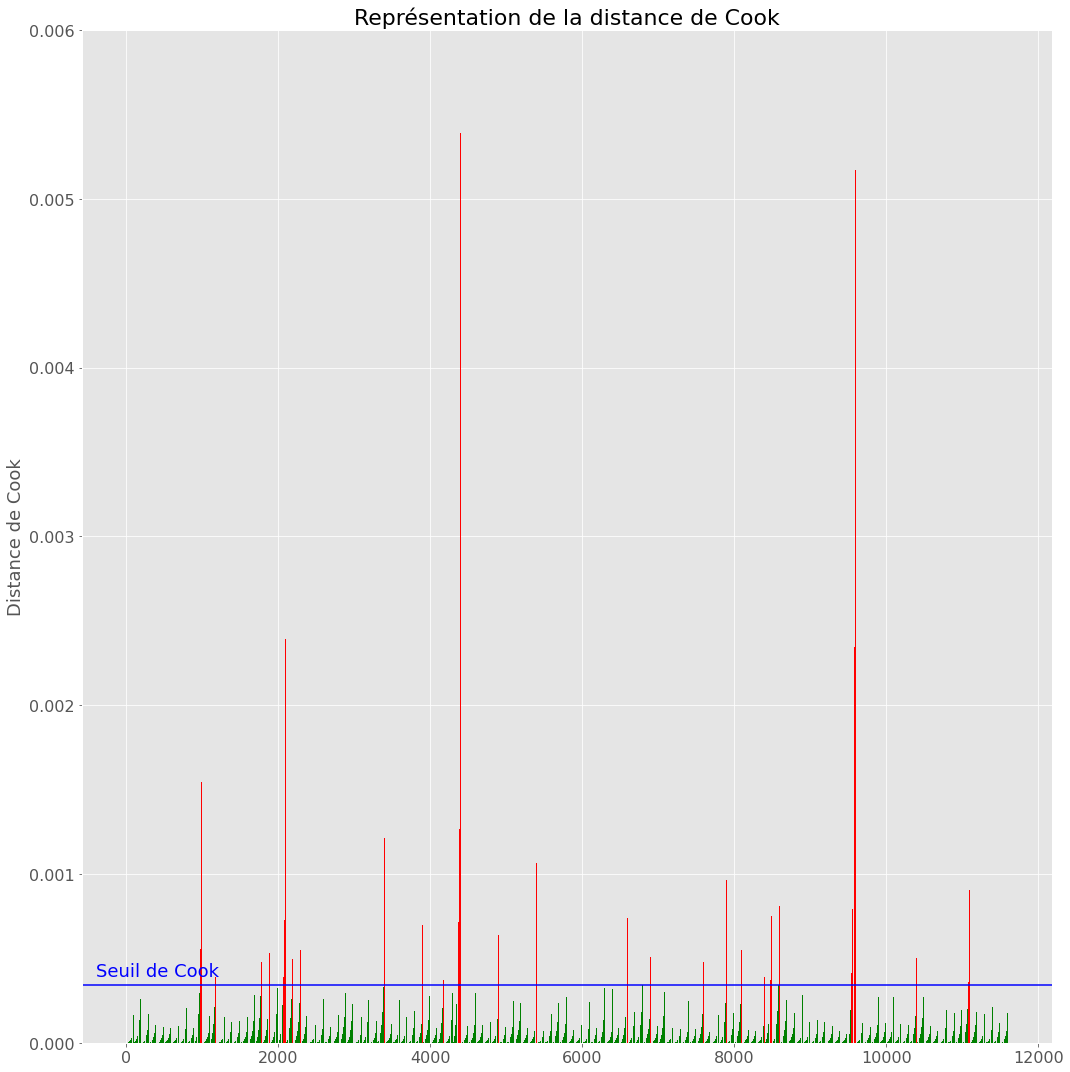

In [233]:
data_m4_cooks = data_agg.groupby(['country', 'mj', 'Gj', 'pj', 'ln_mj', 'cooks_distance']).mean()
data_m4_cooks.reset_index(inplace=True)

# représentation de la distances de Cooks
plt.figure(figsize=(15,15))

# individus sous le seuil
plt.bar(data_m4_cooks.loc[data_m4_cooks['cooks_distance'] <= seuil_dcook].index,
        data_m4_cooks.loc[data_m4_cooks['cooks_distance'] <= seuil_dcook]['cooks_distance'],
       color='g')

# individus au dessus le seuil
plt.bar(data_m4_cooks.loc[data_m4_cooks['cooks_distance'] > seuil_dcook].index,
        data_m4_cooks.loc[data_m4_cooks['cooks_distance'] > seuil_dcook]['cooks_distance'],
       color='r')

# annotations
plt.title('Représentation de la distance de Cook', fontsize=22)
plt.ylabel('Distance de Cook', fontsize=18)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)

# x1,y1,y2 = plt.axis()  
# plt.axis((x1,x2,25,250))

axes = plt.axes()
axes.set_ylim([0, 0.006])

plt.text(-400, (seuil_dcook + 0.00005), 'Seuil de Cook', fontsize = '18', color='b')
plt.axhline(y=seuil_dcook, color='b', linestyle='-')

plt.tight_layout()

# plt.savefig('graph/dist_cook.png')
plt.show()

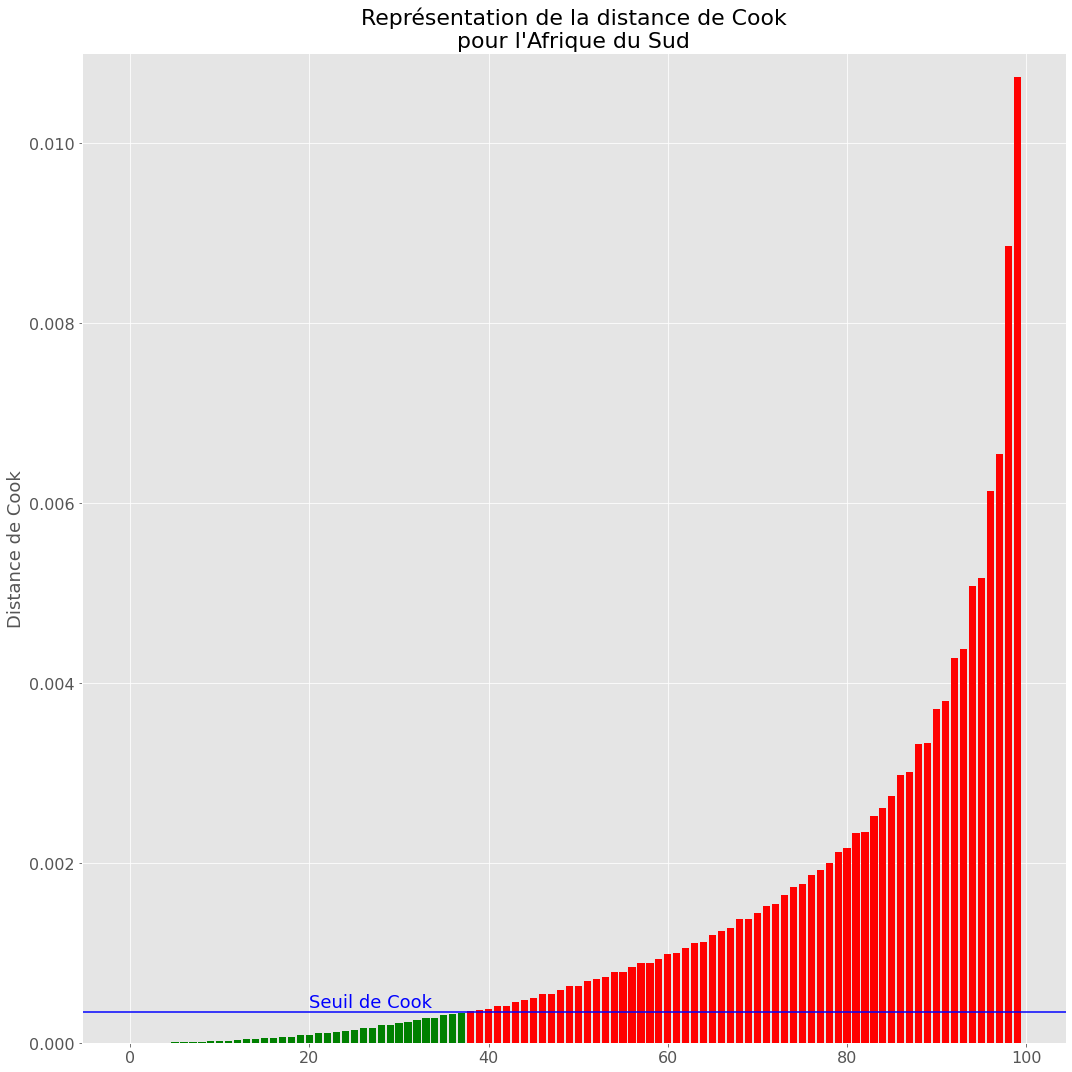

In [234]:
cook_africa = data_m4_cooks.loc[data_m4_cooks['country'] == 'South Africa']
cook_africa.reset_index(inplace=True)

# représentation de la distances de Cooks
plt.figure(figsize=(15,15))

# individus sous le seuil
plt.bar(cook_africa.loc[cook_africa['cooks_distance'] <= seuil_dcook].index,
        cook_africa.loc[cook_africa['cooks_distance'] <= seuil_dcook]['cooks_distance'],
       color='g')

# individus au dessus le seuil
plt.bar(cook_africa.loc[cook_africa['cooks_distance'] > seuil_dcook].index,
        cook_africa.loc[cook_africa['cooks_distance'] > seuil_dcook]['cooks_distance'],
       color='r')

# annotations
plt.title('Représentation de la distance de Cook\npour l\'Afrique du Sud', fontsize=22)
plt.ylabel('Distance de Cook', fontsize=18)
plt.ylim(0,0.011)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)

plt.text(20, (seuil_dcook + 0.00005), 'Seuil de Cook', fontsize = '18', color='b')
plt.axhline(y=seuil_dcook, color='b', linestyle='-')

plt.tight_layout()

# plt.savefig('graph/dist_cook_saf.png')
plt.show()

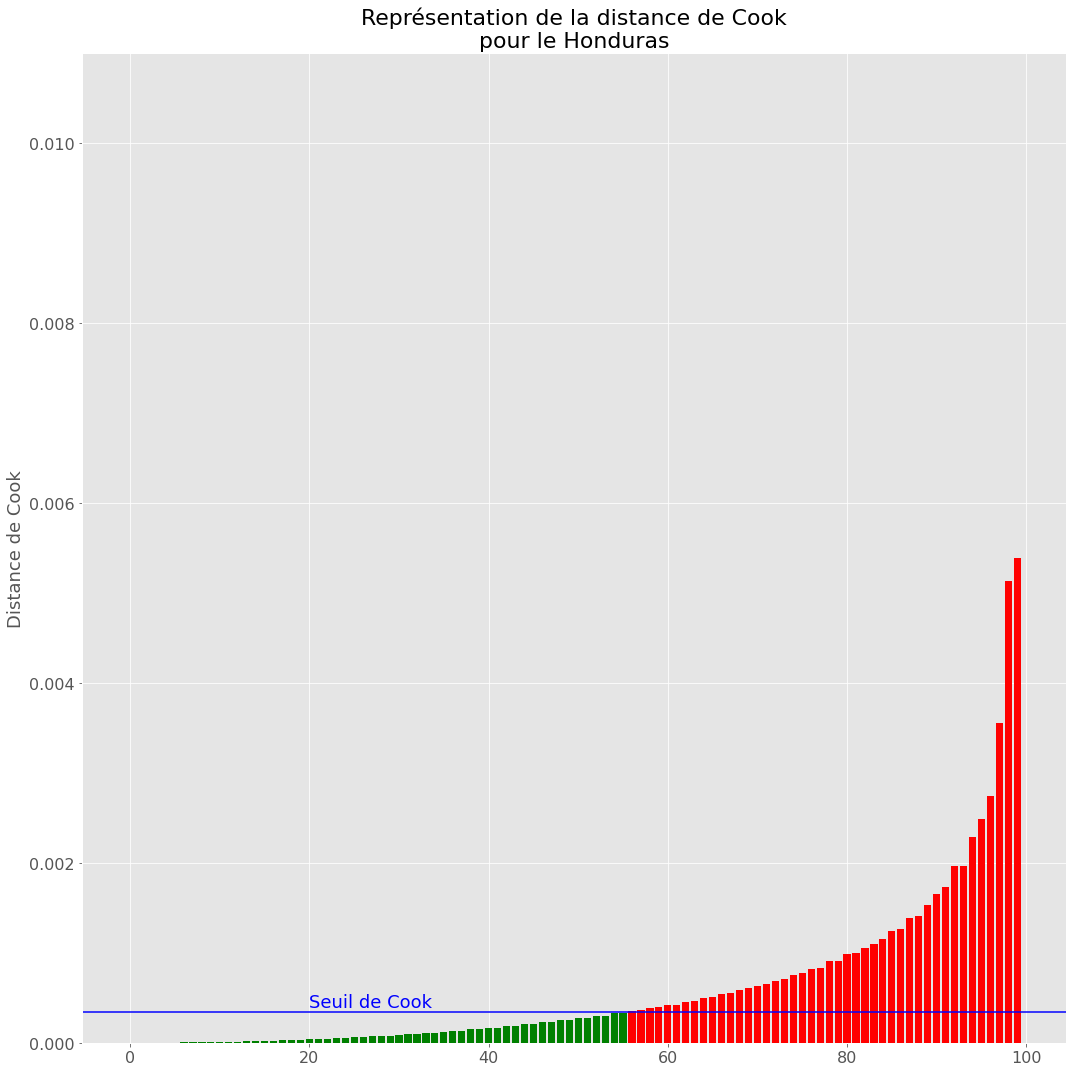

In [235]:
cook_honduras = data_m4_cooks.loc[data_m4_cooks['country'] == 'Honduras']
cook_honduras.reset_index(inplace=True)

# représentation de la distances de Cooks
plt.figure(figsize=(15,15))

# individus sous le seuil
plt.bar(cook_honduras.loc[cook_honduras['cooks_distance'] <= seuil_dcook].index,
        cook_honduras.loc[cook_honduras['cooks_distance'] <= seuil_dcook]['cooks_distance'],
       color='g')

# individus au dessus le seuil
plt.bar(cook_honduras.loc[cook_honduras['cooks_distance'] > seuil_dcook].index,
        cook_honduras.loc[cook_honduras['cooks_distance'] > seuil_dcook]['cooks_distance'],
       color='r')

# annotations
plt.title('Représentation de la distance de Cook\npour le Honduras', fontsize=22)
plt.ylabel('Distance de Cook', fontsize=18)
plt.ylim(0,0.011)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)

plt.text(20, (seuil_dcook + 0.00005), 'Seuil de Cook', fontsize = '18', color='b')
plt.axhline(y=seuil_dcook, color='b', linestyle='-')

plt.tight_layout()

# plt.savefig('graph/dist_cook_hon.png')
plt.show()

In [236]:
# nombre d'observations influentes
dco_ln = data_agg.loc[data_agg['cooks_distance'] > seuil_dcook]
len(dco_ln)

657

In [237]:
# pays présentants des obervations au dela du seuil
data_m4_cooks.loc[data_m4_cooks.index.isin(dco_ln.index)].groupby(by='country').count().sort_values(by='y_child', ascending=False)

,mj,Gj,pj,ln_mj,cooks_distance,y_child,ln_y_child,c_i_parent,levier,rstudent
country,,,,,,,,,,
South Africa,62,62,62,62,62,62,62,62,62,62
Honduras,44,44,44,44,44,44,44,44,44,44
Bolivia,31,31,31,31,31,31,31,31,31,31
Colombia,31,31,31,31,31,31,31,31,31,31
Brazil,26,26,26,26,26,26,26,26,26,26
...,...,...,...,...,...,...,...,...,...,...
Lithuania,1,1,1,1,1,1,1,1,1,1
Mauritania,1,1,1,1,1,1,1,1,1,1
Morocco,1,1,1,1,1,1,1,1,1,1


##### mesures atypiques et influentes

In [238]:
data_agg.head(3)

,country,y_child,mj,Gj,pj,ln_mj,ln_y_child,c_i_parent,levier,rstudent,cooks_distance
0,Albania,728.89795,2994.829902,0.32141,0.815874,8.004643,6.591534,9.380,0.000155,-1.764461,0.000161
1,Albania,916.66235,2994.829902,0.32141,0.815874,8.004643,6.820739,14.344,0.000155,-1.445786,0.000108
2,Albania,1010.91600,2994.829902,0.32141,0.815874,8.004643,6.918612,16.388,0.000155,-1.309708,0.000089


In [239]:
# obeservations atypiques et influentes
ind_aty_infl_ln = data_agg.loc[((data_agg['cooks_distance'] > seuil_dcook) &
                                  (data_agg['rstudent'] > seuil_rstudent) &
                                  (data_agg['levier'] > seuil_levier)) |
                                  ((data_agg['cooks_distance'] > seuil_dcook) &
                                  (data_agg['rstudent'] < -seuil_rstudent) &
                                  (data_agg['levier'] > seuil_levier))]
len(ind_aty_infl_ln)

51

In [240]:
# pays contenants les observations influentes et atypiques
susp_pt = data_agg.loc[data_agg.index.isin(ind_aty_infl_ln.index)]
susp_pt.reset_index(inplace=True)
susp_pt.groupby('country').count()

,index,y_child,mj,Gj,pj,ln_mj,ln_y_child,c_i_parent,levier,rstudent,cooks_distance
country,,,,,,,,,,,
Honduras,22,22,22,22,22,22,22,22,22,22,22
South Africa,29,29,29,29,29,29,29,29,29,29,29


##### détection des problèmes de colinéarité

In [241]:
# facteur d'influence de la variance (Variance Inflation Factor)
mat_cor = np.corrcoef(data_agg.ln_mj, data_agg.Gj)
1 / (1-(mat_cor[0,1]**2)), mat_cor[0,1]

(1.0769055273597419, -0.2672329305316404)

In [242]:
# inmpact du R2 sur le VIF
1 / (1 - 0.94**2), 1 / (1 - 0.95**2), 1 / (1 - 0.89**2), 1 / (1 - 0.90**2)

(8.591065292096216, 10.256410256410254, 4.810004810004811, 5.263157894736843)

- VIF_ln_mj et VIF_Gj < 10 (ou même 5)
> Pas de problème de colinéarité

##### test d'homoscédasticité

In [243]:
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(reg_multi_ln.resid, reg_multi_ln.model.exog)
print('p-value test Breusch Pagan:', pval)

p-value test Breusch Pagan: 3.99926438134738e-154


p value test Breusch Pagan: 3.999264381321618e-154
- **H0**: Homoscédasticité
- **H1**: Hétéroscédasticité

> pvalue < alpha, rejet de H0 (il y a hétéroscédasticité des residus)

Encore une fois, le modèle de regression linéaire multiple est suffisamment robuste pour les grands échantillons.

> 11 660 ici, c'est notre cas.

Plus on a de données à disposition, plus le modèle est capable de supporter des écarts important aux hypothèse (gaussienne et homoscédastique)

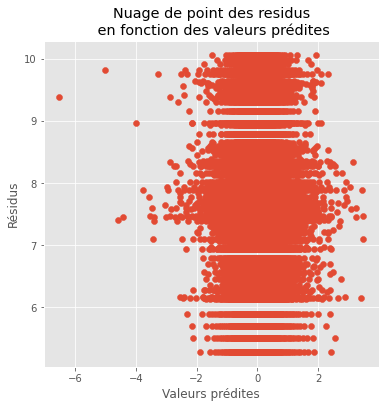

In [244]:
# représentation des résidus en fonction des valeurs prédites
plt.figure(figsize=(6,6))

plt.scatter(reg_multi_ln.resid, reg_multi_ln.predict())

plt.ylabel('Résidus')
plt.xlabel('Valeurs prédites')
plt.title('Nuage de point des residus\n en fonction des valeurs prédites')

# plt.savefig('graph/homoscedasticity.png')
plt.show()

##### test de normalité des résidus

In [245]:
# préparation des données
X_ln = reg_multi_ln.resid
Xbar_ln = np.mean(X_ln)
Xsprime_ln = np.std(X_ln)

# test d'adequation à une loi (ici Normale) avec le test Kolmogorv-Smirnov
ks_2samp(reg_multi_ln.resid, list(np.random.normal(Xbar_ln, Xsprime_ln, 11_600)))

Ks_2sampResult(statistic=0.0371551724137931, pvalue=2.2196810650541358e-07)

- **H0**: Les données suivent une loi normale
- **H1**: Les données ne suivent pas une loi normale

> p-value < 0.05

On rejette H0, y_child ne suit pas une loi normale

In [246]:
# test de Jarque-Bera (test de normalité basé sur le kurtosis et le skewness)
JB_ln, JBpv_ln, skw_ln, kurt_ln = sm.stats.stattools.jarque_bera(reg_multi_ln.resid)
JB_ln, JBpv_ln, skw_ln, kurt_ln

(3504.761098891414, 0.0, -0.08087638372156945, 5.68794826996351)

- **H0**: Les données suivent une loi normale
- **H1**: Les données ne suivent pas une loi normale

> JBpv ~ 0

On rejette H0, d'après le test, les données ne suivent pas une loi normale

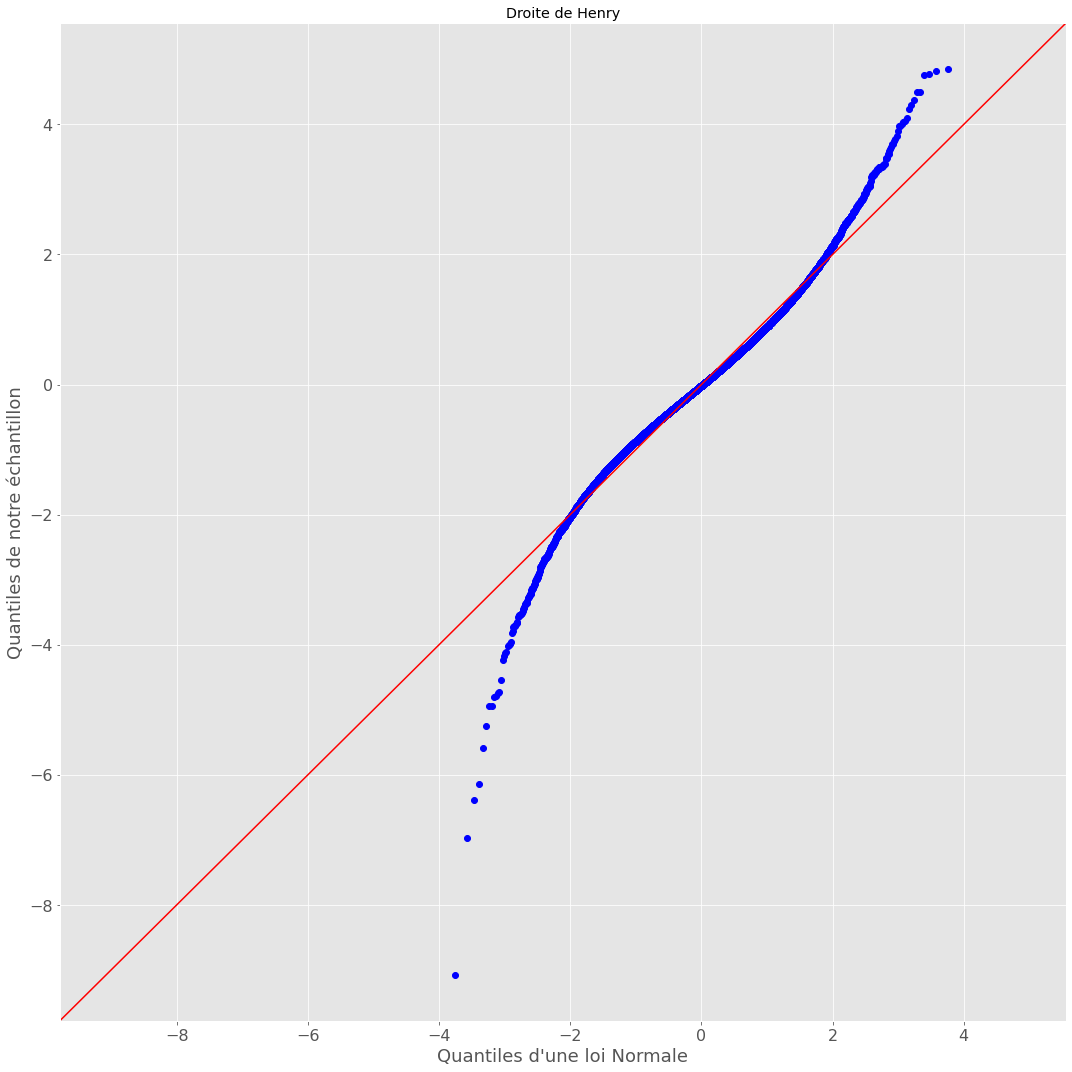

In [247]:
# droite de Henry
fig, ax = plt.subplots(figsize=(15, 15))

sm.qqplot(reg_multi_ln.resid, line='45', fit=True, ax=ax)

plt.ylabel('Quantiles de notre échantillon', fontsize=18)
plt.yticks(fontsize=16)
plt.xlabel('Quantiles d\'une loi Normale', fontsize=18)
plt.xticks(fontsize=16)
plt.title('Droite de Henry')

plt.tight_layout()

# plt.savefig('graph/droite_henry_reg1.png')
plt.show()

La droite de Henry represente la distribution empirique des residus et la distribution théorique d'une loi normale.

Sauf pour les valeurs faibles de nos résidus, nos residus semblent plutôt alignés avec la distribution théorique d'une loi normale.

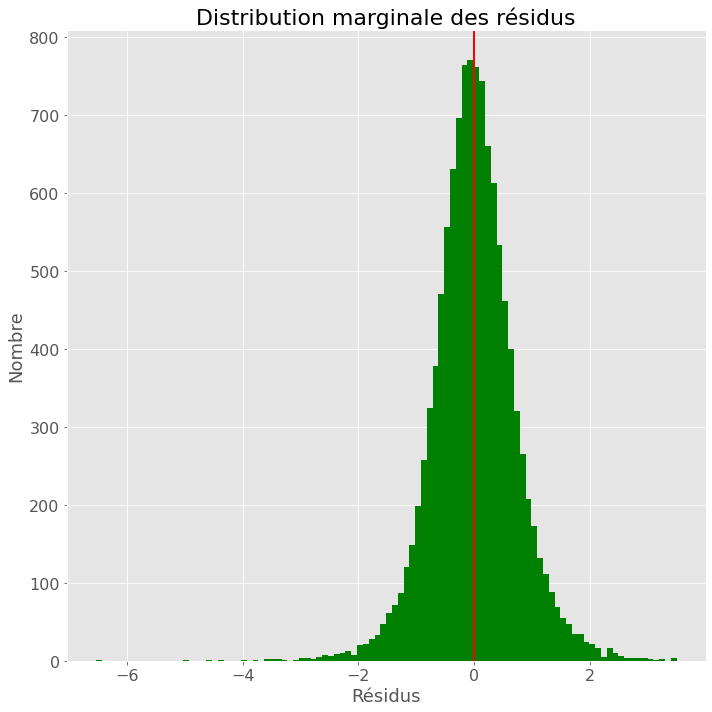

In [248]:
# représentation de la distribution marginale
plt.figure(figsize=(10,10,))

plt.hist(X_ln, 100, facecolor='g',)
plt.axvline(Xbar_ln, color='r', linewidth=2)

plt.title(f'Distribution marginale des résidus', fontsize=22)
plt.ylabel('Nombre', fontsize=18)
plt.yticks(fontsize=16)
plt.xlabel('Résidus', fontsize=18)
plt.xticks(fontsize=16)

plt.tight_layout()

# plt.savefig('graph/dist_marg_resid_reg1.png')
plt.show()

#### régression linéaire du revenu enfant sur le revenu moyen du pays, l'indice de Gini et la classe de revenus des parents

##### tests de significativité

In [249]:
data_m3.head(1)

,country,y_child,Gj,pj,c_i_parent,mj,ln_y_child,ln_mj
0,Albania,728.89795,0.32141,0.815874,1,2994.829902,6.591534,8.004643


In [250]:
reg2 = smf.ols('y_child ~ Gj + mj + c_i_parent', data=data_m3)
reg_multi2 = reg2.fit()
reg_multi2.summary().tables[0]

Dep. Variable:,y_child,R-squared:,0.522
Model:,OLS,Adj. R-squared:,0.522
Method:,Least Squares,F-statistic:,2.114e+06
Date:,"Tue, 29 Mar 2022",Prob (F-statistic):,0.00
Time:,15:37:47,Log-Likelihood:,-5.9157e+07
No. Observations:,5800000,AIC:,1.183e+08
Df Residuals:,5799996,BIC:,1.183e+08
Df Model:,3,,
Covariance Type:,nonrobust,,


Test global:
- **H0**: beta_GJ = beta_y_mj = beta_c_i_parent = 0
- **H1**: beta_GJ != beta_y_mj = beta_c_i_parent != 0

F ~ 0.00 < alpha

On rejette H0, le modèle est globalement significatif

In [251]:
reg_multi2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-2651.9715,15.077,-175.894,0.000,-2681.522,-2622.421
Gj,2.1447,32.656,0.066,0.948,-61.859,66.149
mj,1.0000,0.000,2294.714,0.000,0.999,1.001
c_i_parent,52.4940,0.094,560.656,0.000,52.310,52.677


Test de significativité des variables:

- **H0**: beta_Gj = 0
- **H1**: beta_Gj != 0

Le paramètre beta_Gj de la variable Gj (indice de gini) n'est pas significatif au niveau de test alpha (0.05)
> En effet p-value ~ 1 > alpha, on accepte H0, le paramètre n'est pas significatif (beta_Gj = 0)

- **H0**: beta_y_mj = 0
- **H1**: beta_y_mj != 0

Le paramètre beta_y_mj de la variable mj est significatif au niveau de test alpha (0.05)
>En effet p-value ~ 0.00 < alpha, on rejette H0, le paramètre est significatif (beta_y_mj != 0)

- **H0**: beta_c_i_parent = 0
- **H1**: beta_c_i_parent != 0

Le paramètre beta_c_i_parent de la variable c_i_parent est significatif au niveau de test alpha (0.05)
> En effet p-value ~ 0.00 > alpha, on rejette H0, le paramètre est significatif (beta_c_i_parent != 0)

##### passage au logarithme du revenu enfant

In [252]:
reg_ln2 = smf.ols('ln_y_child ~ Gj + ln_mj + c_i_parent', data=data_m3)
reg_multi_ln2 = reg_ln2.fit()
reg_multi_ln2.summary().tables[0]

Dep. Variable:,ln_y_child,R-squared:,0.785
Model:,OLS,Adj. R-squared:,0.785
Method:,Least Squares,F-statistic:,7.060e+06
Date:,"Tue, 29 Mar 2022",Prob (F-statistic):,0.00
Time:,15:37:50,Log-Likelihood:,-5.6444e+06
No. Observations:,5800000,AIC:,1.129e+07
Df Residuals:,5799996,BIC:,1.129e+07
Df Model:,3,,
Covariance Type:,nonrobust,,


Test global:
- **H0**: beta_GJ = beta_y_mj = beta_c_i_parent = 0
- **H1**: beta_GJ != beta_y_mj = beta_c_i_parent != 0

F ~ 0.00 < alpha

On rejette H0, le modèle est globalement significatif

In [253]:
reg_multi_ln2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.0775,0.003,-29.531,0.000,-0.083,-0.072
Gj,-1.6518,0.003,-529.870,0.000,-1.658,-1.646
ln_mj,0.9864,0.000,4100.958,0.000,0.986,0.987
c_i_parent,0.0113,9.21e-06,1231.573,0.000,0.011,0.011


Test de significativité des variables:

- **H0**: beta_Gj = 0
- **H1**: beta_Gj != 0

Le paramètre beta_Gj de la variable Gj (indice de gini) est significatif au niveau de test alpha (0.05)
> En effet p-value ~ 0 < alpha, on rejette H0, le paramètre est significatif (beta_Gj = 0)

- **H0**: beta_y_mj = 0
- **H1**: beta_y_mj != 0

Le paramètre beta_ln_mj de la variable ln_mj est significatif au niveau de test alpha (0.05)
> En effet p-value ~ 0.00 < alpha, on rejette H0, le paramètre est significatif (beta_y_mj != 0)

- **H0**: beta_c_i_parent = 0
- **H1**: beta_c_i_parent != 0

Le paramètre beta_c_i_parent de la variable c_i_parent est significatif au niveau de test alpha (0.05)
> En effet p-value ~ 0.00 < alpha, on rejette H0, le paramètre est significatif (beta_c_i_parent != 0)

##### analyses de $R^{2}$

In [254]:
# anova sur les variables de notre régression linéaire
anova2 = sm.stats.anova_lm(reg_multi_ln2, typ=1)
anova2

,df,sum_sq,mean_sq,F,PR(>F)
Gj,1.0,1.167249e+06,1.167249e+06,2.846735e+06,0.0
ln_mj,1.0,6.895167e+06,6.895167e+06,1.681622e+07,0.0
c_i_parent,1.0,6.219231e+05,6.219231e+05,1.516771e+06,0.0
Residual,5799996.0,2.378177e+06,4.100309e-01,NaN,NaN


In [255]:
# calcul du R2 pour la variable 'c_i_parent'
r2_c_i_parent = anova2.sum_sq['c_i_parent'] / anova2['sum_sq'].sum()
r2_c_i_parent

0.0562189511095877

In [256]:
# vérification
r2_Gj + r2_ln_mj + r2_c_i_parent, reg_multi_ln2.rsquared

(0.7850238481218351, 0.785023848121845)

Dans notre modèle : 

In [257]:
print(f"La variable Gj explique {100 * r2_Gj:.2f}% de la variance de la variable ln_y_child")
print(f"La variable ln_mj explique {100 * r2_ln_mj:.2f}% de la variance de la variable ln_y_child")
print(f"La variable c_i_parent explique {100 * r2_c_i_parent:.2f}% de la variance de la variable ln_y_child")
print(f"Notre modèle explique {100 * reg_multi_ln2.rsquared:.2f}% de la variance de la variable ln_y_child")

La variable Gj explique 10.55% de la variance de la variable ln_y_child
La variable ln_mj explique 62.33% de la variance de la variable ln_y_child
La variable c_i_parent explique 5.62% de la variance de la variable ln_y_child
Notre modèle explique 78.50% de la variance de la variable ln_y_child


##### détection des problèmes de colinéarité

In [258]:
# facteur d'influence de la variance (Variance Inflation Factor)
variables_ln2 = reg_multi_ln2.model.exog
[variance_inflation_factor(variables_ln2, i) for i in np.arange(1,variables_ln2.shape[1])]

[1.0769055410030066, 1.0769055558751346, 1.0000000316166462]

VIF_Gj, VIF_ln_mj et CIF_c_i_parent < 10 (ou 5)

Pas de problème de colinéarité

##### test d'homoscédasticité

In [259]:
_, pval2, __, f_pval2 = statsmodels.stats.diagnostic.het_breuschpagan(reg_multi_ln2.resid, variables_ln2)
print('p value test Breusch Pagan:', pval2)

p value test Breusch Pagan: 0.0


p value test Breusch Pagan: 0.00
- **H0**: Homoscédasticité
- **H1**: Hétéroscédasticité

> pvalue < alpha, rejet de H0 (il y a hétéroscédasticité des residus)

Toutefois, le modèle de regression linéaire multiple est robuste pour les grands échantillon

> 5 800 000 ici, c'est notre cas

Plus on a de données à disposition, plus le modèle est capable de supporter des écarts important aux hypothèse (gaussienne et homoscédastique)

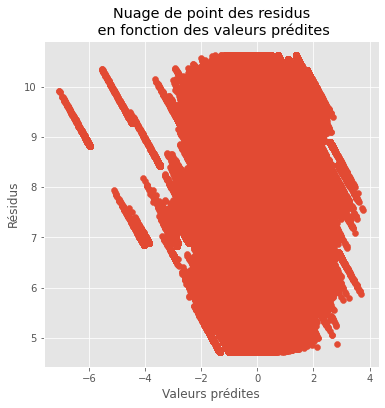

In [260]:
# représentation des résidus en fonction des valeurs prédites
plt.figure(figsize=(6,6))

plt.scatter(reg_multi_ln2.resid, reg_multi_ln2.predict())

plt.ylabel('Résidus')
plt.xlabel('Valeurs prédites')
plt.title('Nuage de point des residus\n en fonction des valeurs prédites')

# plt.savefig('graph/homoscedasticity2.png')
plt.show()


##### test de normalité des résidus

In [261]:
# préparation des données
X_ln2 = reg_multi_ln2.resid
Xbar_ln2 = np.mean(X_ln2)
Xsprime_ln2 = np.std(X_ln2)

# test d'adequation à une loi (ici Normale) avec le test Kolmogorv-Smirnov
ks_2samp(reg_multi_ln2.resid, list(np.random.normal(Xbar_ln2, Xsprime_ln2, 5_800_000)))

Ks_2sampResult(statistic=0.02689258620689655, pvalue=0.0)

- **H0**: Les données suivent une loi normale
- **H1**: Les données ne suivent pas une loi normale

> p-value < 0.05

On rejette H0, y_child ne suit pas une loi normale

In [262]:
# test de Jarque-Bera (test de normalité basé sur le kurtosis et le skewness)
JB_ln1, JBpv_ln1, skw_ln1, kurt_ln1 = sm.stats.stattools.jarque_bera(reg_multi_ln2.resid)
JB_ln1, JBpv_ln1, skw_ln1, kurt_ln1

(1821790.2462377877, 0.0, -0.1312402056531007, 5.733047096540024)

- **H0**: Les données suivent une loi normale
- **H1**: Les données ne suivent pas une loi normale

> JBpv ~ 0

On rejette H0, d'après le test, les données ne suivent pas une loi normale

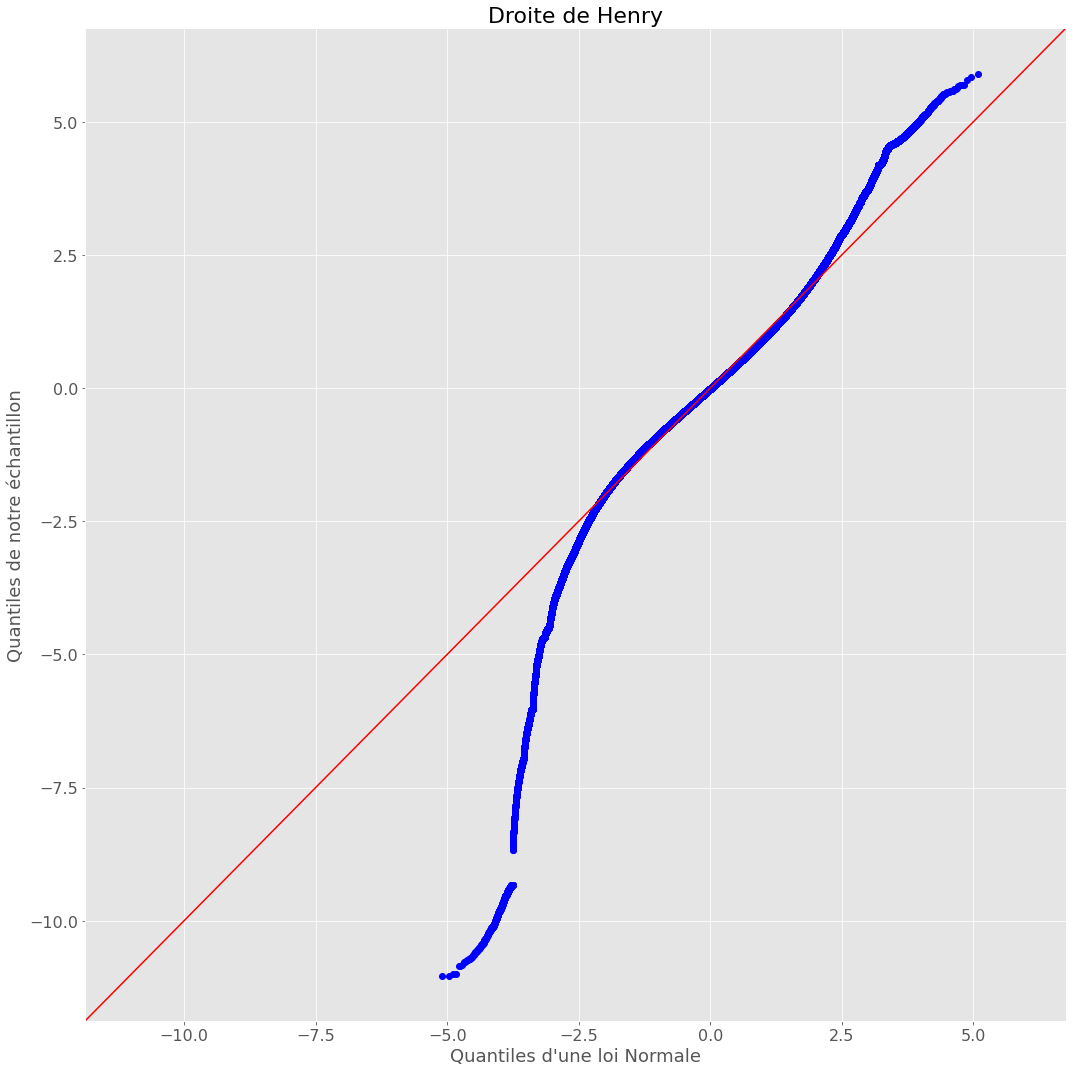

In [263]:
# droite de Henry
fig, ax = plt.subplots(figsize=(15, 15))

sm.qqplot(X_ln2, line='45', fit=True, ax=ax)

plt.ylabel('Quantiles de notre échantillon',fontsize=18)
plt.yticks(fontsize=16)
plt.xlabel('Quantiles d\'une loi Normale',fontsize=18)
plt.xticks(fontsize=16)
plt.title('Droite de Henry',fontsize=22)

plt.tight_layout()

# plt.savefig('graph/droite_henry_reg2.png')
plt.show()

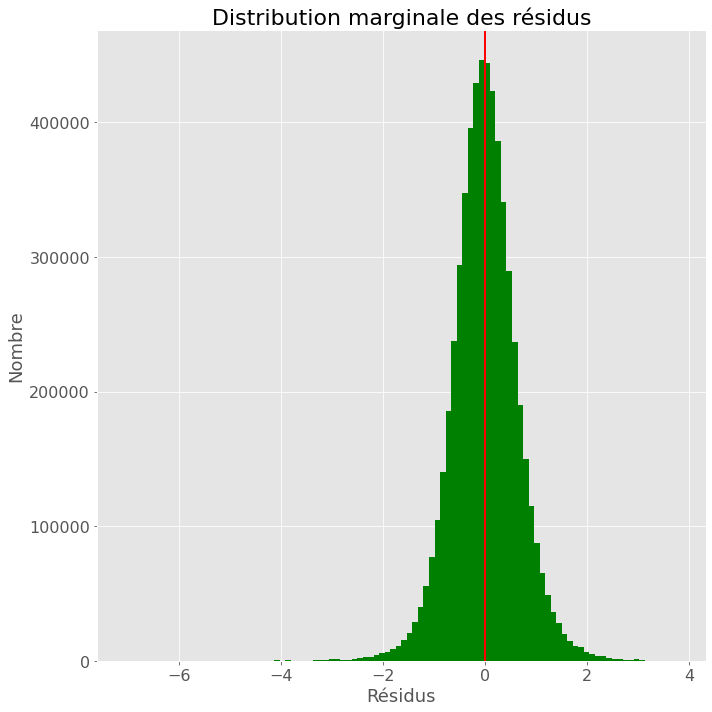

In [264]:
# représentation de la distribution marginale
plt.figure(figsize=(10,10))

plt.hist(X_ln2, 100, facecolor='g')
plt.axvline(Xbar_ln2, color='r', linewidth=2)

plt.title(f'Distribution marginale des résidus', fontsize=22)
plt.ylabel('Nombre',fontsize=18)
plt.yticks(fontsize=16)
plt.xlabel('Résidus', fontsize=18)
plt.xticks(fontsize=16)

plt.tight_layout()

# plt.savefig('graph/dist_marg_resid_reg2.png')
plt.show()

## Conclusion

In [265]:
aic = [anova_pillars.aic, reg_multi_ln.aic, reg_multi_ln2.aic, ]
bic = [anova_pillars.bic, reg_multi_ln.bic, reg_multi_ln2.bic, ]
R2 = [100 * anova_pillars.rsquared, 100 * reg_multi_ln.rsquared, 100 * reg_multi_ln2.rsquared, ]
model_ccl = pd.DataFrame({'AIC': aic,
                          'BIC': bic,
                          'R2': R2},
                        index= ['ANOVA', 'Reg_mj_Gj', 'Reg_mj_Gj_Cip'])

model_ccl = model_ccl[['AIC', 'BIC', 'R2']].round(1)
model_ccl

,AIC,BIC,R2
ANOVA,237471.7,238325.3,49.6
Reg_mj_Gj,25278.5,25300.6,72.9
Reg_mj_Gj_Cip,11288858.3,11288912.6,78.5


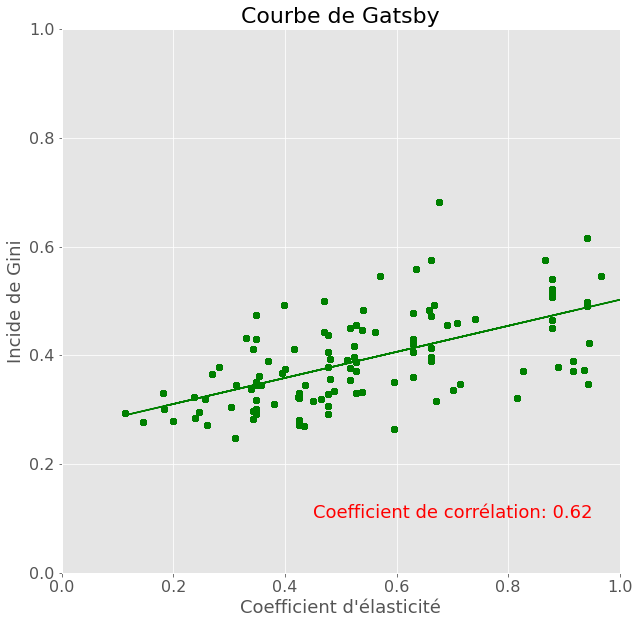

In [266]:
# préparation des données
y = data_agg.Gj
x = data_agg.pj

# calcul du coefficient de corrélation
pear = scipy.stats.pearsonr(x,y)[0]

# cacul des paramètres
slope, intercept, _, __, ___ = scipy.stats.linregress(x, y)

# droite de régression
fitLine = slope * x + intercept

# courbe de Gatsby
plt.figure(figsize=(10,10))
plt.plot(x, fitLine, c='g')
plt.scatter(x, y, c='g')
plt.text(0.45, 0.1, f'Coefficient de corrélation: {pear:.2}', color='r', fontsize=18)

# annotation
plt.title('Courbe de Gatsby', fontsize=22)
plt.ylabel('Incide de Gini', fontsize=18)
plt.ylim(0, 1)
plt.yticks(fontsize=16)
plt.xlabel('Coefficient d\'élasticité', fontsize=18)
plt.xticks(fontsize=16)
plt.xlim(0, 1)

# plt.savefig('graph/courbe_gatsby.png')
plt.show()

# **{sources}**

1. [ISO codes, countries, and population](https://www.fao.org/faostat/fr/#data)
2. [PPP approaches for Basic Headings](https://slidetodoc.com/international-comparison-program-frederic-a-vogel-global-manager/)
3. [EKS Method](https://stats.oecd.org/glossary/detail.asp?ID=5525)
4. [Baisic Heading](https://stats.oecd.org/glossary/detail.asp?ID=5513#:~:text=In%20theory%2C%20a%20basic%20heading,products%20than%20is%20theoretically%20desirable.)
5. [ANOVA document](https://eric.univ-lyon2.fr/~ricco/cours/slides/ANOVA.pdf)
6. [Numpy: theoreme central limite](https://openclassrooms.com/fr/courses/4452741-decouvrez-les-librairies-python-pour-la-data-science/4740938-utilisez-numpy-pour-illustrer-le-theoreme-central-limite)
7. [Matplot color gallery](https://matplotlib.org/stable/gallery/color/named_colors.html)
8. [Tip 1](https://datascience.stackexchange.com/questions/45075/how-to-compare-two-dataframes-and-put-the-counted-unique-values-in-a-first-dataf)
9. [Handling missing values](https://www.geeksforgeeks.org/working-with-missing-data-in-pandas/#:~:text=Filling%20missing%20values%20using%20fillna,in%20datasets%20of%20a%20DataFrame.)
10. [Open .txt files](https://www.w3schools.com/python/python_file_open.asp)
11. [Measuring
intergenerational
income mobility](https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/parcours-data-analyst/2011-measuring-intergenerational-income-mobility-art.pdf)
12. [Palette](https://seaborn.pydata.org/tutorial/color_palettes.html)
13. [Palette color guide](https://medium.com/@morganjonesartist/color-guide-to-seaborn-palettes-da849406d44f)
14. [Logarithm](https://www.chem.tamu.edu/class/fyp/mathrev/mr-log.html)
15. [Simple function](https://openclassrooms.com/forum/sujet/debutant-une-fonction-simple)
16. [Gini & lorenz curve](https://www.youtube.com/watch?v=y8y-gaNbe4U)
17. [Normality tests](https://www.researchgate.net/publication/333133367_Power_Comparisons_of_Shapiro-Wilk_Kolmogorov-Smirnov_and_Jarque-Bera_Tests)
18. [Parametric & non-parametric tests](https://www.statisticshowto.com/probability-and-statistics/statistics-definitions/parametric-and-non-parametric-data/)
19. [The Great Gatsby curve](https://www.youtube.com/watch?v=pDHOXP84FfI&ab_channel=Dr.TreforBazett)